<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/GBPEUR/GBPEUR_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "EURGBP"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-24 15:59:17,038 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-24 15:59:17,039 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for EURGBP
2019-08-24 16:00:36,430 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-24 16:03:23,301 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-24 16:04:41,597 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-24 16:06:00,746 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-24 16:07:24,824 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-24 16:08:44,827 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-24 16:10:06,227 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-24 16:11:26,373 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-30

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-24 16:15:35,225 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_436__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_EURGBP__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-EURGBP__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-EURGBP to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close       Volume
Date                                                                
2018-01-01 22:00:00  0.88906  0.88906  0.88722  0.88842   806.640015
2018-01-01 23:00:00  0.88842  0.88901  0.88795  0.88897  5997.120117
2018-01-02 00:00:00  0.88897  0.88926  0.88853  0.88922  2694.379883
2018-01-02 01:00:00  0.88921  0.88927  0.88898  0.88911  2631.209961
2018-01-02 02:00:00  0.88912  0.88915  0.88847  0.88872  2359.899902
...                      ...      ...      ...      ...          ...
2018-12-31 17:00:00  0.89786  0.89911  0.89744  0.89836  7170.839844
2018-12-31 18:00:00  0.89837  0.89891  0.89785  0.89828  5321.620117
2018-12-31 19:00:00  0.89827  0.89998  0.89776  0.89808  3970.419922
2018-12-31 20:00:00  0.89810  0.89901  0.89810  0.89877  3232.679932
2018-12-31 21:00:00  0.89876  0.89932  0.89814  0.89814  4272.660156

[6221 rows x 5 columns]

Open         High          Low        Close        Volume
count  6221.000000  6221.000000  6221.000000  6221.000000   6221.000000
mean      0.884675     0.885204     0.884170     0.884676   6526.284668
std       0.009026     0.009038     0.009029     0.009027   3662.397949
min       0.862280     0.863000     0.862050     0.862250    144.419998
25%       0.877380     0.877940     0.876890     0.877380   3367.900146
50%       0.884370     0.884830     0.883920     0.884370   6213.560059
75%       0.890740     0.891220     0.890220     0.890740   9064.480469
max       0.909530     0.909820     0.908940     0.909530  24843.320312

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close       Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2018-01-04 00:00:00  0.88892  0.88898  0.88856  0.88885  2488.580078    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  0.888731  0.873116  0.888051  0.889125  0.888758  0.888647    0.888920    0.889170  0.887800  0.888952  0.888951  0.888927  0.888898  0.888952  0.888873  0.887851                0.889259                 0.888952                0.888646                0.889413                 0.888952                0.888492                0.889566                 0.888952                0.888339                0.889720                 0.888952                0.888185  0.888758  0.888870  0.888008                0.889065                 0.888758                0.888451                0.889218                 0.888758                0.888298                0.889372                 0.888758                0.888144                0.889525                 0.888758   
2018-01-04 01:00:00  0.88885  0.88887  0.88844  0.88866  3095.409912    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.888728  0.873506  0.888244  0.889004  0.888736  0.888648    0.888910    0.889065  0.887974  0.888892  0.888793  0.888875  0.888833  0.888892  0.888755  0.887988                0.889216                 0.888892                0.888569                0.889378                 0.888892                0.888407                0.889540                 0.888892                0.888245                0.889702                 0.888892                0.888083  0.888736  0.888728  0.888142                0.889060                 0.888736                0.888412                0.889222                 0.888736                0.888250                0.889384                 0.888736                0.888088                0.889546                 0.888736   
2018-01-04 02:00:00  0.88865  0.88899  0.888

Open         High          Low        Close        Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  6171.000000  6171.000000  6171.000000  6171.000000   6171.000000  6171.000000  6171.000000  6171.000000    6171.000000  6171.000000   6171.000000     6171.000000     6171.000000       6171.000000  6171.000000  6171.000000  6171.000000  6171.000000   6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000  6171.000000             6171.000000              6171.000000             6171.000000             6171.000000              6171.000000             6171.000000             6171.000000              6171.000000             6171.000000             6171.000000              6171.000000             6171.000000  6171.000000  6171.000000  6171.000000             6171.000000              6171.000000             6171.000000             6171.000000              6171.000000             6171.000000             6171.000000   
mean      0.884649     0.885179     0.884144     0.884651   6528.144043    15.898234     2.050883   183.866634      30.440609    11.485335      0.034354        0.972290        0.004051          0.995139     6.549020     2.520175    26.645438     2.050883      2.028683    26.645438     0.884629     0.884588    -0.005941     0.884651     0.884646     0.884651     0.884642     0.884653     0.884638     0.884646     0.884651     0.884646     0.884647     0.884646     0.884647     0.884635                0.885934                 0.884646                0.883358                0.886578                 0.884646                0.882714                0.887222                 0.884646                0.882070                0.887866                 0.884646                0.881426     0.884646     0.884649     0.884636                0.885934                 0.884646                0.883358                0.886578                 0.884646                0.882714                0.887222   
std       0.009057     0.009069     0.009060     0.009058   3666.852539     8.726978     1.508594   104.037882       0.843988     6.922697      0.182152        0.164155        0.063525          0.069560     3.410346     1.112784    14.861926     1.508594      1.456774    14.861926     0.009025     0.008925     0.884748     0.009070     0.009000     0.008935     0.009003     0.009009     0.009080     0.009016     0.009064     0.009024     0.009024     0.009016     0.009049     0.008945                0.009063                 0.009016                0.009079                0.009128                 0.009016                0.009150                0.009218                 0.009016                0.009248                0.009334                 0.009016                0.009372     0.009000     0.009043     0.008956                0.009049                 0.009000                0.009061                0.009114                 0.009000                0.009132                0.009206   
min       0.862280     0.863000     0.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 00:00:00  0.563810  0.554890  0.565366  0.562606  0.094909    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  0.562832  0.217629  0.988802  0.566724  0.564137  0.562436    0.562184    0.567505  0.539041  0.563446  0.561971  0.563463  0.564267  0.563446  0.561577  0.543765                0.546599                 0.563446                0.581266                0.529860                 0.563446                0.598161                0.497926                 0.563446                0.623523                0.469934                 0.563446                0.655845  0.564137  0.563498  0.546818                0.540574                 0.564137                0.573538                0.517808                 0.564137                0.587038                0.487061                 0.564137                0.608044                0.460064                 0.564137   
2018-01-04 01:00:00  0.562328  0.552542  0.562807  0.558588  0.119479    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.562755  0.226322  0.988908  0.564137  0.563658  0.562463    0.561965    0.565208  0.542692  0.562132  0.558599  0.562333  0.562850  0.562132  0.559041  0.546818                0.545691                 0.562132                0.579622                0.529159                 0.562132                0.596409                0.497434                 0.562132                0.621719                0.469626                 0.562132                0.654047  0.563658  0.560449  0.549795                0.540476                 0.563658                0.572702                0.517887                 0.563658                0.586052                0.487295                 0.563658                0.606939                0.460434                 0.563658   
2018-01-04 02:00:00  0.558095  0.555104  

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpuuuhwn0f
  JVM stdout: /tmp/tmpuuuhwn0f/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpuuuhwn0f/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 5 days
H2O cluster name:           H2O_from_python_unknownUser_7gbzlt
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_163031_mod...  0.544262  0.698753              0.489506  0.502778  0.252786
1  DeepLearning_grid_1_AutoML_20190824_163031_mod...  0.543540  0.740304              0.498282  0.520175  0.270582
2  DeepLearning_grid_1_AutoML_20190824_163031_mod...  0.541627  0.888532              0.490856  0.569264  0.324061
3  DeepLearning_grid_1_AutoML_20190824_163031_mod...  0.534802  0.692720              0.500000  0.499786  0.249786
4              DeepLearning_1_AutoML_20190824_163031  0.515722  0.873055              0.500000  0.569161  0.323944
5  DeepLearning_grid_1_AutoML_20190824_163031_mod...  0.509782  0.736552              0.500000  0.514055  0.264253
6  DeepLearning_grid_1_AutoML_20190824_163031_mod...  0.509735  1.337144              0.500000  0.603199  0.363849
7  DeepLearning_grid_1_AutoML_20190824_163031_mod...  0.500000  0.692900              0.500000  0.499876  0.249876
8  DeepLearning_grid_1_AutoML_20190824_163031_mod...  0.497006  0.689539              0.500000  0.498303  0.248306
9  DeepLearning_grid_1_AutoML_20190824_163031_mod...  0.489891  0.767022              0.500000  0.532721  0.283792

variable  relative_importance  scaled_importance  percentage
0          STOCHRSI_fastk             1.000000           1.000000    0.001298
1                 WILLR_8             0.999010           0.999010    0.001297
2            STOCHF_fastk             0.995160           0.995160    0.001292
3                     BOP             0.976202           0.976202    0.001267
4            aroondown_12             0.970470           0.970470    0.001260
...                   ...                  ...                ...         ...
1036        CDLHIKKAKEMOD             0.607482           0.607482    0.000789
1037      CDLLADDERBOTTOM             0.592981           0.592981    0.000770
1038       CDL3LINESTRIKE             0.590564           0.590564    0.000767
1039  CDLXSIDEGAP3METHODS             0.590336           0.590336    0.000766
1040         CDLTASUKIGAP             0.568708           0.568708    0.000738

[1041 rows x 4 columns]

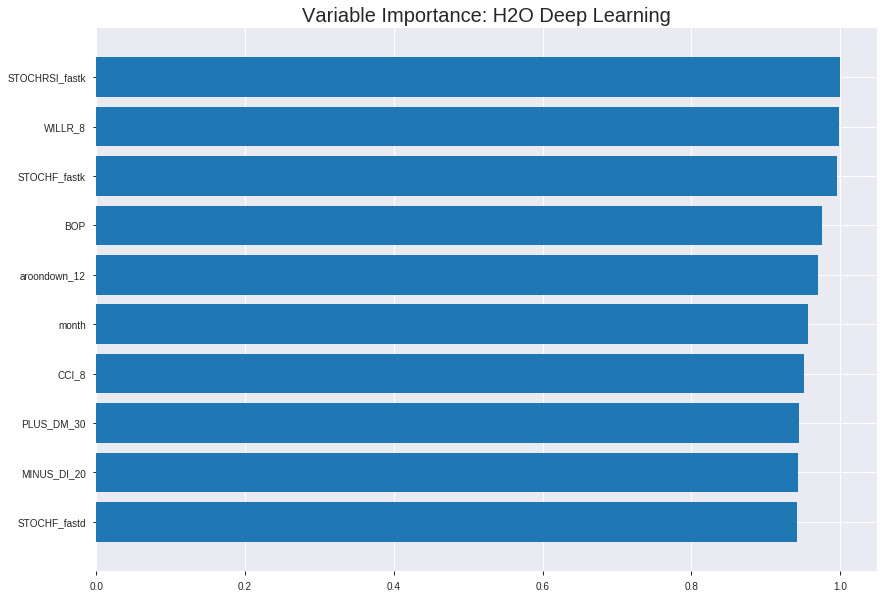

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_163031_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2503334027151027
RMSE: 0.5003332916317909
LogLoss: 0.693821836592022
Mean Per-Class Error: 0.4891138635297514
AUC: 0.5085694482390076
pr_auc: 0.20013729883940634
Gini: 0.017138896478015253
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4061764677097212: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      13   2059  0.9937   (2059.0/2072.0)
1      5    2242  0.0022   (5.0/2247.0)
Total  18   4301  0.4779   (2064.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.406176     0.684789   385
max f2                       0.390223     0.844356   398
max f0point5                 0.414688     0.576394   366
max accuracy                 0.475265     0.523269   169
max precision                0.500981     0.528597   39
max recall                   0.390223     1          398
max specificity              0.509346     0.39527    0
max absolute_mcc             0.406176     0.0313991  385
max min_per_class_accuracy   0.509346     0.39527    0
max mean_per_class_accuracy  0.500981     0.510886   39

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 49.52 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.611253                    0.509346           1.00984   1.00984            0.525379         0.509346  0.525379                    0.509346            0.617267        0.617267                   0.984022  0.984022
    2        0.699931                    0.494099           1.02379   1.01161            0.532637         0.501122  0.526298                    0.508304            0.0907877       0.708055                   2.37915   1.16078
    3        0.799954                    0.478911           0.987755  1.00863            0.513889         0.486648  0.524747                    0.505596            0.0987984       0.806854                   -1.22447  0.862536
    4        0.899977                    0.458464           0.965509  1.00383            0.502315         0.469908  0.522254                    0.50163             0.0965732       0.903427                   -3.44915  0.383337
    5        1                           0.387975           0.965509  1                  0.502315         0.437257  0.520259                    0.495191            0.0965732       1                          -3.44915  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24903433080140205
RMSE: 0.49903339647903533
LogLoss: 0.6912106278220921
Mean Per-Class Error: 0.45994629377097085
AUC: 0.5248601509765127
pr_auc: 0.2358295432121286
Gini: 0.04972030195302546
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4483715400847796: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      19   588   0.9687   (588.0/607.0)
1      7    620   0.0112   (7.0/627.0)
Total  26   1208  0.4822   (595.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.448372     0.675749   374
max f2                       0.433639     0.837794   393
max f0point5                 0.473288     0.574953   250
max accuracy                 0.484589     0.54376    158
max precision                0.484589     0.535556   158
max recall                   0.428197     1          399
max specificity              0.509346     0.461285   0
max absolute_mcc             0.473288     0.0981218  250
max min_per_class_accuracy   0.509346     0.461285   0
max mean_per_class_accuracy  0.484589     0.540054   158

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 49.59 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.54376                     0.509346           1.00898   1.00898            0.512668         0.509346  0.512668                    0.509346            0.548644        0.548644                   0.898229   0.898229
    2        0.599676                    0.501332           1.14093   1.02129            0.57971          0.504731  0.518919                    0.508915            0.0637959       0.61244                    14.0929    2.12854
    3        0.700162                    0.486979           1.20626   1.04783            0.612903         0.494068  0.532407                    0.506784            0.121212        0.733652                   20.6256    4.78321
    4        0.799838                    0.478359           0.992051  1.04088            0.504065         0.483137  0.528875                    0.503837            0.0988836       0.832536                   -0.794855  4.08807
    5        0.899514                    0.467163           0.928048  1.02838            0.471545         0.47253   0.522523                    0.500368            0.092504        0.92504                    -7.19519   2.83777
    6        1                           0.428197           0.745974  1                  0.379032         0.455954  0.508104                    0.495905            0.0749601       1                          -25.4026   0


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:11:15  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 17:11:19  10 min  9.459 sec  159 obs/sec       0.122251  1             528        0.656429         3.07984             -0.726431      0.506439        0.527735           1.00474          0.479741                         0.652228           2.91971               -0.70205         0.539129          0.543305             1.21114            0.491896
    2019-08-24 17:12:35  11 min 25.787 sec  251 obs/sec       4.21162   33            18190      0.500329         0.693826            -0.00296266    0.50671         0.528203           1.17948          0.479741                         0.500312           0.693771              -0.0015125       0.525961          0.541953             1.51392            0.491896
    2019-08-24 17:13:49  12 min 39.065 sec  319 obs/sec       10.2359   80            44209      0.499594         0.692335            -1.78541e-05   0.5             0                  1                0.479741                         0.500035           0.693218              -0.000403684     0.5               0                    1                  0.491896
    2019-08-24 17:15:03  13 min 52.653 sec  381 obs/sec       18.0873   141           78119      0.500363         0.693873            -0.00309884    0.5             0                  1                0.479741                         0.500179           0.693506              -0.000980592     0.5               0                    1                  0.491896
    2019-08-24 17:16:14  15 min  4.860 sec  459 obs/sec       28.671    224           123830     0.500333         0.693822            -0.00298026    0.508569        0.200137           1.00984          0.477888                         0.499033           0.691211              0.00360094       0.52486           0.23583              1.00898            0.482172
    2019-08-24 17:17:28  16 min 18.764 sec  533 obs/sec       41.5098   325           179281     0.501344         0.69584             -0.0070356     0.5             0                  1                0.479741                         0.500819           0.694787              -0.00354099      0.5               0                    1                  0.491896
    2019-08-24 17:18:42  17 min 32.231 sec  603 obs/sec       56.1852   440           242664     0.499832         0.692811            -0.000971367   0.5             0                  1                0.479741                         0.499946           0.693039              -4.66609e-05     0.5               0                    1                  0.491896
    2019-08-24 17:18:49  17 min 39.666 sec  603 obs/sec       56.1852   440           242664     0.500333         0.693822            -0.00298026    0.508569        0.200137           1.00984          0.477888                         0.499033           0.691211              0.00360094       0.52486           0.23583              1.00898            0.482172

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  ---------------------
STOCHRSI_fastk       1.0                    1.0                  0.001298315887977643
WILLR_8              0.9990097284317017     0.9990097284317017   0.0012970302026671088
STOCHF_fastk         0.9951599836349487     0.9951599836349487   0.001292032017832825
BOP                  0.9762024879455566     0.9762024879455566   0.0012674191999830198
aroondown_12         0.9704701900482178     0.9704701900482178   0.0012599768665482838
---                  ---                    ---                  ---
CDLHIKKAKEMOD        0.6074821352958679     0.6074821352958679   0.0007887037079172094
CDLLADDERBOTTOM      0.592980682849884      0.592980682849884    0.0007698762418078363
CDL3LINESTRIKE       0.5905637741088867     0.5905637741088867   0.0007667383307896075
CDLXSIDEGAP3METHODS  0.5903359055519104     0.5903359055519104   0.0007664424854217145
CDLTASUKIGAP         0.5687079429626465     0.5687079429626465   0.0007383625579674871


See the whole table with table.as_data_frame()


('accuracy', 0.5494327390599676)

('F1', 0.6951871657754012)

('auc', 0.5442624333270086)

('logloss', 0.6987532282896882)

('mean_per_class_error', 0.4442055109312082)

('rmse', 0.5027781726022428)

('mse', 0.2527858908452506)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


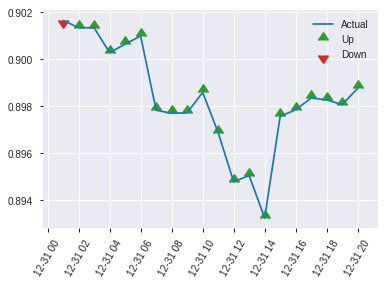


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2527858908452506
RMSE: 0.5027781726022428
LogLoss: 0.6987532282896882
Mean Per-Class Error: 0.4442055109312082
AUC: 0.5442624333270086
pr_auc: 0.5327844857748207
Gini: 0.08852486665401726
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3978902883471789: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    284  0.9759   (284.0/291.0)
1      1    325  0.0031   (1.0/326.0)
Total  8    609  0.4619   (285.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.39789      0.695187  391
max f2                       0.39789      0.849451  391
max f0point5                 0.412983     0.592863  361
max accuracy                 0.412983     0.549433  361
max precision                0.470276     0.61165   118
max recall                   0.392269     1         397
max specificity              0.509346     0.958763  0
max absolute_mcc             0.470276     0.11812   118
max min_per_class_accuracy   0.458632     0.530675  181
max mean_per_class_accuracy  0.470276     0.555794  118

Gains/Lift Table: Avg response rate: 52.84 %, avg score: 45.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0453809                   0.509346           1.08151   1.08151            0.571429         0.509346  0.571429                    0.509346            0.0490798       0.0490798                  8.15074   8.15074
    2        0.0502431                   0.508622           1.26176   1.09895            0.666667         0.508926  0.580645                    0.509305            0.00613497      0.0552147                  26.1759   9.89511
    3        0.100486                    0.498402           1.0379    1.06842            0.548387         0.503815  0.564516                    0.50656             0.0521472       0.107362                   3.78983   6.84247
    4        0.150729                    0.488418           1.16      1.09895            0.612903         0.49222   0.580645                    0.50178             0.0582822       0.165644                   16.0004   9.89511
    5        0.200972                    0.485033           1.09895   1.09895            0.580645         0.486538  0.580645                    0.49797             0.0552147       0.220859                   9.89511   9.89511
    6        0.299838                    0.472484           1.17902   1.12535            0.622951         0.479119  0.594595                    0.491754            0.116564        0.337423                   17.902    12.5352
    7        0.400324                    0.465776           0.976845  1.08808            0.516129         0.469009  0.574899                    0.486045            0.0981595       0.435583                   -2.31546  8.80753
    8        0.50081                     0.458449           0.946319  1.05963            0.5              0.461914  0.559871                    0.481203            0.095092        0.530675                   -5.3681   5.96323
    9        0.599676                    0.452573           0.868752  1.02816            0.459016         0.455604  0.543243                    0.476982            0.0858896       0.616564                   -13.1248  2.81628
    10       0.700162                    0.444353           1.06842   1.03394            0.564516         0.448388  0.546296                    0.472879            0.107362        0.723926                   6.84247   3.39411
    11       0.799028                    0.434489           0.899779  1.01734            0.47541          0.439274  0.537525                    0.468721            0.0889571       0.812883                   -10.0221  1.73409
    12       0.899514                    0.416305           1.0379    1.01964            0.548387         0.425409  0.538739                    0.463882            0.104294        0.917178                   3.78983   1.96374
    13       1                           0.387818           0.824213  1                  0.435484         0.406888  0.528363                    0.458155            0.0828221       1                          -17.5787  0

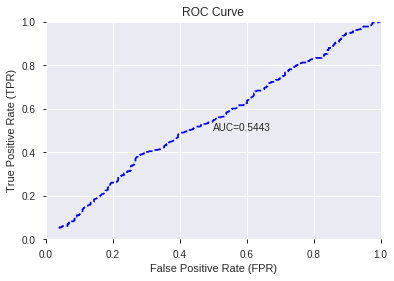

This function is available for GLM models only


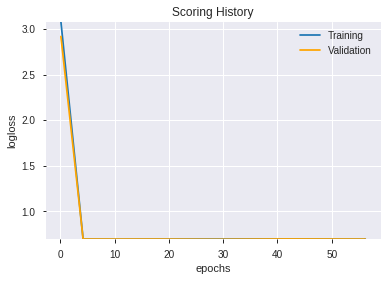

--2019-08-24 17:19:07--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  35.3MB/s    in 10s     

2019-08-24 17:19:18 (33.5 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_163031_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_163031_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_a612',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190824_171933  0.564138  0.730299              0.481896  0.515672  0.265918
1  DeepLearning_grid_1_AutoML_20190824_171933_model_3  0.548041  0.729619              0.480731  0.513912  0.264106
2  DeepLearning_grid_1_AutoML_20190824_171933_model_2  0.546676  1.086419              0.492389  0.592232  0.350739
3  DeepLearning_grid_1_AutoML_20190824_171933_model_9  0.545780  0.689856              0.485147  0.498343  0.248346
4  DeepLearning_grid_1_AutoML_20190824_171933_model_6  0.544826  0.702492              0.488953  0.503586  0.253599
5  DeepLearning_grid_1_AutoML_20190824_171933_model_1  0.540057  0.853682              0.500000  0.545834  0.297935
6  DeepLearning_grid_1_AutoML_20190824_171933_model_5  0.536836  0.714621              0.494845  0.507749  0.257810
7  DeepLearning_grid_1_AutoML_20190824_171933_model_8  0.523170  0.691910              0.500000  0.499381  0.249382
8  DeepLearning_grid_1_AutoML_20190824_171933_model_7  0.522331  0.702020              0.489322  0.504388  0.254407
9  DeepLearning_grid_1_AutoML_20190824_171933_model_4  0.521778  0.740523              0.500000  0.519244  0.269614

variable  relative_importance  scaled_importance  percentage
0               DX_30             1.000000           1.000000    0.032209
1         STOCH_slowd             0.871944           0.871944    0.028085
2             NATR_30             0.820284           0.820284    0.026421
3          aroonup_24             0.805816           0.805816    0.025955
4              ULTOSC             0.782457           0.782457    0.025202
5            WILLR_24             0.781089           0.781089    0.025158
6            WILLR_14             0.763719           0.763719    0.024599
7              SAREXT             0.753854           0.753854    0.024281
8               CMO_8             0.734058           0.734058    0.023644
9        STOCHF_fastd             0.726404           0.726404    0.023397
10            CDLDOJI             0.723421           0.723421    0.023301
11       aroondown_30             0.716086           0.716086    0.023065
12              DX_12             0.711350           0.711350    0.022912
13              month             0.709389           0.709389    0.022849
14        MINUS_DI_12             0.704682           0.704682    0.022697
15              CCI_8             0.700932           0.700932    0.022577
16          dayofyear             0.681710           0.681710    0.021957
17         PLUS_DI_14             0.680997           0.680997    0.021934
18       aroondown_12             0.656654           0.656654    0.021150
19          dayofweek             0.649666           0.649666    0.020925
20         aroonup_30             0.644236           0.644236    0.020750
21       aroondown_20             0.634915           0.634915    0.020450
22        AROONOSC_20             0.634073           0.634073    0.020423
23        MINUS_DI_20             0.623627           0.623627    0.020087
24       weekday_name             0.621105           0.621105    0.020005
25       HT_TRENDMODE             0.611966           0.611966    0.019711
26         PLUS_DI_24             0.602142           0.602142    0.019395
27        AROONOSC_14             0.601695           0.601695    0.019380
28        MINUS_DI_24             0.593237           0.593237    0.019108
29              ATR_8             0.589195           0.589195    0.018978
30               hour             0.583832           0.583832    0.018805
31                BOP             0.563407           0.563407    0.018147
32         PLUS_DM_24             0.563246           0.563246    0.018142
33        STOCH_slowk             0.556177           0.556177    0.017914
34        AROONOSC_12             0.538126           0.538126    0.017333
35     STOCHRSI_fastk             0.532873           0.532873    0.017164
36           WILLR_12             0.525115           0.525115    0.016914
37         PLUS_DM_30             0.518681           0.518681    0.016706
38      days_in_month             0.512853           0.512853    0.016519
39       STOCHF_fastk             0.500535           0.500535    0.016122
40       aroondown_14             0.496590           0.496590    0.015995
41               week             0.489309           0.489309    0.015760
42            WILLR_8             0.483734           0.483734    0.015581
43        aroondown_8             0.482251           0.482251    0.015533
44        AROONOSC_30             0.465224           0.465224    0.014985
45  MACDFIX_signal_14             0.463180           0.463180    0.014919
46         PLUS_DI_30             0.459025           0.459025    0.014785
47             CCI_24             0.452480           0.452480    0.014574
48          aroonup_8             0.410794           0.410794    0.013231
49         aroonup_20             0.318734           0.318734    0.010266

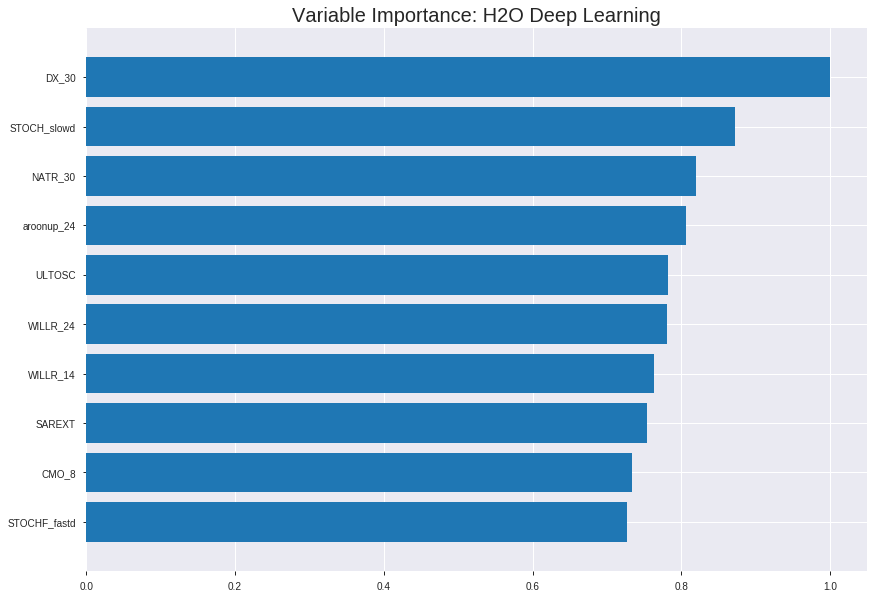

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190824_171933


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24895112616497286
RMSE: 0.4989500237147733
LogLoss: 0.6917896524368674
Mean Per-Class Error: 0.4395643139802018
AUC: 0.5808746711617205
pr_auc: 0.6093870440685819
Gini: 0.16174934232344107
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1808655249492125: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      23   2049  0.9889   (2049.0/2072.0)
1      7    2240  0.0031   (7.0/2247.0)
Total  30   4289  0.476    (2056.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.180866     0.685435  386
max f2                       0.140745     0.844297  396
max f0point5                 0.387105     0.585035  280
max accuracy                 0.53486      0.557536  172
max precision                0.947271     1         0
max recall                   0.115869     1         399
max specificity              0.947271     1         0
max absolute_mcc             0.621558     0.132902  104
max min_per_class_accuracy   0.517641     0.551641  184
max mean_per_class_accuracy  0.553091     0.560436  157

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 50.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.765094           1.7037    1.7037             0.886364         0.829693  0.886364                    0.829693            0.0173565       0.0173565                  70.3696   70.3696
    2        0.0201436                   0.728466           1.60922   1.657              0.837209         0.745434  0.862069                    0.788048            0.0160214       0.0333778                  60.9215   65.6999
    3        0.0300996                   0.713415           1.34101   1.55248            0.697674         0.720434  0.807692                    0.765683            0.0133511       0.046729                   34.1013   55.248
    4        0.0400556                   0.701759           1.07281   1.43326            0.55814          0.707294  0.745665                    0.751171            0.0106809       0.0574099                  7.28103   43.3256
    5        0.0500116                   0.691289           1.34101   1.41489            0.697674         0.696305  0.736111                    0.740248            0.0133511       0.070761                   34.1013   41.4893
    6        0.100023                    0.661294           1.23692   1.32591            0.643519         0.673959  0.689815                    0.707104            0.0618603       0.132621                   23.6919   32.5906
    7        0.150035                    0.640903           1.17463   1.27548            0.611111         0.651618  0.66358                     0.688608            0.058745        0.191366                   17.4628   27.548
    8        0.200046                    0.623641           1.17463   1.25027            0.611111         0.632912  0.650463                    0.674684            0.058745        0.250111                   17.4628   25.0267
    9        0.300069                    0.590553           1.04115   1.18056            0.541667         0.60632   0.614198                    0.651896            0.104139        0.35425                    4.11475   18.056
    10       0.400093                    0.557935           1.0189    1.14015            0.530093         0.575076  0.593171                    0.632691            0.101914        0.456164                   1.89007   14.0145
    11       0.500116                    0.518545           0.95216   1.10255            0.49537          0.538683  0.573611                    0.61389             0.0952381       0.551402                   -4.78395  10.2548
    12       0.599907                    0.472058           0.923152  1.07271            0.480278         0.495907  0.558086                    0.594264            0.0921228       0.643525                   -7.6848   7.27067
    13       0.699931                    0.425441           0.947711  1.05484            0.493056         0.448313  0.548793                    0.573407            0.0947931       0.738318                   -5.22889  5.48443
    14       0.799954                    0.372445           0.974407  1.04479            0.506944         0.398852  0.54356                     0.551581            0.0974633       0.835781                   -2.55928  4.47868
    15       0.899977                    0.316435           0.840927  1.02213            0.4375           0.345241  0.531773                    0.528648            0.0841121       0.919893                   -15.9073  2.21298
    16       1                           0.114858           0.800883  1                  0.416667         0.258277  0.520259                    0.501605            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2610884079991239
RMSE: 0.5109681085930158
LogLoss: 0.7185717396776845
Mean Per-Class Error: 0.4558552664422777
AUC: 0.5499331299643447
pr_auc: 0.5467403365724772
Gini: 0.09986625992868947
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21358356313882138: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      18   589   0.9703   (589.0/607.0)
1      3    624   0.0048   (3.0/627.0)
Total  21   1213  0.4797   (592.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.213584     0.678261   386
max f2                       0.209543     0.838926   388
max f0point5                 0.327513     0.573949   309
max accuracy                 0.450474     0.545381   226
max precision                0.919619     1          0
max recall                   0.173746     1          396
max specificity              0.919619     1          0
max absolute_mcc             0.213584     0.0961286  386
max min_per_class_accuracy   0.494909     0.533773   196
max mean_per_class_accuracy  0.450474     0.544145   226

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 49.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.797856           1.36253   1.36253            0.692308         0.837113  0.692308                    0.837113            0.0143541       0.0143541                  36.2532   36.2532
    2        0.0202593                   0.764375           1.31207   1.33831            0.666667         0.780364  0.68                        0.809874            0.0127592       0.0271132                  31.2068   33.8309
    3        0.0299838                   0.744087           0.820043  1.17022            0.416667         0.752181  0.594595                    0.791163            0.00797448      0.0350877                  -17.9957  17.0223
    4        0.0405186                   0.734524           0.756962  1.06278            0.384615         0.739522  0.54                        0.777736            0.00797448      0.0430622                  -24.3038  6.27751
    5        0.0502431                   0.725011           1.47608   1.14277            0.75             0.729868  0.580645                    0.768471            0.0143541       0.0574163                  47.6077   14.2769
    6        0.100486                    0.694677           1.07928   1.11103            0.548387         0.707319  0.564516                    0.737895            0.0542265       0.111643                   7.92818   11.1025
    7        0.149919                    0.667724           1.06471   1.09575            0.540984         0.680591  0.556757                    0.719               0.0526316       0.164274                   6.4711    9.57541
    8        0.200162                    0.645047           0.952307  1.05975            0.483871         0.658094  0.538462                    0.703712            0.0478469       0.212121                   -4.76925  5.97473
    9        0.299838                    0.608176           1.13606   1.08512            0.577236         0.626274  0.551351                    0.677969            0.113238        0.325359                   13.6059   8.51157
    10       0.400324                    0.554867           1.09515   1.08764            0.556452         0.582685  0.552632                    0.654052            0.110048        0.435407                   9.51536   8.76354
    11       0.5                         0.494616           0.976051  1.06539            0.495935         0.522944  0.541329                    0.627915            0.0972887       0.532695                   -2.39494  6.53907
    12       0.599676                    0.439394           1.02405   1.05852            0.520325         0.463617  0.537838                    0.600606            0.102073        0.634769                   2.40531   5.85198
    13       0.700162                    0.382185           0.968179  1.04555            0.491935         0.413748  0.53125                     0.573788            0.0972887       0.732057                   -3.18208  4.55542
    14       0.799838                    0.328133           1.04005   1.04487            0.528455         0.354797  0.530902                    0.546498            0.103668        0.835726                   4.00539   4.48688
    15       0.899514                    0.26864            0.784041  1.01597            0.398374         0.30037   0.516216                    0.519224            0.0781499       0.913876                   -21.5959  1.59662
    16       1                           0.104634           0.857077  1                  0.435484         0.234985  0.508104                    0.490662         


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:19:34  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 17:19:34  0.173 sec   51416 obs/sec     1         1             4319       0.513486         0.724874            -0.0564069     0.528851        0.543354           1.35422          0.479741                         0.518201           0.736339              -0.0744118       0.533252          0.535609             1.21114            0.479741
    2019-08-24 17:19:35  0.627 sec   88868 obs/sec     10        10            43190      0.49895          0.69179             0.00255793     0.580875        0.609387           1.7037           0.476036                         0.510968           0.718572              -0.044628        0.549933          0.54674              1.36253            0.479741

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  --------------------
DX_30              1.0                    1.0                  0.03220936554506411
STOCH_slowd        0.8719438910484314     0.8719438910484314   0.028084759521564476
NATR_30            0.8202840089797974     0.8202840089797974   0.026420827496000943
aroonup_24         0.805815577507019      0.805815577507019    0.025954808497830512
ULTOSC             0.7824574708938599     0.7824574708938599   0.02520245870348669
---                ---                    ---                  ---
MACDFIX_signal_14  0.46318018436431885    0.46318018436431885  0.014918739871420532
PLUS_DI_30         0.4590245485305786     0.4590245485305786   0.014784889477779426
CCI_24             0.4524803161621094     0.4524803161621094   0.01457410390521156
aroonup_8          0.41079437732696533    0.41079437732696533  0.01323142626318122
aroonup_20         0.31873372197151184    0.31873372197151184  0.010266210962519257


See the whole table with table.as_data_frame()


('accuracy', 0.5688816855753647)

('F1', 0.6955579631635969)

('auc', 0.5641378365273122)

('logloss', 0.7302989882841973)

('mean_per_class_error', 0.43841313009929794)

('rmse', 0.5156720620392166)

('mse', 0.26591767556777757)

deeplearning prediction progress: |███████████████████████████████████████| 100%


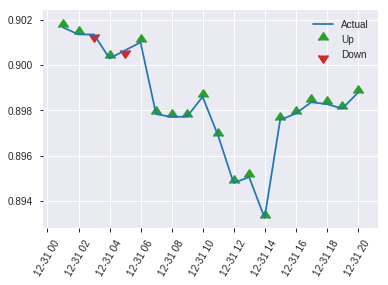


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.26591767556777757
RMSE: 0.5156720620392166
LogLoss: 0.7302989882841973
Mean Per-Class Error: 0.43841313009929794
AUC: 0.5641378365273122
pr_auc: 0.5934698916826943
Gini: 0.1282756730546244
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18673666112343798: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   276  0.9485   (276.0/291.0)
1      5    321  0.0153   (5.0/326.0)
Total  20   597  0.4554   (281.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.186737     0.695558  380
max f2                       0.0981701    0.849844  396
max f0point5                 0.34334      0.596501  252
max accuracy                 0.34334      0.568882  252
max precision                0.843193     1         0
max recall                   0.0981701    1         396
max specificity              0.843193     1         0
max absolute_mcc             0.658337     0.134749  30
max min_per_class_accuracy   0.396478     0.546392  208
max mean_per_class_accuracy  0.34334      0.561587  252

Gains/Lift Table: Avg response rate: 52.84 %, avg score: 41.98 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.711764           1.62226   1.62226            0.857143         0.760445  0.857143                    0.760445            0.0184049       0.0184049                  62.2261   62.2261
    2        0.0210697                   0.69573            1.26176   1.45588            0.666667         0.7012    0.769231                    0.733101            0.0122699       0.0306748                  26.1759   45.5875
    3        0.0307942                   0.684854           0.630879  1.19535            0.333333         0.689189  0.631579                    0.719234            0.00613497      0.0368098                  -36.9121  19.535
    4        0.0405186                   0.679378           1.89264   1.3627             1                0.682856  0.72                        0.710504            0.0184049       0.0552147                  89.2638   36.2699
    5        0.0502431                   0.671707           1.5772    1.40422            0.833333         0.676418  0.741935                    0.703906            0.0153374       0.0705521                  57.7198   40.4215
    6        0.100486                    0.636137           1.0379    1.22106            0.548387         0.65184   0.645161                    0.677873            0.0521472       0.122699                   3.78983   22.1057
    7        0.150729                    0.601139           1.34316   1.26176            0.709677         0.618324  0.666667                    0.658024            0.0674847       0.190184                   34.3162   26.1759
    8        0.200972                    0.567523           1.0379    1.20579            0.548387         0.583538  0.637097                    0.639402            0.0521472       0.242331                   3.78983   20.5794
    9        0.299838                    0.51541            0.713618  1.04351            0.377049         0.539796  0.551351                    0.606559            0.0705521       0.312883                   -28.6382  4.35085
    10       0.400324                    0.446845           1.12948   1.06509            0.596774         0.48308   0.562753                    0.575564            0.113497        0.42638                    12.9478   6.50878
    11       0.50081                     0.398153           1.19053   1.09026            0.629032         0.424377  0.576052                    0.545229            0.119632        0.546012                   19.053    9.02575
    12       0.599676                    0.355729           0.961832  1.06908            0.508197         0.376344  0.564865                    0.517386            0.095092        0.641104                   -3.81676  6.90847
    13       0.700162                    0.318767           1.06842   1.06899            0.564516         0.336501  0.564815                    0.491425            0.107362        0.748466                   6.84247   6.899
    14       0.799028                    0.285408           0.868752  1.04421            0.459016         0.302237  0.551724                    0.468017            0.0858896       0.834356                   -13.1248  4.42141
    15       0.899514                    0.241049           0.85474   1.02305            0.451613         0.265404  0.540541                    0.445382            0.0858896       0.920245                   -14.526   2.30476
    16       1                           0.0336142          0.793687  1                  0.419355         0.191279  0.528363                    0.419849            

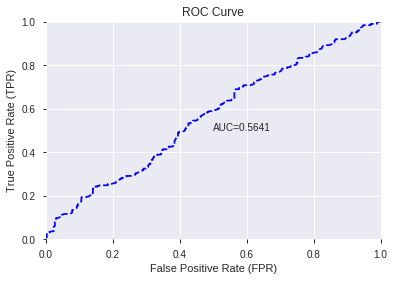

This function is available for GLM models only


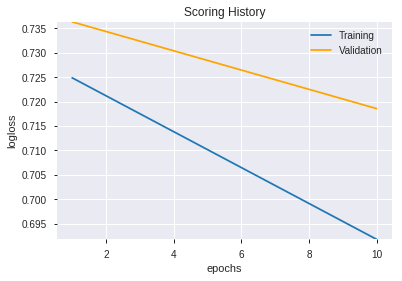

--2019-08-24 17:33:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.9.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.9.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190824_171933',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190824_171933',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_a612',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_10_sid_a612'

['DX_30',
 'STOCH_slowd',
 'NATR_30',
 'aroonup_24',
 'ULTOSC',
 'WILLR_24',
 'WILLR_14',
 'SAREXT',
 'CMO_8',
 'STOCHF_fastd',
 'CDLDOJI',
 'aroondown_30',
 'DX_12',
 'month',
 'MINUS_DI_12',
 'CCI_8',
 'dayofyear',
 'PLUS_DI_14',
 'aroondown_12',
 'dayofweek',
 'aroonup_30',
 'aroondown_20',
 'AROONOSC_20',
 'MINUS_DI_20',
 'weekday_name',
 'HT_TRENDMODE',
 'PLUS_DI_24',
 'AROONOSC_14',
 'MINUS_DI_24',
 'ATR_8',
 'hour',
 'BOP',
 'PLUS_DM_24',
 'STOCH_slowk',
 'AROONOSC_12',
 'STOCHRSI_fastk',
 'WILLR_12',
 'PLUS_DM_30',
 'days_in_month',
 'STOCHF_fastk',
 'aroondown_14',
 'week',
 'WILLR_8',
 'aroondown_8',
 'AROONOSC_30',
 'MACDFIX_signal_14',
 'PLUS_DI_30',
 'CCI_24',
 'aroonup_8',
 'aroonup_20']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_173338_model_1  0.547868  0.68831              0.496379  0.497583  0.247589

variable  relative_importance  scaled_importance  percentage
0                 BOP             0.025446           1.000000    0.065004
1        aroondown_14             0.021117           0.829891    0.053946
2             WILLR_8             0.020240           0.795400    0.051704
3        STOCHF_fastk             0.019676           0.773272    0.050266
4      STOCHRSI_fastk             0.018239           0.716784    0.046594
5         AROONOSC_14             0.017031           0.669315    0.043508
6              ULTOSC             0.016989           0.667646    0.043399
7         AROONOSC_12             0.016530           0.649606    0.042227
8              SAREXT             0.015052           0.591547    0.038453
9             CDLDOJI             0.014049           0.552126    0.035890
10       aroondown_12             0.012954           0.509068    0.033091
11              DX_12             0.012239           0.480969    0.031265
12      days_in_month             0.011305           0.444289    0.028880
13            NATR_30             0.009126           0.358633    0.023312
14        MINUS_DI_24             0.009122           0.358472    0.023302
15        STOCH_slowd             0.008979           0.352876    0.022938
16  MACDFIX_signal_14             0.007740           0.304178    0.019773
17          aroonup_8             0.007575           0.297694    0.019351
18       STOCHF_fastd             0.007543           0.296427    0.019269
19        STOCH_slowk             0.007526           0.295763    0.019226
20       HT_TRENDMODE             0.007477           0.293848    0.019101
21         aroonup_24             0.007120           0.279820    0.018189
22              ATR_8             0.007105           0.279235    0.018151
23        MINUS_DI_20             0.006963           0.273651    0.017788
24         PLUS_DM_24             0.006874           0.270163    0.017562
25               hour             0.006653           0.261464    0.016996
26         PLUS_DM_30             0.006549           0.257369    0.016730
27              CMO_8             0.005270           0.207107    0.013463
28           WILLR_24             0.004388           0.172461    0.011211
29              month             0.004193           0.164791    0.010712
30         PLUS_DI_14             0.004181           0.164314    0.010681
31        AROONOSC_30             0.004000           0.157202    0.010219
32              CCI_8             0.003971           0.156051    0.010144
33         aroonup_30             0.003950           0.155248    0.010092
34          dayofyear             0.003647           0.143315    0.009316
35               week             0.003590           0.141081    0.009171
36       weekday_name             0.003296           0.129543    0.008421
37       aroondown_20             0.003105           0.122031    0.007932
38       aroondown_30             0.003084           0.121216    0.007880
39           WILLR_14             0.002616           0.102804    0.006683
40         PLUS_DI_24             0.002520           0.099015    0.006436
41             CCI_24             0.002353           0.092471    0.006011
42          dayofweek             0.002309           0.090745    0.005899
43        MINUS_DI_12             0.001592           0.062550    0.004066
44           WILLR_12             0.001546           0.060772    0.003950
45        AROONOSC_20             0.001413           0.055512    0.003609
46              DX_30             0.001106           0.043459    0.002825
47         aroonup_20             0.000880           0.034597    0.002249
48         PLUS_DI_30             0.000871           0.034249    0.002226
49        aroondown_8             0.000348           0.013685    0.000890

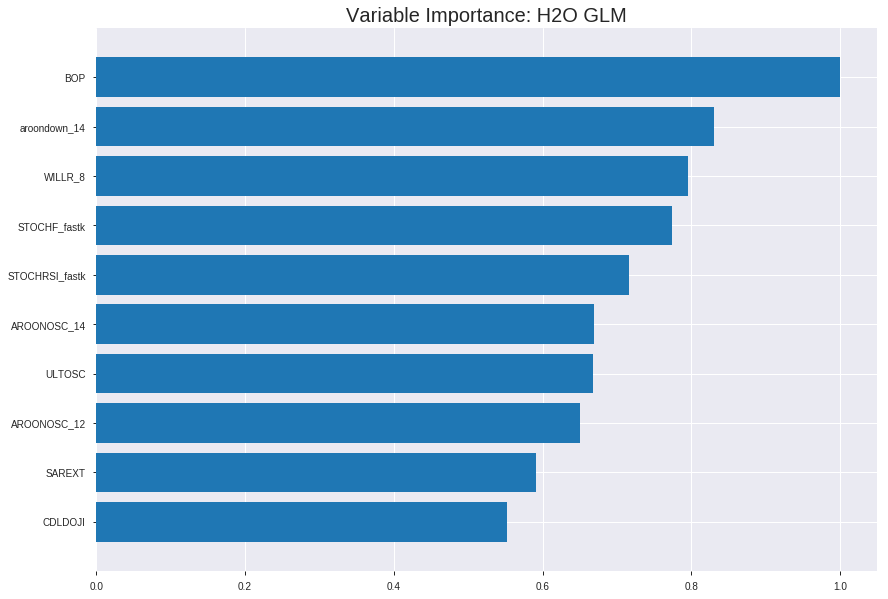

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_173338_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24762268477797073
RMSE: 0.4976170061181297
LogLoss: 0.6883783119204075
Null degrees of freedom: 4318
Residual degrees of freedom: 4268
Null deviance: 5980.312642429541
Residual deviance: 5946.2118583684805
AIC: 6048.2118583684805
AUC: 0.5566872303354279
pr_auc: 0.5668054450478214
Gini: 0.11337446067085577
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45468808470276706: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      16   2056  0.9923   (2056.0/2072.0)
1      6    2241  0.0027   (6.0/2247.0)
Total  22   4297  0.4774   (2062.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.454688     0.684902   389
max f2                       0.447862     0.844419   397
max f0point5                 0.492695     0.579104   298
max accuracy                 0.513383     0.54897    223
max precision                0.593431     1          0
max recall                   0.447862     1          397
max specificity              0.593431     1          0
max absolute_mcc             0.527765     0.0926231  168
max min_per_class_accuracy   0.521104     0.542471   193
max mean_per_class_accuracy  0.524263     0.545754   181

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 52.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.577193           1.31054   1.31054            0.681818         0.582036  0.681818                    0.582036            0.0133511       0.0133511                  31.0535   31.0535
    2        0.0201436                   0.572806           1.11751   1.21513            0.581395         0.574976  0.632184                    0.578546            0.0111259       0.0244771                  11.7511   21.5132
    3        0.0300996                   0.569481           1.07281   1.16806            0.55814          0.570813  0.607692                    0.575989            0.0106809       0.035158                   7.28103   16.8057
    4        0.0400556                   0.56695            1.25161   1.18882            0.651163         0.568046  0.618497                    0.574014            0.0124611       0.047619                   25.1612   18.8825
    5        0.0500116                   0.564378           1.07281   1.16573            0.55814          0.565722  0.606481                    0.572364            0.0106809       0.0583                     7.28103   16.5729
    6        0.100023                    0.555878           1.15683   1.16128            0.601852         0.560013  0.604167                    0.566189            0.0578549       0.116155                   15.6831   16.128
    7        0.150035                    0.549865           1.04115   1.12124            0.541667         0.552859  0.583333                    0.561745            0.0520694       0.168224                   4.11475   12.1236
    8        0.200046                    0.54492            1.13903   1.12569            0.592593         0.547432  0.585648                    0.558167            0.0569648       0.225189                   13.9033   12.5685
    9        0.300069                    0.537077           1.13013   1.12717            0.587963         0.540796  0.58642                     0.552377            0.11304         0.338229                   13.0134   12.7168
    10       0.400093                    0.528993           1.0011    1.09565            0.520833         0.532959  0.570023                    0.547522            0.100134        0.438362                   0.110332  9.5652
    11       0.500116                    0.521087           1.0278    1.08208            0.534722         0.525063  0.562963                    0.543031            0.102804        0.541166                   2.77994   8.20815
    12       0.599907                    0.512896           1.01235   1.07048            0.526682         0.517014  0.556928                    0.538703            0.101024        0.64219                    1.23454   7.04812
    13       0.699931                    0.504263           0.872072  1.04213            0.453704         0.508801  0.542177                    0.53443             0.0872274       0.729417                   -12.7928  4.21277
    14       0.799954                    0.495142           0.965509  1.03255            0.502315         0.499526  0.537192                    0.530066            0.0965732       0.82599                    -3.44915  3.25475
    15       0.899977                    0.48325            0.88542   1.0162             0.460648         0.489796  0.528685                    0.52559             0.0885625       0.914553                   -11.458   1.61959
    16       1                           0.4409             0.854275  1                  0.444444         0.472296  0.520259                    0.520259           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24874244918262345
RMSE: 0.4987408637585489
LogLoss: 0.6906237678503182
Null degrees of freedom: 1233
Residual degrees of freedom: 1183
Null deviance: 1711.0932050440474
Residual deviance: 1704.4594590545853
AIC: 1806.4594590545853
AUC: 0.5537627204149358
pr_auc: 0.5482612318951429
Gini: 0.10752544082987159
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4652803077689204: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    602   0.9918   (602.0/607.0)
1      1    626   0.0016   (1.0/627.0)
Total  6    1228  0.4887   (603.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46528      0.674933  394
max f2                       0.457593     0.838011  398
max f0point5                 0.51623      0.569462  250
max accuracy                 0.54362      0.547812  136
max precision                0.594572     1         0
max recall                   0.457593     1         398
max specificity              0.594572     1         0
max absolute_mcc             0.54362      0.106291  136
max min_per_class_accuracy   0.531375     0.537068  188
max mean_per_class_accuracy  0.54362      0.5504    136

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 52.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105348                   0.585437           1.05975   1.05975            0.538462         0.589773  0.538462                    0.589773            0.0111643       0.0111643                  5.97473    5.97473
    2        0.0202593                   0.579676           1.31207   1.18086            0.666667         0.58267   0.6                         0.586364            0.0127592       0.0239234                  31.2068    18.0861
    3        0.0299838                   0.575894           1.31207   1.22341            0.666667         0.578256  0.621622                    0.583734            0.0127592       0.0366826                  31.2068    22.3415
    4        0.0405186                   0.573296           1.05975   1.18086            0.538462         0.574576  0.6                         0.581353            0.0111643       0.0478469                  5.97473    18.0861
    5        0.0502431                   0.571523           0.820043  1.11103            0.416667         0.572401  0.564516                    0.57962             0.00797448      0.0558214                  -17.9957   11.1025
    6        0.100486                    0.564532           1.04754   1.07928            0.532258         0.567593  0.548387                    0.573607            0.0526316       0.108453                   4.75382    7.92818
    7        0.149919                    0.558577           1.22603   1.12767            0.622951         0.561116  0.572973                    0.569488            0.0606061       0.169059                   22.6031    12.7669
    8        0.200162                    0.55334            1.17451   1.13943            0.596774         0.55603   0.578947                    0.56611             0.0590112       0.22807                    17.4513    13.9428
    9        0.299838                    0.546153           1.13606   1.13831            0.577236         0.549643  0.578378                    0.560636            0.113238        0.341308                   13.6059    13.8308
    10       0.400324                    0.538841           1.03167   1.11154            0.524194         0.542684  0.564777                    0.55613             0.103668        0.444976                   3.16664    11.1539
    11       0.5                         0.531431           0.928048  1.07496            0.471545         0.535092  0.546191                    0.551936            0.092504        0.53748                    -7.19519   7.49601
    12       0.599676                    0.523631           0.992051  1.06118            0.504065         0.527395  0.539189                    0.547857            0.0988836       0.636364                   -0.794855  6.11794
    13       0.700162                    0.51448            1.03167   1.05694            0.524194         0.518763  0.537037                    0.543681            0.103668        0.740032                   3.16664    5.69437
    14       0.799838                    0.506313           0.848044  1.03091            0.430894         0.510243  0.52381                     0.539514            0.0845295       0.824561                   -15.1956   3.09106
    15       0.899514                    0.493462           0.784041  1.00355            0.398374         0.499288  0.50991                     0.535057            0.0781499       0.902711                   -21.5959   0.355475
    16       1                           0.454075           0.968179  1                  0.491935         0.4822    0.508104                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 17:33:39  0.000 sec   2            3.3       51            1.38156           1.38329
    2019-08-24 17:33:39  0.051 sec   4            2         51            1.38051           1.38252
    2019-08-24 17:33:39  0.093 sec   6            1.3       51            1.37932           1.38186
    2019-08-24 17:33:39  0.129 sec   8            0.78      51            1.37806           1.38142
    2019-08-24 17:33:39  0.166 sec   10           0.49      51            1.37676           1.38125
    2019-08-24 17:33:40  0.203 sec   12           0.3       51            1.37546           1.38135
    2019-08-24 17:33:40  0.236 sec   14           0.19      51            1.37418           1.38168
    2019-08-24 17:33:40  0.283 sec   16           0.12      51            1.37295           1.38215
    2019-08-24 17:33:40  0.328 sec   18           0.072     51            1.37181           1.38276
    2019-08-24 17:33:40  0.377 sec   20           0.045     51            1.37079           1.38352

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5575364667747164)

('F1', 0.6922257720979765)

('auc', 0.5478675183943669)

('logloss', 0.6883096790735302)

('mean_per_class_error', 0.4507305040794384)

('rmse', 0.4975834234583104)

('mse', 0.24758926330049225)

glm prediction progress: |████████████████████████████████████████████████| 100%


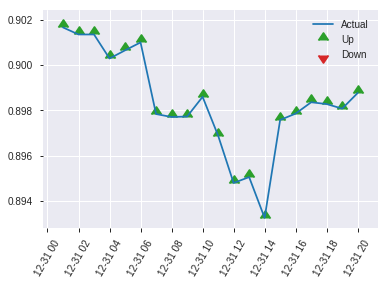


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24758926330049225
RMSE: 0.4975834234583104
LogLoss: 0.6883096790735302
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 853.5195608018752
Residual deviance: 849.3741439767363
AIC: 951.3741439767363
AUC: 0.5478675183943669
pr_auc: 0.5637639022501827
Gini: 0.09573503678873374
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4683321608949044: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    288  0.9897   (288.0/291.0)
1      1    325  0.0031   (1.0/326.0)
Total  4    613  0.4684   (289.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468332     0.692226  395
max f2                       0.458469     0.848958  398
max f0point5                 0.491535     0.596348  353
max accuracy                 0.498173     0.557536  330
max precision                0.601721     1         0
max recall                   0.458469     1         398
max specificity              0.601721     1         0
max absolute_mcc             0.491535     0.114624  353
max min_per_class_accuracy   0.529295     0.546392  204
max mean_per_class_accuracy  0.529178     0.549269  205

Gains/Lift Table: Avg response rate: 52.84 %, avg score: 52.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.588504           1.08151   1.08151            0.571429         0.592659  0.571429                    0.592659            0.0122699       0.0122699                  8.15074   8.15074
    2        0.0210697                   0.582619           1.26176   1.1647             0.666667         0.585138  0.615385                    0.589188            0.0122699       0.0245399                  26.1759   16.47
    3        0.0307942                   0.579642           0.946319  1.09574            0.5              0.580877  0.578947                    0.586563            0.00920245      0.0337423                  -5.3681   9.57378
    4        0.0405186                   0.576674           1.26176   1.13558            0.666667         0.578305  0.6                         0.584581            0.0122699       0.0460123                  26.1759   13.5583
    5        0.0502431                   0.575004           1.26176   1.16               0.666667         0.575816  0.612903                    0.582885            0.0122699       0.0582822                  26.1759   16.0004
    6        0.100486                    0.566844           1.0379    1.09895            0.548387         0.570405  0.580645                    0.576645            0.0521472       0.110429                   3.78983   9.89511
    7        0.150729                    0.560669           1.0379    1.0786             0.548387         0.563904  0.569892                    0.572398            0.0521472       0.162577                   3.78983   7.86002
    8        0.200972                    0.554642           1.22106   1.11421            0.645161         0.557022  0.58871                     0.568554            0.0613497       0.223926                   22.1057   11.4214
    9        0.299838                    0.54589            1.05491   1.09466            0.557377         0.549585  0.578378                    0.562299            0.104294        0.328221                   5.4913    9.46609
    10       0.400324                    0.537379           1.0379    1.08041            0.548387         0.541652  0.57085                     0.557116            0.104294        0.432515                   3.78983   8.04128
    11       0.50081                     0.529316           1.09895   1.08413            0.580645         0.533334  0.572816                    0.552345            0.110429        0.542945                   9.89511   8.41325
    12       0.599676                    0.520001           0.961832  1.06397            0.508197         0.525004  0.562162                    0.547837            0.095092        0.638037                   -3.81676  6.39695
    13       0.700162                    0.511346           0.793687  1.02518            0.419355         0.515305  0.541667                    0.543168            0.0797546       0.717791                   -20.6313  2.51789
    14       0.799028                    0.503221           0.992859  1.02118            0.52459          0.507026  0.539554                    0.538696            0.0981595       0.815951                   -0.71407  2.118
    15       0.899514                    0.492417           1.12948   1.03328            0.596774         0.498096  0.545946                    0.534161            0.113497        0.929448                   12.9478   3.32781
    16       1                           0.455365           0.702108  1                  0.370968         0.482651  0.528363                    0.528985            0

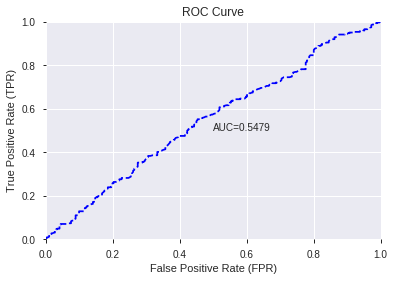

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


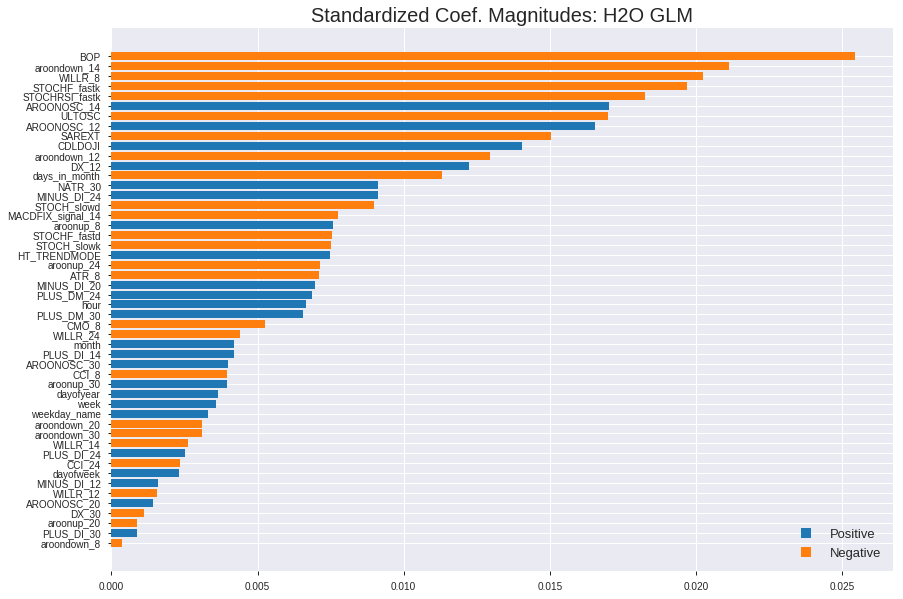

'log_likelihood'
--2019-08-24 17:33:46--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.0.200
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.0.200|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_173338_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_173338_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_a612',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'aroondown_14',
 'WILLR_8',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'AROONOSC_14',
 'ULTOSC',
 'AROONOSC_12',
 'SAREXT',
 'CDLDOJI',
 'aroondown_12',
 'DX_12',
 'days_in_month',
 'NATR_30',
 'MINUS_DI_24',
 'STOCH_slowd',
 'MACDFIX_signal_14',
 'aroonup_8',
 'STOCHF_fastd',
 'STOCH_slowk',
 'HT_TRENDMODE',
 'aroonup_24',
 'ATR_8',
 'MINUS_DI_20',
 'PLUS_DM_24',
 'hour',
 'PLUS_DM_30',
 'CMO_8',
 'WILLR_24',
 'month',
 'PLUS_DI_14',
 'AROONOSC_30',
 'CCI_8',
 'aroonup_30',
 'dayofyear',
 'week',
 'weekday_name',
 'aroondown_20',
 'aroondown_30',
 'WILLR_14',
 'PLUS_DI_24',
 'CCI_24',
 'dayofweek',
 'MINUS_DI_12',
 'WILLR_12',
 'AROONOSC_20',
 'DX_30',
 'aroonup_20',
 'PLUS_DI_30',
 'aroondown_8']

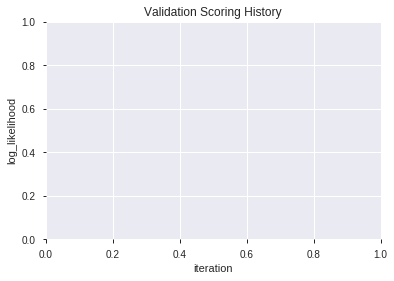

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |Local server has died unexpectedly. RIP.
Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpgohodgwr
  JVM stdout: /tmp/tmpgohodgwr/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpgohodgwr/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 5 days
H2O cluster name:           H2O_from_python_unknownUser_x1oukd
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_173422_model_2  0.581304  0.681308              0.498282  0.494191  0.244225
1  XGBoost_grid_1_AutoML_20190824_173422_model_3  0.576171  0.681214              0.489691  0.494175  0.244209
2               XGBoost_3_AutoML_20190824_173422  0.564628  0.682448              0.486070  0.494846  0.244872
3               XGBoost_1_AutoML_20190824_173422  0.561766  0.687398              0.478275  0.497262  0.247269
4  XGBoost_grid_1_AutoML_20190824_173422_model_4  0.559732  0.685180              0.491040  0.496120  0.246135
5  XGBoost_grid_1_AutoML_20190824_173422_model_5  0.556469  0.696292              0.481342  0.501422  0.251424
6  XGBoost_grid_1_AutoML_20190824_173422_model_1  0.555974  0.683539              0.489322  0.495415  0.245436
7               XGBoost_2_AutoML_20190824_173422  0.554387  0.688162              0.494845  0.497647  0.247652
8  XGBoost_grid_1_AutoML_20190824_173422_model_7  0.548279  0.692535              0.482080  0.499784  0.249784
9  XGBoost_grid_1_AutoML_20190824_173422_model_6  0.544099  0.686302              0.479993  0.496683  0.246694

variable  relative_importance  scaled_importance  percentage
0                hour           405.774445           1.000000    0.058119
1                 BOP           357.511597           0.881060    0.051206
2              SAREXT           317.968231           0.783608    0.045542
3               ATR_8           299.990051           0.739302    0.042967
4           dayofyear           258.151398           0.636194    0.036975
5               DX_30           243.350555           0.599719    0.034855
6              ULTOSC           243.204300           0.599358    0.034834
7        STOCHF_fastk           232.039413           0.571843    0.033235
8         STOCH_slowd           231.645432           0.570872    0.033178
9             WILLR_8           217.902252           0.537003    0.031210
10              CCI_8           205.765411           0.507093    0.029472
11     STOCHRSI_fastk           205.463776           0.506350    0.029428
12           WILLR_12           204.842346           0.504818    0.029339
13            NATR_30           201.575333           0.496767    0.028872
14  MACDFIX_signal_14           197.835754           0.487551    0.028336
15         PLUS_DM_24           173.805756           0.428331    0.024894
16              DX_12           170.898575           0.421166    0.024478
17        STOCH_slowk           159.509628           0.393099    0.022846
18         PLUS_DI_14           157.480087           0.388098    0.022556
19        AROONOSC_30           156.429916           0.385510    0.022405
20           WILLR_14           154.843613           0.381600    0.022178
21        AROONOSC_14           151.256653           0.372760    0.021664
22         PLUS_DM_30           148.793549           0.366690    0.021312
23        MINUS_DI_24           135.588135           0.334147    0.019420
24           WILLR_24           122.898773           0.302875    0.017603
25         PLUS_DI_30           122.152374           0.301035    0.017496
26             CCI_24           111.569756           0.274955    0.015980
27       aroondown_14           110.612747           0.272597    0.015843
28        AROONOSC_20           109.216438           0.269156    0.015643
29        MINUS_DI_12           107.259216           0.264332    0.015363
30              CMO_8           107.157661           0.264082    0.015348
31          dayofweek           102.617767           0.252894    0.014698
32       aroondown_30            98.911964           0.243761    0.014167
33       aroondown_20            92.919159           0.228992    0.013309
34          aroonup_8            83.195847           0.205030    0.011916
35         aroonup_30            83.004692           0.204559    0.011889
36         aroonup_20            79.926468           0.196973    0.011448
37         aroonup_24            76.051186           0.187422    0.010893
38        MINUS_DI_20            70.738884           0.174331    0.010132
39        aroondown_8            61.175964           0.150763    0.008762
40         PLUS_DI_24            54.273731           0.133753    0.007774
41        AROONOSC_12            36.044552           0.088829    0.005163
42       aroondown_12            34.445999           0.084890    0.004934
43       HT_TRENDMODE            28.750977           0.070855    0.004118
44      days_in_month            21.001017           0.051755    0.003008
45       STOCHF_fastd            15.339673           0.037803    0.002197
46            CDLDOJI             6.825489           0.016821    0.000978
47              month             5.149802           0.012691    0.000738
48               week             4.523533           0.011148    0.000648
49       weekday_name             4.418165           0.010888    0.000633

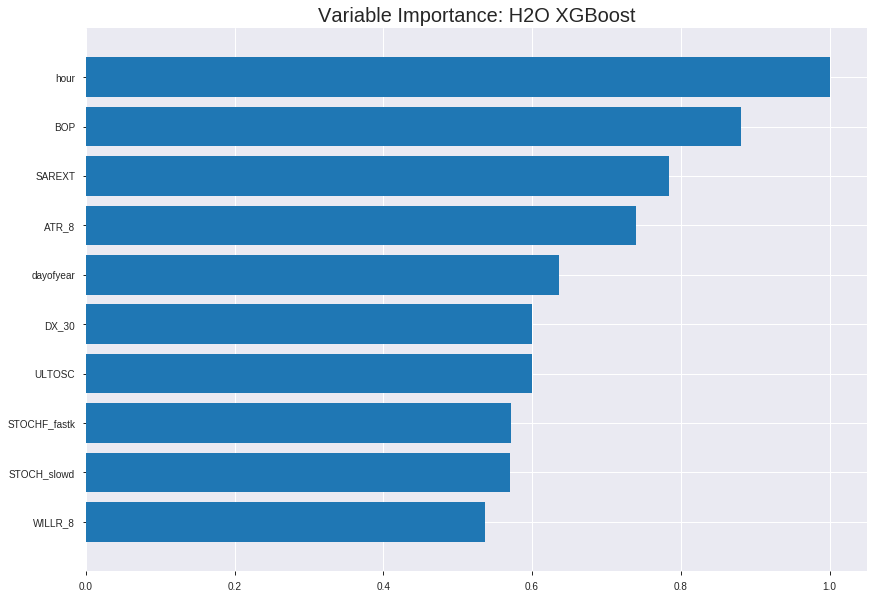

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_173422_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2170122286486319
RMSE: 0.4658457133522127
LogLoss: 0.6261999651179866
Mean Per-Class Error: 0.24309214087251463
AUC: 0.8341121495327103
pr_auc: 0.8452742075381043
Gini: 0.6682242990654206
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49787120521068573: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1331  741   0.3576   (741.0/2072.0)
1      346   1901  0.154    (346.0/2247.0)
Total  1677  2642  0.2517   (1087.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497871     0.777664  229
max f2                       0.449194     0.861756  301
max f0point5                 0.535735     0.780206  169
max accuracy                 0.507338     0.757583  214
max precision                0.752275     1         0
max recall                   0.371663     1         378
max specificity              0.752275     1         0
max absolute_mcc             0.506679     0.514305  215
max min_per_class_accuracy   0.514103     0.752559  203
max mean_per_class_accuracy  0.515355     0.756908  201

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 51.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.681545           1.92212   1.92212            1                0.700721  1                           0.700721            0.0195817       0.0195817                  92.2118   92.2118
    2        0.0201436                   0.658558           1.87742   1.90003            0.976744         0.668637  0.988506                    0.684863            0.0186916       0.0382733                  87.7418   90.0025
    3        0.0300996                   0.644598           1.92212   1.90733            1                0.651299  0.992308                    0.673761            0.0191366       0.0574099                  92.2118   90.7333
    4        0.0400556                   0.633996           1.92212   1.91101            1                0.638958  0.99422                     0.665111            0.0191366       0.0765465                  92.2118   91.1008
    5        0.0500116                   0.625597           1.74332   1.87762            0.906977         0.629777  0.976852                    0.658077            0.0173565       0.093903                   74.3317   87.7625
    6        0.100023                    0.602103           1.81533   1.84648            0.944444         0.612991  0.960648                    0.635534            0.0907877       0.184691                   81.5334   84.6479
    7        0.150035                    0.584496           1.66406   1.78567            0.865741         0.592481  0.929012                    0.621183            0.0832221       0.267913                   66.4056   78.5672
    8        0.200046                    0.572075           1.64626   1.75082            0.856481         0.578374  0.91088                     0.610481            0.082332        0.350245                   64.6259   75.0818
    9        0.300069                    0.550559           1.48608   1.66257            0.773148         0.560954  0.864969                    0.593972            0.148643        0.498887                   48.6082   66.2573
    10       0.400093                    0.53215            1.3437    1.58286            0.699074         0.541474  0.823495                    0.580847            0.134401        0.633289                   34.3703   58.2856
    11       0.500116                    0.514875           1.13458   1.4932             0.590278         0.523093  0.776852                    0.569297            0.113485        0.746773                   13.4584   49.3201
    12       0.599907                    0.499571           0.900854  1.39467            0.468677         0.507179  0.725589                    0.558964            0.0898976       0.836671                   -9.91464  39.4667
    13       0.699931                    0.481745           0.654054  1.28883            0.340278         0.490569  0.670526                    0.54919             0.0654206       0.902092                   -34.5946  28.883
    14       0.799954                    0.461976           0.493878  1.18943            0.256944         0.472379  0.618813                    0.539586            0.0493992       0.951491                   -50.6122  18.9432
    15       0.899977                    0.433746           0.324802  1.09334            0.168981         0.44902   0.568819                    0.52952             0.0324878       0.983979                   -67.5198  9.33377
    16       1                           0.30312            0.160177  1                  0.0833333        0.403942  0.520259                    0.516959          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24598779097933324
RMSE: 0.49597156267202785
LogLoss: 0.6849784445779117
Mean Per-Class Error: 0.4441733733765295
AUC: 0.5678251341998849
pr_auc: 0.5718690320397484
Gini: 0.1356502683997698
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3926590383052826: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      13   594   0.9786   (594.0/607.0)
1      5    622   0.008    (5.0/627.0)
Total  18   1216  0.4854   (599.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392659     0.674986  386
max f2                       0.361687     0.838235  397
max f0point5                 0.464665     0.580099  304
max accuracy                 0.495482     0.558347  251
max precision                0.708343     1         0
max recall                   0.361687     1         397
max specificity              0.708343     1         0
max absolute_mcc             0.464665     0.118904  304
max min_per_class_accuracy   0.519052     0.54201   207
max mean_per_class_accuracy  0.495482     0.555827  251

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 51.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.683724           1.9681    1.9681             1                0.693948  1                           0.693948            0.0207337       0.0207337                  96.8102   96.8102
    2        0.0202593                   0.662178           1.31207   1.65321            0.666667         0.67284   0.84                        0.683816            0.0127592       0.0334928                  31.2068   65.3206
    3        0.0299838                   0.649574           1.14806   1.48937            0.583333         0.656407  0.756757                    0.674927            0.0111643       0.0446571                  14.806    48.9375
    4        0.0405186                   0.6333             1.05975   1.37767            0.538462         0.639728  0.7                         0.665775            0.0111643       0.0558214                  5.97473   37.7671
    5        0.0502431                   0.625217           0.820043  1.26974            0.416667         0.629754  0.645161                    0.658803            0.00797448      0.0637959                  -17.9957  26.9743
    6        0.100486                    0.597997           1.04754   1.15864            0.532258         0.609278  0.58871                     0.634041            0.0526316       0.116427                   4.75382   15.8641
    7        0.149919                    0.581618           1.03245   1.11703            0.52459          0.588162  0.567568                    0.618913            0.0510367       0.167464                   3.2447    11.7031
    8        0.200162                    0.568756           0.984051  1.08365            0.5              0.574319  0.550607                    0.60772             0.0494418       0.216906                   -1.5949   8.36513
    9        0.299838                    0.549384           1.16806   1.11171            0.593496         0.559053  0.564865                    0.591541            0.116427        0.333333                   16.8061   11.1712
    10       0.400324                    0.532649           1.19038   1.13146            0.604839         0.541071  0.574899                    0.578873            0.119617        0.452951                   19.0384   13.1459
    11       0.5                         0.519059           0.880046  1.08134            0.447154         0.525639  0.549433                    0.56826             0.0877193       0.54067                    -11.9954  8.13397
    12       0.599676                    0.504584           1.08806   1.08246            0.552846         0.511379  0.55                        0.558806            0.108453        0.649123                   8.80564   8.24561
    13       0.700162                    0.487769           0.984051  1.06833            0.5              0.496298  0.542824                    0.549835            0.0988836       0.748006                   -1.5949   6.83332
    14       0.799838                    0.468735           0.912047  1.04886            0.463415         0.477811  0.532928                    0.540859            0.0909091       0.838915                   -8.79527  4.88568
    15       0.899514                    0.44141            0.912047  1.0337             0.463415         0.455543  0.525225                    0.531405            0.0909091       0.929825                   -8.79527  3.36969
    16       1                           0.35762            0.698359  1                  0.354839         0.417102  0.508104                    0.519919         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:34:42  1.323 sec   0                  0.5              0.693147            0.5             0                  1                0.479741                         0.5                0.693147              0.5               0                    1                  0.491896
    2019-08-24 17:34:42  1.458 sec   5                  0.495196         0.683579            0.703119        0.709974           1.61633          0.402639                         0.499047           0.691242              0.545562          0.548825             1.26521            0.487034
    2019-08-24 17:34:42  1.630 sec   10                 0.490932         0.675139            0.733505        0.746491           1.87843          0.367909                         0.498139           0.689422              0.553932          0.563755             1.51392            0.485413
    2019-08-24 17:34:42  1.745 sec   15                 0.486837         0.667073            0.757225        0.77084            1.87843          0.322528                         0.497212           0.687558              0.563244          0.568474             1.51392            0.487844
    2019-08-24 17:34:42  1.863 sec   20                 0.483277         0.660084            0.771265        0.788974           1.87843          0.332716                         0.496682           0.686486              0.566916          0.575882             1.81671            0.491086
    2019-08-24 17:34:42  1.971 sec   25                 0.48003          0.653734            0.783657        0.799221           1.92212          0.310025                         0.496933           0.686985              0.562728          0.567444             1.81671            0.485413
    2019-08-24 17:34:42  2.095 sec   30                 0.476784         0.647383            0.79319         0.809668           1.92212          0.318592                         0.496875           0.686852              0.561552          0.565618             1.81671            0.486224
    2019-08-24 17:34:43  2.213 sec   35                 0.473946         0.641852            0.806495        0.822411           1.92212          0.273211                         0.496255           0.685588              0.567057          0.56931              1.9681             0.47893
    2019-08-24 17:34:43  2.322 sec   40                 0.471219         0.636553            0.814974        0.828465           1.92212          0.276221                         0.495945           0.684948              0.569449          0.572298             1.81671            0.484603
    2019-08-24 17:34:43  2.452 sec   45                 0.468447         0.631183            0.824692        0.836594           1.92212          0.268118                         0.495925           0.684883              0.569321          0.574049             1.9681             0.488655
    2019-08-24 17:34:43  2.633 sec   50                 0.465846         0.6262              0.834112        0.845274           1.92212          0.251679                         0.495972           0.684978              0.567825          0.571869             1.9681             0.485413

Variable Importances: 


variable      relative_importance    scaled_importance     percentage
------------  ---------------------  --------------------  ---------------------
hour          405.7744445800781      1.0                   0.058118819974291615
BOP           357.5115966796875      0.8810599126065315    0.05120616244734411
SAREXT        317.9682312011719      0.7836083209484179    0.04554239093555803
ATR_8         299.99005126953125     0.7393024752457749    0.04296738746535737
dayofyear     258.1513977050781      0.6361943221245242    0.036974863276221716
---           ---                    ---                   ---
STOCHF_fastd  15.339673042297363     0.037803447819814914  0.0021970917782473502
CDLDOJI       6.825489044189453      0.016820894305586233  0.0009776105279529533
month         5.149801731109619      0.012691291430240191  0.0007376028818753997
week          4.523532867431641      0.011147899843995567  0.0006479027841246119
weekday_name  4.41816520690918       0.010888229325238521  0.0006328110399923403


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737439222042139)

('F1', 0.6921443736730362)

('auc', 0.5813041553348934)

('logloss', 0.6813077210440536)

('mean_per_class_error', 0.4190542449349609)

('rmse', 0.49419078084705476)

('mse', 0.2442245278742217)

xgboost prediction progress: |████████████████████████████████████████████| 100%


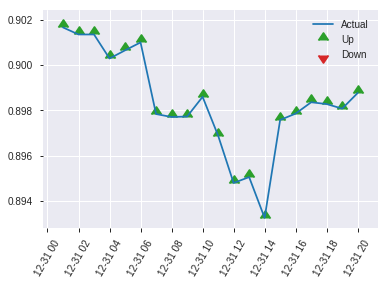


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2442245278742217
RMSE: 0.49419078084705476
LogLoss: 0.6813077210440536
Mean Per-Class Error: 0.4190542449349609
AUC: 0.5813041553348934
pr_auc: 0.6138078887957091
Gini: 0.16260831066978687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36666107177734375: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    290  0.9966   (290.0/291.0)
1      0    326  0        (0.0/326.0)
Total  1    616  0.47     (290.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.366661     0.692144  398
max f2                       0.366661     0.848958  398
max f0point5                 0.498881     0.595808  221
max accuracy                 0.522515     0.573744  168
max precision                0.734893     1         0
max recall                   0.366661     1         398
max specificity              0.734893     1         0
max absolute_mcc             0.522515     0.1667    168
max min_per_class_accuracy   0.503946     0.56701   209
max mean_per_class_accuracy  0.522515     0.580946  168

Gains/Lift Table: Avg response rate: 52.84 %, avg score: 51.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.707895           1.89264   1.89264            1                0.715634  1                           0.715634            0.0214724       0.0214724                  89.2638   89.2638
    2        0.0210697                   0.672149           1.5772    1.74705            0.833333         0.685744  0.923077                    0.701839            0.0153374       0.0368098                  57.7198   74.705
    3        0.0307942                   0.639874           1.26176   1.5938             0.666667         0.649315  0.842105                    0.685252            0.0122699       0.0490798                  26.1759   59.38
    4        0.0405186                   0.629705           1.26176   1.51411            0.666667         0.634677  0.8                         0.673114            0.0122699       0.0613497                  26.1759   51.411
    5        0.0502431                   0.618346           0.946319  1.40422            0.5              0.622899  0.741935                    0.663395            0.00920245      0.0705521                  -5.3681   40.4215
    6        0.100486                    0.596234           0.915793  1.16               0.483871         0.610069  0.612903                    0.636732            0.0460123       0.116564                   -8.42074  16.0004
    7        0.150729                    0.575555           1.34316   1.22106            0.709677         0.585579  0.645161                    0.619681            0.0674847       0.184049                   34.3162   22.1057
    8        0.200972                    0.560572           1.34316   1.25158            0.709677         0.566181  0.66129                     0.606306            0.0674847       0.251534                   34.3162   25.1583
    9        0.299838                    0.535388           1.17902   1.22766            0.622951         0.547236  0.648649                    0.586829            0.116564        0.368098                   17.902    22.7657
    10       0.400324                    0.517916           1.0379    1.18003            0.548387         0.526654  0.623482                    0.571724            0.104294        0.472393                   3.78983   18.0025
    11       0.50081                     0.504479           0.915793  1.12701            0.483871         0.51059   0.595469                    0.559458            0.0920245       0.564417                   -8.42074  12.7008
    12       0.599676                    0.489609           0.899779  1.08955            0.47541          0.497026  0.575676                    0.549165            0.0889571       0.653374                   -10.0221  8.95457
    13       0.700162                    0.475063           0.732634  1.03832            0.387097         0.482394  0.548611                    0.539582            0.0736196       0.726994                   -26.7366  3.83223
    14       0.799028                    0.460019           0.961832  1.02886            0.508197         0.468107  0.543611                    0.530738            0.095092        0.822086                   -3.81676  2.8858
    15       0.899514                    0.434717           0.885266  1.01282            0.467742         0.448863  0.535135                    0.521592            0.0889571       0.911043                   -11.4734  1.28171
    16       1                           0.356553           0.885266  1                  0.467742         0.411133  0.528363                    0.510492            0.

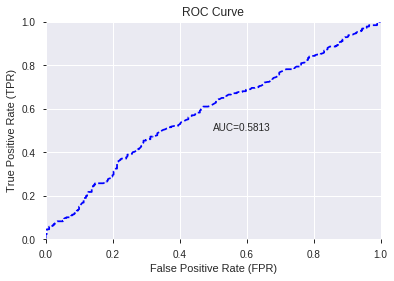

This function is available for GLM models only


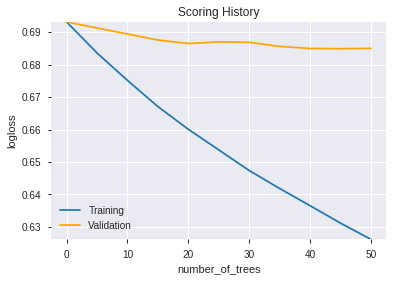

--2019-08-24 17:35:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.228
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.228|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_173422_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_173422_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_30_sid_87c2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['hour',
 'BOP',
 'SAREXT',
 'ATR_8',
 'dayofyear',
 'DX_30',
 'ULTOSC',
 'STOCHF_fastk',
 'STOCH_slowd',
 'WILLR_8',
 'CCI_8',
 'STOCHRSI_fastk',
 'WILLR_12',
 'NATR_30',
 'MACDFIX_signal_14',
 'PLUS_DM_24',
 'DX_12',
 'STOCH_slowk',
 'PLUS_DI_14',
 'AROONOSC_30',
 'WILLR_14',
 'AROONOSC_14',
 'PLUS_DM_30',
 'MINUS_DI_24',
 'WILLR_24',
 'PLUS_DI_30',
 'CCI_24',
 'aroondown_14',
 'AROONOSC_20',
 'MINUS_DI_12',
 'CMO_8',
 'dayofweek',
 'aroondown_30',
 'aroondown_20',
 'aroonup_8',
 'aroonup_30',
 'aroonup_20',
 'aroonup_24',
 'MINUS_DI_20',
 'aroondown_8',
 'PLUS_DI_24',
 'AROONOSC_12',
 'aroondown_12',
 'HT_TRENDMODE',
 'days_in_month',
 'STOCHF_fastd',
 'CDLDOJI',
 'month',
 'week',
 'weekday_name']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_173512_model_1  0.55259  0.688498              0.481896  0.497675  0.247681

variable  relative_importance  scaled_importance  percentage
0                    CDLHAMMER             0.007936           1.000000    0.011818
1            CDLINVERTEDHAMMER             0.007909           0.996585    0.011778
2                          BOP             0.007593           0.956809    0.011308
3                 STOCHF_fastk             0.007241           0.912384    0.010783
4                  CDLBELTHOLD             0.006973           0.878692    0.010385
...                        ...                  ...                ...         ...
1036  BBANDS_middleband_12_3_5             0.000000           0.000000    0.000000
1037  BBANDS_middleband_30_0_2             0.000000           0.000000    0.000000
1038  BBANDS_middleband_30_1_2             0.000000           0.000000    0.000000
1039  BBANDS_middleband_30_1_3             0.000000           0.000000    0.000000
1040  BBANDS_middleband_30_1_4             0.000000           0.000000    0.000000

[1041 rows x 4 columns]

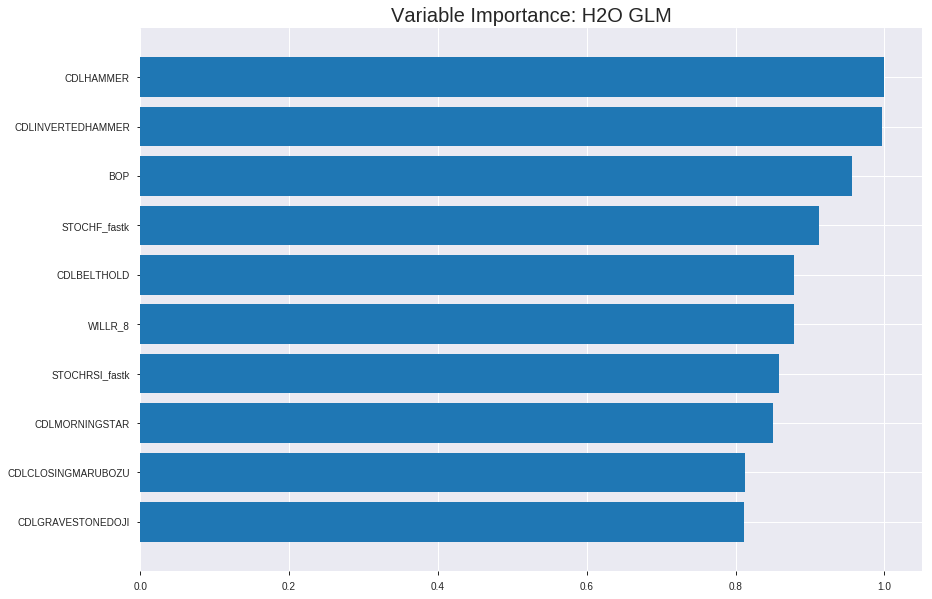

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_173512_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24709512927702237
RMSE: 0.4970866416199719
LogLoss: 0.68731534717472
Null degrees of freedom: 4318
Residual degrees of freedom: 3282
Null deviance: 5980.312642429541
Residual deviance: 5937.029968895231
AIC: 8011.029968895231
AUC: 0.5721990109506798
pr_auc: 0.587023968741081
Gini: 0.14439802190135964
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45643028604803526: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      7    2065  0.9966   (2065.0/2072.0)
1      2    2245  0.0009   (2.0/2247.0)
Total  9    4310  0.4786   (2067.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45643      0.684764  392
max f2                       0.451889     0.844483  396
max f0point5                 0.498686     0.584483  295
max accuracy                 0.512046     0.558926  238
max precision                0.606551     1         0
max recall                   0.451889     1         396
max specificity              0.606551     1         0
max absolute_mcc             0.518776     0.113939  210
max min_per_class_accuracy   0.519537     0.552737  206
max mean_per_class_accuracy  0.518776     0.556987  210

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 52.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101875                   0.578377           1.44159   1.44159            0.75             0.586825  0.75                        0.586825            0.0146862       0.0146862                  44.1589    44.1589
    2        0.0201436                   0.571399           1.43041   1.43607            0.744186         0.574874  0.747126                    0.580918            0.0142412       0.0289275                  43.0414    43.6065
    3        0.0300996                   0.56634            1.16221   1.34548            0.604651         0.569264  0.7                         0.577063            0.011571        0.0404984                  16.2211    34.5483
    4        0.0400556                   0.563125           1.20691   1.31104            0.627907         0.564545  0.682081                    0.573952            0.012016        0.0525145                  20.6912    31.104
    5        0.0500116                   0.560088           1.51981   1.3526             0.790698         0.561506  0.703704                    0.571474            0.0151313       0.0676457                  51.9815    35.2602
    6        0.100023                    0.550338           1.17463   1.26361            0.611111         0.554465  0.657407                    0.56297             0.058745        0.126391                   17.4628    26.3615
    7        0.150035                    0.543998           1.08564   1.20429            0.564815         0.546989  0.626543                    0.557643            0.0542946       0.180685                   8.56409    20.429
    8        0.200046                    0.539031           1.08564   1.17463            0.564815         0.541567  0.611111                    0.553624            0.0542946       0.23498                    8.56409    17.4628
    9        0.300069                    0.531958           1.06339   1.13755            0.553241         0.535321  0.591821                    0.547523            0.106364        0.341344                   6.33942    13.755
    10       0.400093                    0.525442           1.0278    1.11011            0.534722         0.528532  0.577546                    0.542775            0.102804        0.444148                   2.77994    11.0112
    11       0.500116                    0.519449           1.08119   1.10433            0.5625           0.522428  0.574537                    0.538706            0.108144        0.552292                   8.11916    10.4328
    12       0.599907                    0.513735           0.994507  1.08606            0.517401         0.516802  0.565033                    0.535062            0.0992434       0.651535                   -0.549327  8.60599
    13       0.699931                    0.507355           0.907667  1.06057            0.472222         0.510616  0.55177                     0.531569            0.0907877       0.742323                   -9.2333    6.05668
    14       0.799954                    0.500358           0.898768  1.04034            0.467593         0.503973  0.541245                    0.528118            0.0898976       0.832221                   -10.1232   4.03361
    15       0.899977                    0.491153           0.88542   1.02312            0.460648         0.496076  0.532287                    0.524557            0.0885625       0.920783                   -11.458    2.31188
    16       1                           0.435466           0.791984  1                  0.412037         0.481589  0.520259                    0.5



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24923190957324862
RMSE: 0.4992313187023112
LogLoss: 0.6916273252019686
Null degrees of freedom: 1233
Residual degrees of freedom: 197
Null deviance: 1711.0932050440474
Residual deviance: 1706.9362385984584
AIC: 3780.9362385984587
AUC: 0.5497413220035261
pr_auc: 0.5423159367998097
Gini: 0.0994826440070522
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4878464053534577: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      25   582   0.9588   (582.0/607.0)
1      12   615   0.0191   (12.0/627.0)
Total  37   1197  0.4814   (594.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.487846     0.674342   372
max f2                       0.447446     0.837787   399
max f0point5                 0.487846     0.567867   372
max accuracy                 0.529107     0.548622   207
max precision                0.545837     0.59661    128
max recall                   0.447446     1          399
max specificity              0.650101     0.998353   0
max absolute_mcc             0.545837     0.0992293  128
max min_per_class_accuracy   0.529107     0.5486     207
max mean_per_class_accuracy  0.529107     0.548622   207

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 53.00 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.613448           0.908355  0.908355           0.461538         0.627437  0.461538                    0.627437            0.00956938      0.00956938                 -9.16452  -9.16452
    2        0.0202593                   0.588124           1.14806   1.02341            0.583333         0.59386   0.52                        0.61132             0.0111643       0.0207337                  14.806    2.34131
    3        0.0299838                   0.578916           0.820043  0.957455           0.416667         0.58315   0.486486                    0.602184            0.00797448      0.0287081                  -17.9957  -4.25449
    4        0.0405186                   0.571754           1.05975   0.984051           0.538462         0.575376  0.5                         0.595214            0.0111643       0.0398724                  5.97473   -1.5949
    5        0.0502431                   0.568486           0.984051  0.984051           0.5              0.570225  0.5                         0.590377            0.00956938      0.0494418                  -1.5949   -1.5949
    6        0.100486                    0.559977           1.26974   1.1269             0.645161         0.564078  0.572581                    0.577228            0.0637959       0.113238                   26.9743   12.6897
    7        0.149919                    0.554282           1.09697   1.11703            0.557377         0.556882  0.567568                    0.570519            0.0542265       0.167464                   9.69749   11.7031
    8        0.200162                    0.548992           1.26974   1.15536            0.645161         0.5519    0.587045                    0.565845            0.0637959       0.23126                    26.9743   15.5364
    9        0.299838                    0.541537           1.04005   1.11703            0.528455         0.544953  0.567568                    0.5589              0.103668        0.334928                   4.00539   11.7031
    10       0.400324                    0.535393           1.04754   1.09959            0.532258         0.538239  0.558704                    0.553714            0.105263        0.440191                   4.75382   9.95874
    11       0.5                         0.529071           1.07206   1.0941             0.544715         0.532307  0.555916                    0.549447            0.106858        0.547049                   7.20556   9.40989
    12       0.599676                    0.523384           0.816042  1.04788            0.414634         0.526291  0.532432                    0.545598            0.0813397       0.628389                   -18.3958  4.78814
    13       0.700162                    0.516029           0.984051  1.03872            0.5              0.519653  0.527778                    0.541874            0.0988836       0.727273                   -1.5949   3.87205
    14       0.799838                    0.509097           0.928048  1.02493            0.471545         0.512571  0.52077                     0.538223            0.092504        0.819777                   -7.19519  2.49285
    15       0.899514                    0.499069           0.944049  1.01597            0.479675         0.504544  0.516216                    0.534491            0.0940989       0.913876                   -5.5951   1.59662
    16       1                           0.447446           0.857077  1                  0.435484         0.489397  0.508104                    0.529959       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 17:35:20  0.000 sec   2            3.3       1035          1.37635           1.38328
    2019-08-24 17:35:25  4.938 sec   4            2.4       1037          1.37463           1.38325
    2019-08-24 17:35:30  9.818 sec   6            1.7       1038          1.37269           1.38346
    2019-08-24 17:35:36  15.030 sec  8            1.3       1038          1.37058           1.38387
    2019-08-24 17:35:40  19.916 sec  10           0.92      1041          1.36833           1.38452
    2019-08-24 17:35:45  24.874 sec  12           0.67      1042          1.36598           1.38546
    2019-08-24 17:35:50  29.832 sec  14           0.49      1042          1.36356           1.38673

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5575364667747164)

('F1', 0.6955579631635969)

('auc', 0.5525899690089178)

('logloss', 0.6884982297793826)

('mean_per_class_error', 0.45737672084835457)

('rmse', 0.4976752435146341)

('mse', 0.24768064800735035)

glm prediction progress: |████████████████████████████████████████████████| 100%


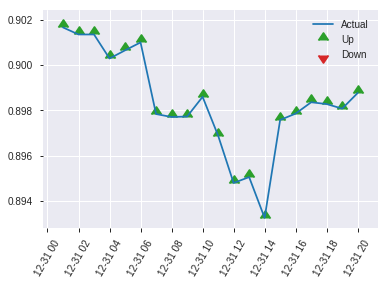


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24768064800735035
RMSE: 0.4976752435146341
LogLoss: 0.6884982297793826
Null degrees of freedom: 616
Residual degrees of freedom: -420
Null deviance: 853.5195608018752
Residual deviance: 849.6068155477582
AIC: 2923.6068155477583
AUC: 0.5525899690089178
pr_auc: 0.5722684723971522
Gini: 0.10517993801783554
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4834915112197015: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   276  0.9485   (276.0/291.0)
1      5    321  0.0153   (5.0/326.0)
Total  20   597  0.4554   (281.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.483492     0.695558  380
max f2                       0.449779     0.848516  399
max f0point5                 0.490115     0.597617  359
max accuracy                 0.490388     0.557536  358
max precision                0.593723     1         0
max recall                   0.449779     1         399
max specificity              0.593723     1         0
max absolute_mcc             0.490115     0.125595  359
max min_per_class_accuracy   0.51871      0.525773  204
max mean_per_class_accuracy  0.541862     0.542623  76

Gains/Lift Table: Avg response rate: 52.84 %, avg score: 51.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.569933           1.08151   1.08151            0.571429         0.580875  0.571429                    0.580875            0.0122699       0.0122699                  8.15074   8.15074
    2        0.0210697                   0.564914           1.26176   1.1647             0.666667         0.567802  0.615385                    0.574842            0.0122699       0.0245399                  26.1759   16.47
    3        0.0307942                   0.560606           1.26176   1.19535            0.666667         0.56224   0.631579                    0.570862            0.0122699       0.0368098                  26.1759   19.535
    4        0.0405186                   0.556982           0.946319  1.13558            0.5              0.558651  0.6                         0.567932            0.00920245      0.0460123                  -5.3681   13.5583
    5        0.0502431                   0.555599           1.26176   1.16               0.666667         0.556388  0.612903                    0.565697            0.0122699       0.0582822                  26.1759   16.0004
    6        0.100486                    0.548206           1.34316   1.25158            0.709677         0.551316  0.66129                     0.558506            0.0674847       0.125767                   34.3162   25.1583
    7        0.150729                    0.54299            1.16      1.22106            0.612903         0.545695  0.645161                    0.554236            0.0582822       0.184049                   16.0004   22.1057
    8        0.200972                    0.538678           0.976845  1.16               0.516129         0.540921  0.612903                    0.550907            0.0490798       0.233129                   -2.31546  16.0004
    9        0.299838                    0.53157            0.992859  1.10489            0.52459          0.535228  0.583784                    0.545737            0.0981595       0.331288                   -0.71407  10.4891
    10       0.400324                    0.52363            0.976845  1.07275            0.516129         0.527382  0.566802                    0.54113             0.0981595       0.429448                   -2.31546  7.27503
    11       0.50081                     0.518712           0.946319  1.04738            0.5              0.521085  0.553398                    0.537108            0.095092        0.52454                    -5.3681   4.73822
    12       0.599676                    0.513446           1.02389   1.04351            0.540984         0.515764  0.551351                    0.533589            0.101227        0.625767                   2.38862   4.35085
    13       0.700162                    0.507605           1.06842   1.04708            0.564516         0.510277  0.553241                    0.530243            0.107362        0.733129                   6.84247   4.70845
    14       0.799028                    0.500918           0.899779  1.02886            0.47541          0.504132  0.543611                    0.527013            0.0889571       0.822086                   -10.0221  2.8858
    15       0.899514                    0.491822           1.09895   1.03669            0.580645         0.496729  0.547748                    0.52363             0.110429        0.932515                   9.89511   3.66882
    16       1                           0.449779           0.671581  1                  0.354839         0.484397  0.528363                    0.519687            0

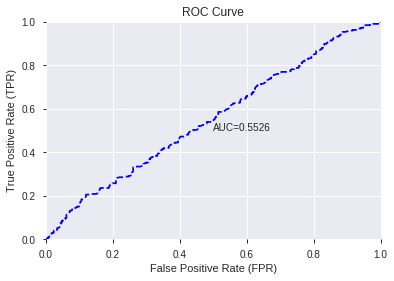

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


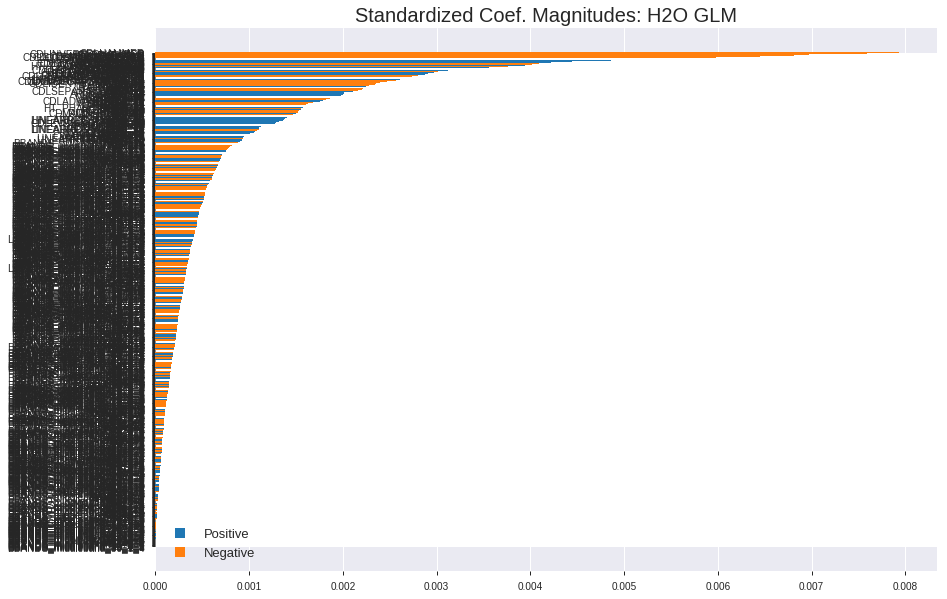

'log_likelihood'
--2019-08-24 17:36:14--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.207.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.207.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_173512_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_173512_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_38_sid_87c2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_38_s

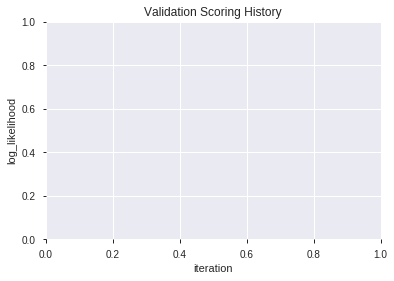

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_173624_model_6  0.589663  0.678820              0.487235  0.492932  0.242982
1  XGBoost_grid_1_AutoML_20190824_173624_model_2  0.588952  0.679380              0.431319  0.493207  0.243253
2  XGBoost_grid_1_AutoML_20190824_173624_model_7  0.578664  0.683439              0.498282  0.495171  0.245194
3  XGBoost_grid_1_AutoML_20190824_173624_model_4  0.570800  0.683071              0.498282  0.495045  0.245069
4               XGBoost_2_AutoML_20190824_173624  0.569424  0.686042              0.494476  0.496388  0.246401
5  XGBoost_grid_1_AutoML_20190824_173624_model_3  0.565034  0.682847              0.451822  0.494985  0.245010
6  XGBoost_grid_1_AutoML_20190824_173624_model_5  0.560928  0.695708              0.479013  0.500725  0.250726
7               XGBoost_1_AutoML_20190824_173624  0.557992  0.688572              0.491224  0.497682  0.247688
8               XGBoost_3_AutoML_20190824_173624  0.546197  0.691015              0.489322  0.498879  0.248880
9  XGBoost_grid_1_AutoML_20190824_173624_model_1  0.544341  0.694992              0.500000  0.500768  0.250768

variable  relative_importance  scaled_importance  percentage
0                        BOP           191.727417           1.000000    0.020357
1                       DX_8           149.832169           0.781485    0.015908
2                     Volume           138.476715           0.722258    0.014703
3                STOCH_slowd           138.051453           0.720040    0.014658
4               STOCHF_fastk           133.172226           0.694591    0.014139
..                       ...                  ...                ...         ...
307  BBANDS_upperband_20_7_3             4.037742           0.021060    0.000429
308  BBANDS_upperband_24_2_3             3.975240           0.020734    0.000422
309                MACDFIX_8             3.970754           0.020710    0.000422
310          MACDFIX_hist_14             2.946869           0.015370    0.000313
311  BBANDS_lowerband_24_0_3             2.944230           0.015356    0.000313

[312 rows x 4 columns]

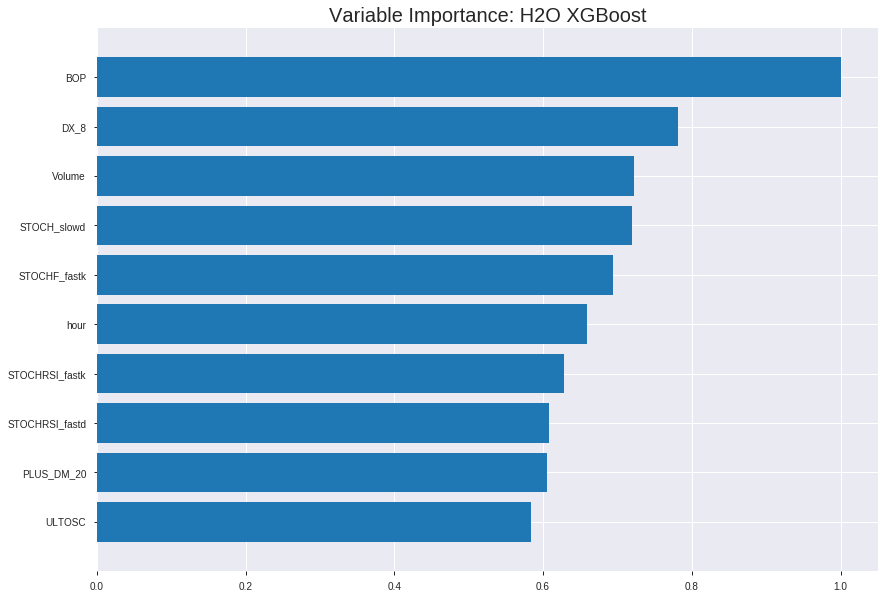

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_173624_model_6


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2085171813308938
RMSE: 0.45663681556669716
LogLoss: 0.6086888979884454
Mean Per-Class Error: 0.20788453673967688
AUC: 0.8756602539980377
pr_auc: 0.8868449373213392
Gini: 0.7513205079960754
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4986732258246495: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1467  605   0.292    (605.0/2072.0)
1      311   1936  0.1384   (311.0/2247.0)
Total  1778  2541  0.2121   (916.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498673     0.808688  232
max f2                       0.467182     0.879777  275
max f0point5                 0.528845     0.814329  191
max accuracy                 0.512682     0.792082  212
max precision                0.758227     1         0
max recall                   0.395103     1         353
max specificity              0.758227     1         0
max absolute_mcc             0.512682     0.583892  212
max min_per_class_accuracy   0.512682     0.791277  212
max mean_per_class_accuracy  0.512682     0.792115  212

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 51.79 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.706092           1.92212    1.92212            1                0.722558  1                           0.722558            0.0195817       0.0195817                  92.2118   92.2118
    2        0.0201436                   0.682894           1.92212    1.92212            1                0.691146  1                           0.707032            0.0191366       0.0387183                  92.2118   92.2118
    3        0.0300996                   0.664672           1.92212    1.92212            1                0.673612  1                           0.695978            0.0191366       0.0578549                  92.2118   92.2118
    4        0.0400556                   0.655908           1.92212    1.92212            1                0.660136  1                           0.687069            0.0191366       0.0769915                  92.2118   92.2118
    5        0.0500116                   0.646496           1.87742    1.91322            0.976744         0.651001  0.99537                     0.679889            0.0186916       0.0956831                  87.7418   91.322
    6        0.100023                    0.617503           1.85983    1.88652            0.967593         0.630774  0.981481                    0.655331            0.0930129       0.188696                   85.9828   88.6524
    7        0.150035                    0.596991           1.85093    1.87466            0.962963         0.607311  0.975309                    0.639324            0.0925679       0.281264                   85.0929   87.4659
    8        0.200046                    0.578975           1.76194    1.84648            0.916667         0.587219  0.960648                    0.626298            0.0881175       0.369381                   76.1942   84.6479
    9        0.300069                    0.554488           1.57507    1.75601            0.819444         0.566307  0.91358                     0.606301            0.157543        0.526925                   57.5069   75.6009
    10       0.400093                    0.532894           1.33925    1.65182            0.696759         0.543508  0.859375                    0.590603            0.133956        0.660881                   33.9254   65.182
    11       0.500116                    0.514253           1.16128    1.55371            0.604167         0.523872  0.808333                    0.577257            0.116155        0.777036                   16.128    55.3712
    12       0.599907                    0.495833           0.936531   1.45105            0.487239         0.505216  0.754921                    0.565273            0.0934579       0.870494                   -6.3469   45.1047
    13       0.699931                    0.477435           0.600662   1.32952            0.3125           0.486582  0.691697                    0.554028            0.0600801       0.930574                   -39.9338  32.9523
    14       0.799954                    0.456353           0.413789   1.21502            0.215278         0.46678   0.632127                    0.543119            0.0413885       0.971963                   -58.6211  21.5024
    15       0.899977                    0.424898           0.209119   1.10323            0.108796         0.441787  0.573964                    0.531857            0.0209168       0.992879                   -79.0881  10.3228
    16       1                           0.280251           0.0711896  1                  0.037037         0.392418  0.520259                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24994344527356183
RMSE: 0.49994344207476293
LogLoss: 0.6930989484453354
Mean Per-Class Error: 0.44819739929425184
AUC: 0.5489924827044397
pr_auc: 0.5531712528387013
Gini: 0.09798496540887935
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3802756816148758: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      6    601   0.9901   (601.0/607.0)
1      2    625   0.0032   (2.0/627.0)
Total  8    1226  0.4887   (603.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.380276     0.674582  393
max f2                       0.371163     0.838235  397
max f0point5                 0.405038     0.565951  381
max accuracy                 0.54807      0.551053  182
max precision                0.778423     1         0
max recall                   0.371163     1         397
max specificity              0.778423     1         0
max absolute_mcc             0.54807      0.104021  182
max min_per_class_accuracy   0.542042     0.5486    193
max mean_per_class_accuracy  0.54807      0.551803  182

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 54.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105348                   0.696045           1.36253   1.36253            0.692308         0.720038  0.692308                    0.720038            0.0143541       0.0143541                  36.2532    36.2532
    2        0.0202593                   0.6841             1.14806   1.25959            0.583333         0.690982  0.64                        0.706091            0.0111643       0.0255183                  14.806     25.9585
    3        0.0299838                   0.667402           0.820043  1.11703            0.416667         0.673825  0.567568                    0.695627            0.00797448      0.0334928                  -17.9957   11.7031
    4        0.0405186                   0.657674           1.66532   1.25959            0.846154         0.66291   0.64                        0.68712             0.0175439       0.0510367                  66.5317    25.9585
    5        0.0502431                   0.65134            0.492026  1.11103            0.25             0.653673  0.564516                    0.680647            0.00478469      0.0558214                  -50.7974   11.1025
    6        0.100486                    0.630592           1.30149   1.20626            0.66129          0.641305  0.612903                    0.660976            0.0653907       0.121212                   30.1487    20.6256
    7        0.149919                    0.610693           1.00018   1.13831            0.508197         0.619236  0.578378                    0.647213            0.0494418       0.170654                   0.0183021  13.8308
    8        0.200162                    0.59728            1.07928   1.12349            0.548387         0.603763  0.57085                     0.636306            0.0542265       0.22488                    7.92818    12.3491
    9        0.299838                    0.574861           1.08806   1.11171            0.552846         0.585246  0.564865                    0.619332            0.108453        0.333333                   8.80564    11.1712
    10       0.400324                    0.555288           1.07928   1.10357            0.548387         0.564579  0.560729                    0.605589            0.108453        0.441786                   7.92818    10.3571
    11       0.5                         0.54193            1.05605   1.0941             0.536585         0.548301  0.555916                    0.594168            0.105263        0.547049                   5.60548    9.40989
    12       0.599676                    0.524353           0.800041  1.04522            0.406504         0.533502  0.531081                    0.584085            0.0797448       0.626794                   -19.9959   4.52218
    13       0.700162                    0.508661           0.920564  1.02733            0.467742         0.516125  0.521991                    0.574331            0.092504        0.719298                   -7.94361   2.73311
    14       0.799838                    0.485679           1.05605   1.03091            0.536585         0.497753  0.52381                     0.564788            0.105263        0.824561                   5.60548    3.09106
    15       0.899514                    0.453456           0.784041  1.00355            0.398374         0.47231   0.50991                     0.55454             0.0781499       0.902711                   -21.5959   0.355475
    16       1                           0.317202           0.968179  1                  0.491935         0.422668  0.508104                   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:37:47  45.913 sec  0                  0.5              0.693147            0.5             0                  1                0.479741                         0.5                0.693147              0.5               0                    1                  0.491896
    2019-08-24 17:37:48  46.981 sec  5                  0.492805         0.678834            0.71682         0.73522            1.92212          0.39222                          0.499798           0.692745              0.517265          0.52737              1.21114            0.491896
    2019-08-24 17:37:48  47.336 sec  10                 0.487237         0.667856            0.761098        0.775577           1.83475          0.355869                         0.498805           0.69075               0.539725          0.551598             1.05975            0.491896
    2019-08-24 17:37:48  47.701 sec  15                 0.483416         0.660359            0.784106        0.798621           1.92212          0.317435                         0.498293           0.68971               0.552033          0.561316             1.05975            0.489465
    2019-08-24 17:37:49  48.046 sec  20                 0.47906          0.651837            0.801457        0.816234           1.92212          0.284094                         0.498532           0.690175              0.548773          0.558876             1.51392            0.491896
    2019-08-24 17:37:49  48.403 sec  25                 0.475525         0.644961            0.817732        0.830774           1.87843          0.268581                         0.498811           0.690736              0.544126          0.553263             1.21114            0.491086
    2019-08-24 17:37:49  48.865 sec  30                 0.471843         0.637835            0.831542        0.843847           1.92212          0.259551                         0.499072           0.691263              0.543977          0.55135              1.21114            0.491086
    2019-08-24 17:37:50  49.252 sec  35                 0.467988         0.630411            0.841149        0.854              1.92212          0.246353                         0.499332           0.691793              0.543343          0.55022              1.51392            0.490276
    2019-08-24 17:37:50  49.711 sec  40                 0.464046         0.622822            0.853691        0.866453           1.92212          0.234777                         0.499061           0.691247              0.549172          0.559194             1.81671            0.490276
    2019-08-24 17:37:51  50.114 sec  45                 0.4594           0.613984            0.870457        0.88158            1.92212          0.21718                          0.499116           0.691368              0.55051           0.558528             1.66532            0.490276
    2019-08-24 17:37:51  50.501 sec  50                 0.456637         0.608689            0.87566         0.886845           1.92212          0.212086                         0.499943           0.693099              0.548992          0.553171             1.36253            0.488655

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BOP                      191.7274169921875      1.0                   0.02035650171135352
DX_8                     149.83216857910156     0.7814853552489414    0.015908307971522786
Volume                   138.47671508789062     0.7222582834542295    0.01470265198317528
STOCH_slowd              138.05145263671875     0.7200402258710035    0.014657500090186456
STOCHF_fastk             133.17222595214844     0.694591457191409     0.014139452187008452
---                      ---                    ---                   ---
BBANDS_upperband_20_7_3  4.0377421379089355     0.02105980564101307   0.0004287039695720551
BBANDS_upperband_24_2_3  3.9752402305603027     0.020733812059452537  0.00042206788067112786
MACDFIX_8                3.9707536697387695     0.02071041133308842   0.00042159152374484976
MACDFIX_hist_14          2.946868896484375      0.015370096477148357  0.0003128813952407392
BBANDS_lowerband_24_0_3  2.944230079650879      0.01535633309956317   0.00031260122102137234


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5786061588330632)

('F1', 0.6939655172413793)

('auc', 0.5896633145700252)

('logloss', 0.6788200422392086)

('mean_per_class_error', 0.4192492568464993)

('rmse', 0.49293233323589797)

('mse', 0.24298228514938636)

xgboost prediction progress: |████████████████████████████████████████████| 100%


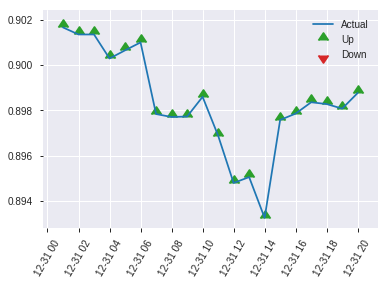


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24298228514938636
RMSE: 0.49293233323589797
LogLoss: 0.6788200422392086
Mean Per-Class Error: 0.4192492568464993
AUC: 0.5896633145700252
pr_auc: 0.6271714123002546
Gini: 0.17932662914005038
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42223432660102844: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      11   280  0.9622   (280.0/291.0)
1      4    322  0.0123   (4.0/326.0)
Total  15   602  0.4603   (284.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.422234     0.693966  384
max f2                       0.387136     0.849844  396
max f0point5                 0.527009     0.598782  193
max accuracy                 0.527009     0.578606  193
max precision                0.716575     1         0
max recall                   0.387136     1         396
max specificity              0.716575     1         0
max absolute_mcc             0.558371     0.174947  120
max min_per_class_accuracy   0.52296      0.563574  206
max mean_per_class_accuracy  0.527009     0.580751  193

Gains/Lift Table: Avg response rate: 52.84 %, avg score: 52.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.669495           1.89264   1.89264            1                0.689669  1                           0.689669            0.0214724       0.0214724                  89.2638   89.2638
    2        0.0210697                   0.651135           1.26176   1.60146            0.666667         0.657153  0.846154                    0.674661            0.0122699       0.0337423                  26.1759   60.1463
    3        0.0307942                   0.641293           1.5772    1.5938             0.833333         0.647643  0.842105                    0.666129            0.0153374       0.0490798                  57.7198   59.38
    4        0.0405186                   0.635386           0.630879  1.3627             0.333333         0.638924  0.72                        0.6596              0.00613497      0.0552147                  -36.9121  36.2699
    5        0.0502431                   0.630056           1.26176   1.34316            0.666667         0.632378  0.709677                    0.654331            0.0122699       0.0674847                  26.1759   34.3162
    6        0.100486                    0.6049             1.34316   1.34316            0.709677         0.616288  0.709677                    0.635309            0.0674847       0.134969                   34.3162   34.3162
    7        0.150729                    0.589105           1.22106   1.30246            0.645161         0.596668  0.688172                    0.622429            0.0613497       0.196319                   22.1057   30.2461
    8        0.200972                    0.570606           1.28211   1.29737            0.677419         0.57879   0.685484                    0.611519            0.0644172       0.260736                   28.211    29.7373
    9        0.299838                    0.552813           1.05491   1.21743            0.557377         0.560365  0.643243                    0.594652            0.104294        0.365031                   5.4913    21.7427
    10       0.400324                    0.536108           0.946319  1.14938            0.5              0.544924  0.607287                    0.58217             0.095092        0.460123                   -5.3681   14.9375
    11       0.50081                     0.523116           0.976845  1.11476            0.516129         0.529569  0.588997                    0.571616            0.0981595       0.558282                   -2.31546  11.4758
    12       0.599676                    0.507203           0.961832  1.08955            0.508197         0.515775  0.575676                    0.562409            0.095092        0.653374                   -3.81676  8.95457
    13       0.700162                    0.491321           0.885266  1.06023            0.467742         0.500457  0.560185                    0.553518            0.0889571       0.742331                   -11.4734  6.02278
    14       0.799028                    0.472927           0.930806  1.04421            0.491803         0.482373  0.551724                    0.544715            0.0920245       0.834356                   -6.91944  4.42141
    15       0.899514                    0.450429           0.702108  1.006              0.370968         0.462986  0.531532                    0.535585            0.0705521       0.904908                   -29.7892  0.599679
    16       1                           0.370737           0.946319  1                  0.5              0.4279    0.528363                    0.524764          

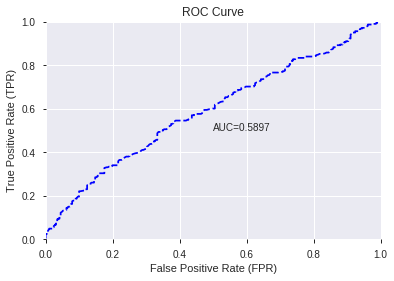

This function is available for GLM models only


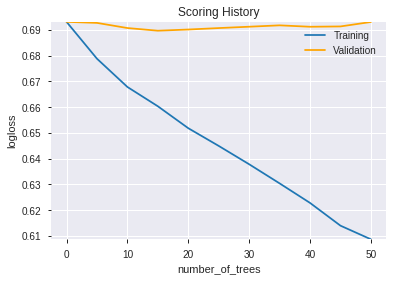

--2019-08-24 17:38:04--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_173624_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_173624_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_46_sid_87c2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_173813_model_2  0.570758  0.804871              0.448939  0.539359  0.290908
1  DeepLearning_grid_1_AutoML_20190824_173813_model_9  0.551520  0.691443              0.490671  0.499145  0.249146
2  DeepLearning_grid_1_AutoML_20190824_173813_model_7  0.545807  0.764979              0.500000  0.527663  0.278428
3  DeepLearning_grid_1_AutoML_20190824_173813_model_3  0.539983  0.713268              0.485332  0.509035  0.259117
4  DeepLearning_grid_1_AutoML_20190824_173813_model_5  0.539898  0.706984              0.494661  0.504886  0.254909
5  DeepLearning_grid_1_AutoML_20190824_173813_model_4  0.537453  0.733557              0.492943  0.516399  0.266667
6  DeepLearning_grid_1_AutoML_20190824_173813_model_1  0.534391  0.829557              0.478828  0.543665  0.295571
7  DeepLearning_grid_1_AutoML_20190824_173813_model_6  0.524524  0.700681              0.494845  0.503374  0.253385
8               DeepLearning_1_AutoML_20190824_173813  0.524013  0.760860              0.500000  0.525076  0.275705
9  DeepLearning_grid_1_AutoML_20190824_173813_model_8  0.500000  0.691614              0.500000  0.499233  0.249234

variable  relative_importance  scaled_importance  percentage
0              SAREXT             1.000000           1.000000    0.028834
1        HT_TRENDMODE             0.964257           0.964257    0.027804
2           aroonup_8             0.889829           0.889829    0.025658
3                hour             0.883831           0.883831    0.025485
4             CDLDOJI             0.874817           0.874817    0.025225
5         aroondown_8             0.866706           0.866706    0.024991
6          aroonup_24             0.811450           0.811450    0.023398
7               DX_12             0.801355           0.801355    0.023107
8                 BOP             0.796710           0.796710    0.022973
9      STOCHRSI_fastk             0.791838           0.791838    0.022832
10             ULTOSC             0.781309           0.781309    0.022529
11              CCI_8             0.769078           0.769078    0.022176
12       aroondown_30             0.766584           0.766584    0.022104
13         aroonup_20             0.761392           0.761392    0.021954
14        AROONOSC_14             0.745410           0.745410    0.021493
15       aroondown_20             0.742033           0.742033    0.021396
16       aroondown_12             0.736855           0.736855    0.021247
17              ATR_8             0.735947           0.735947    0.021221
18         aroonup_30             0.734904           0.734904    0.021191
19              DX_30             0.733173           0.733173    0.021141
20       aroondown_14             0.718082           0.718082    0.020705
21        AROONOSC_20             0.707082           0.707082    0.020388
22      days_in_month             0.704858           0.704858    0.020324
23        AROONOSC_12             0.686454           0.686454    0.019793
24           WILLR_24             0.686411           0.686411    0.019792
25               week             0.663154           0.663154    0.019122
26            WILLR_8             0.656523           0.656523    0.018930
27          dayofyear             0.653822           0.653822    0.018853
28            NATR_30             0.652906           0.652906    0.018826
29       STOCHF_fastk             0.648772           0.648772    0.018707
30          dayofweek             0.646095           0.646095    0.018630
31        AROONOSC_30             0.645112           0.645112    0.018601
32       STOCHF_fastd             0.641923           0.641923    0.018509
33       weekday_name             0.640049           0.640049    0.018455
34           WILLR_14             0.632853           0.632853    0.018248
35        STOCH_slowd             0.628927           0.628927    0.018135
36  MACDFIX_signal_14             0.622954           0.622954    0.017963
37        STOCH_slowk             0.619259           0.619259    0.017856
38           WILLR_12             0.614336           0.614336    0.017714
39              month             0.614218           0.614218    0.017711
40        MINUS_DI_20             0.609755           0.609755    0.017582
41        MINUS_DI_24             0.604380           0.604380    0.017427
42        MINUS_DI_12             0.565999           0.565999    0.016320
43             CCI_24             0.553246           0.553246    0.015952
44         PLUS_DI_14             0.547738           0.547738    0.015794
45         PLUS_DI_30             0.523786           0.523786    0.015103
46              CMO_8             0.520794           0.520794    0.015017
47         PLUS_DI_24             0.500144           0.500144    0.014421
48         PLUS_DM_24             0.493116           0.493116    0.014219
49         PLUS_DM_30             0.490584           0.490584    0.014146

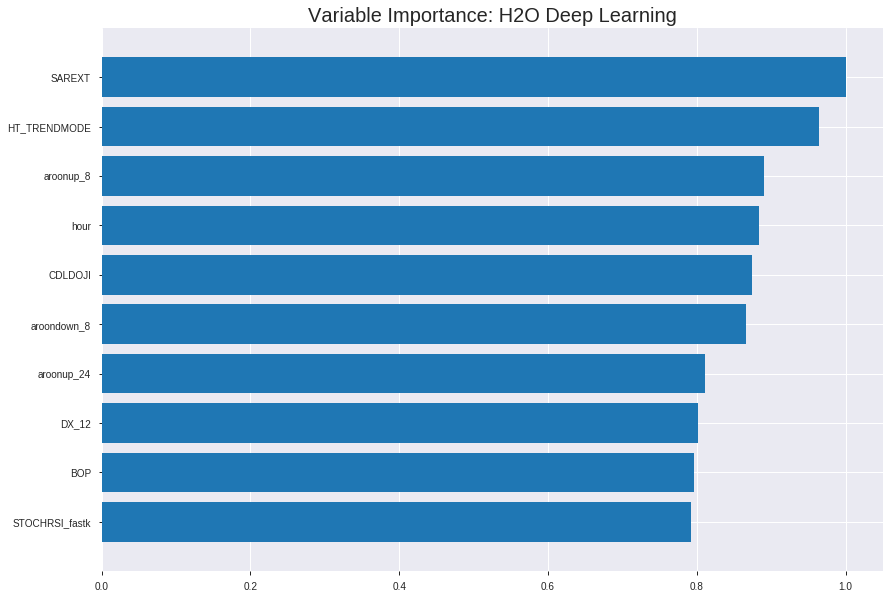

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_173813_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25940391696974346
RMSE: 0.5093171084596938
LogLoss: 0.7197892651295136
Mean Per-Class Error: 0.44241496169066263
AUC: 0.5730383969703062
pr_auc: 0.5900792371620898
Gini: 0.14607679394061246
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08405199105971774: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      1    2071  0.9995   (2071.0/2072.0)
1      0    2247  0        (0.0/2247.0)
Total  1    4318  0.4795   (2071.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.084052     0.684539  398
max f2                       0.084052     0.844356  398
max f0point5                 0.410276     0.580161  268
max accuracy                 0.563138     0.556379  178
max precision                0.96254      1         0
max recall                   0.084052     1         398
max specificity              0.96254      1         0
max absolute_mcc             0.563138     0.115249  178
max min_per_class_accuracy   0.545926     0.554537  188
max mean_per_class_accuracy  0.563138     0.557585  178

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 53.80 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.896462           1.3979    1.3979             0.727273         0.916139  0.727273                    0.916139            0.0142412       0.0142412                  39.7904   39.7904
    2        0.0201436                   0.872653           1.29631   1.34769            0.674419         0.884497  0.701149                    0.9005              0.0129061       0.0271473                  29.6312   34.7692
    3        0.0300996                   0.855288           1.16221   1.28634            0.604651         0.863125  0.669231                    0.888137            0.011571        0.0387183                  16.2211   28.6341
    4        0.0400556                   0.839375           1.34101   1.29993            0.697674         0.847077  0.676301                    0.877932            0.0133511       0.0520694                  34.1013   29.993
    5        0.0500116                   0.82396            1.38571   1.31701            0.72093          0.831015  0.685185                    0.868592            0.0137962       0.0658656                  38.5713   31.7007
    6        0.100023                    0.770611           1.22802   1.27251            0.638889         0.795608  0.662037                    0.8321              0.0614152       0.127281                   22.802    27.2514
    7        0.150035                    0.732344           1.13903   1.22802            0.592593         0.750185  0.638889                    0.804795            0.0569648       0.184246                   13.9033   22.802
    8        0.200046                    0.697437           1.09454   1.19465            0.569444         0.715732  0.621528                    0.782529            0.0547397       0.238985                   9.45396   19.465
    9        0.300069                    0.640263           1.08564   1.15831            0.564815         0.668263  0.602623                    0.74444             0.108589        0.347575                   8.56409   15.8314
    10       0.400093                    0.596048           1.00555   1.12012            0.523148         0.61853   0.582755                    0.712963            0.100579        0.448153                   0.555267  12.0123
    11       0.500116                    0.546392           1.04115   1.10433            0.541667         0.57222   0.574537                    0.684814            0.104139        0.552292                   4.11475   10.4328
    12       0.599907                    0.494065           0.95437   1.07938            0.49652          0.521305  0.561559                    0.657615            0.0952381       0.64753                    -4.56303  7.93833
    13       0.699931                    0.437986           0.898768  1.05357            0.467593         0.466902  0.548131                    0.630362            0.0898976       0.737428                   -10.1232  5.35727
    14       0.799954                    0.374703           0.880971  1.03199            0.458333         0.409662  0.536903                    0.602766            0.0881175       0.825545                   -11.9029  3.19912
    15       0.899977                    0.292294           0.880971  1.01521            0.458333         0.33725   0.528171                    0.573257            0.0881175       0.913663                   -11.9029  1.52069
    16       1                           0.0629221          0.863174  1                  0.449074         0.220524  0.520259                    0.537975            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.27883149812276536
RMSE: 0.5280449773672365
LogLoss: 0.7763563203397977
Mean Per-Class Error: 0.44630428099603514
AUC: 0.5459222415781854
pr_auc: 0.5467453233084029
Gini: 0.09184448315637073
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.016957550498775436: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    607   1        (607.0/607.0)
1      0    627   0        (0.0/627.0)
Total  0    1234  0.4919   (607.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0169576    0.673831  399
max f2                       0.0169576    0.837787  399
max f0point5                 0.139141     0.565046  368
max accuracy                 0.510711     0.553485  192
max precision                0.963807     1         0
max recall                   0.0169576    1         399
max specificity              0.963807     1         0
max absolute_mcc             0.510711     0.107409  192
max min_per_class_accuracy   0.501692     0.550247  197
max mean_per_class_accuracy  0.510711     0.553696  192

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 49.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105348                   0.894837           1.21114   1.21114            0.615385         0.918018  0.615385                    0.918018            0.0127592       0.0127592                  21.114     21.114
    2        0.0202593                   0.867128           1.14806   1.18086            0.583333         0.88481   0.6                         0.902078            0.0111643       0.0239234                  14.806     18.0861
    3        0.0299838                   0.853705           0.984051  1.11703            0.5              0.860962  0.567568                    0.888743            0.00956938      0.0334928                  -1.5949    11.7031
    4        0.0405186                   0.838452           1.36253   1.18086            0.692308         0.846325  0.6                         0.877715            0.0143541       0.0478469                  36.2532    18.0861
    5        0.0502431                   0.822439           1.31207   1.20626            0.666667         0.83039   0.612903                    0.868555            0.0127592       0.0606061                  31.2068    20.6256
    6        0.100486                    0.772928           1.11103   1.15864            0.564516         0.797645  0.58871                     0.8331              0.0558214       0.116427                   11.1025    15.8641
    7        0.149919                    0.722918           1.00018   1.10639            0.508197         0.749617  0.562162                    0.805573            0.0494418       0.165869                   0.0183021  10.6393
    8        0.200162                    0.694628           1.04754   1.09162            0.532258         0.709698  0.554656                    0.781507            0.0526316       0.218501                   4.75382    9.16194
    9        0.299838                    0.630274           1.05605   1.0798             0.536585         0.660546  0.548649                    0.741296            0.105263        0.323764                   5.60548    7.97965
    10       0.400324                    0.573995           1.14277   1.0956             0.580645         0.604519  0.55668                     0.706963            0.114833        0.438596                   14.2769    9.56034
    11       0.5                         0.50237            1.12006   1.10048            0.569106         0.537032  0.559157                    0.673087            0.111643        0.550239                   12.0058    10.0478
    12       0.599676                    0.44101            0.816042  1.0532             0.414634         0.472955  0.535135                    0.639822            0.0813397       0.631579                   -18.3958   5.32006
    13       0.700162                    0.368382           0.968179  1.041              0.491935         0.404556  0.528935                    0.606057            0.0972887       0.728868                   -3.18208   4.09984
    14       0.799838                    0.292156           0.896046  1.02293            0.455285         0.330168  0.519757                    0.571676            0.0893142       0.818182                   -10.3954   2.29345
    15       0.899514                    0.191415           0.880046  1.0071             0.447154         0.241378  0.511712                    0.535075            0.0877193       0.905901                   -11.9954   0.710088
    16       1                           0.0169576          0.936436  1                  0.475806         0.131863  0.508104                    


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:39:10  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 17:39:13  57.646 sec        4793 obs/sec      3.71591   1             16049      0.527743         0.768868            -0.115884      0.533148        0.550796           1.31054          0.479741                         0.582805           0.965524              -0.359003        0.529494          0.540957             1.36253            0.489465
    2019-08-24 17:39:19  1 min  3.468 sec  7117 obs/sec      14.869    4             64219      0.509317         0.719789            -0.039322      0.573038        0.590079           1.3979           0.479509                         0.528045           0.776356              -0.115619        0.545922          0.546745             1.21114            0.491896
    2019-08-24 17:39:25  1 min  9.274 sec  9848 obs/sec      33.4554   9             144494     0.497324         0.694322            0.00904952     0.618374        0.628677           1.61633          0.467932                         0.553026           0.883563              -0.223672        0.537008          0.544315             1.21114            0.491086
    2019-08-24 17:39:30  1 min 14.850 sec  11973 obs/sec     55.7208   15            240658     0.478028         0.650699            0.0844555      0.677758        0.684855           1.92212          0.402176                         0.559499           0.933102              -0.252486        0.560966          0.560171             1.36253            0.490276
    2019-08-24 17:39:36  1 min 20.047 sec  13419 obs/sec     77.9727   21            336764     0.458592         0.608755            0.157392       0.731504        0.739405           1.92212          0.346608                         0.554768           0.928537              -0.231391        0.55824           0.54273              1.05975            0.490276
    2019-08-24 17:39:41  1 min 25.461 sec  14791 obs/sec     103.982   28            449099     0.435061         0.555908            0.241643       0.783104        0.790616           1.92212          0.320908                         0.555998           0.971905              -0.236862        0.563835          0.552593             1.51392            0.491896
    2019-08-24 17:39:41  1 min 25.623 sec  14787 obs/sec     103.982   28            449099     0.509317         0.719789            -0.039322      0.573038        0.590079           1.3979           0.479509                         0.528045           0.776356              -0.115619        0.545922          0.546745             1.21114            0.491896

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  --------------------
SAREXT        1.0                    1.0                  0.02883438590219313
HT_TRENDMODE  0.9642571210861206     0.9642571210861206   0.02780376193833497
aroonup_8     0.8898288011550903     0.8898288011550903   0.025657667039391752
hour          0.883831262588501      0.883831262588501    0.025484731697899426
CDLDOJI       0.8748170733451843     0.8748170733451843   0.025224813086662235
---           ---                    ---                  ---
PLUS_DI_30    0.5237857103347778     0.5237857103347778   0.015103039301847332
CMO_8         0.5207943320274353     0.5207943320274353   0.015016784745353968
PLUS_DI_24    0.500144362449646      0.500144362449646    0.014421355553679443
PLUS_DM_24    0.4931162893772125     0.4931162893772125   0.014218705382560084
PLUS_DM_30    0.49058377742767334    0.49058377742767334  0.014145681955705156


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5834683954619124)

('F1', 0.7021517553793885)

('auc', 0.5707577003352097)

('logloss', 0.8048711519121783)

('mean_per_class_error', 0.41882233887799636)

('rmse', 0.539359199259762)

('mse', 0.2909083458261316)

deeplearning prediction progress: |███████████████████████████████████████| 100%


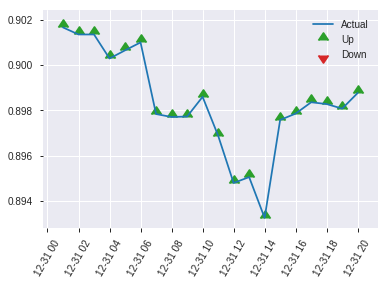


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2909083458261316
RMSE: 0.539359199259762
LogLoss: 0.8048711519121783
Mean Per-Class Error: 0.41882233887799636
AUC: 0.5707577003352097
pr_auc: 0.5583768977803101
Gini: 0.14151540067041934
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13669315360880274: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      44   247  0.8488   (247.0/291.0)
1      16   310  0.0491   (16.0/326.0)
Total  60   557  0.4263   (263.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.136693     0.702152  359
max f2                       0.0651859    0.85162   393
max f0point5                 0.136693     0.606891  359
max accuracy                 0.34122      0.583468  234
max precision                0.97436      1         0
max recall                   0.0651859    1         393
max specificity              0.97436      1         0
max absolute_mcc             0.136693     0.172058  359
max min_per_class_accuracy   0.369778     0.573883  220
max mean_per_class_accuracy  0.376075     0.581178  214

Gains/Lift Table: Avg response rate: 52.84 %, avg score: 40.71 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.89276            0.540754  0.540754           0.285714         0.922038   0.285714                    0.922038            0.00613497      0.00613497                 -45.9246  -45.9246
    2        0.0210697                   0.871611           0.31544   0.436763           0.166667         0.88175    0.230769                    0.903443            0.00306748      0.00920245                 -68.456   -56.3237
    3        0.0307942                   0.841511           1.89264   0.896513           1                0.856959   0.473684                    0.888764            0.0184049       0.0276074                  89.2638   -10.3487
    4        0.0405186                   0.830881           1.26176   0.984172           0.666667         0.836396   0.52                        0.876196            0.0122699       0.0398773                  26.1759   -1.58282
    5        0.0502431                   0.821273           1.26176   1.0379             0.666667         0.825693   0.548387                    0.866421            0.0122699       0.0521472                  26.1759   3.78983
    6        0.100486                    0.748248           0.85474   0.946319           0.451613         0.784779   0.5                         0.8256              0.0429448       0.095092                   -14.526   -5.3681
    7        0.150729                    0.67827            1.16      1.01755            0.612903         0.711892   0.537634                    0.787697            0.0582822       0.153374                   16.0004   1.75473
    8        0.200972                    0.625336           1.52632   1.14474            0.806452         0.648821   0.604839                    0.752978            0.0766871       0.230061                   52.6321   14.4741
    9        0.299838                    0.53168            0.899779  1.06397            0.47541          0.579509   0.562162                    0.69578             0.0889571       0.319018                   -10.0221  6.39695
    10       0.400324                    0.436305           1.28211   1.11873            0.677419         0.479765   0.591093                    0.641558            0.128834        0.447853                   28.211    11.8725
    11       0.50081                     0.3717             1.25158   1.14538            0.66129          0.403299   0.605178                    0.593752            0.125767        0.57362                    25.1583   14.5383
    12       0.599676                    0.306044           0.899779  1.10489            0.47541          0.339719   0.583784                    0.551871            0.0889571       0.662577                   -10.0221  10.4891
    13       0.700162                    0.246892           0.76316   1.05585            0.403226         0.278901   0.55787                     0.512694            0.0766871       0.739264                   -23.684   5.58467
    14       0.799028                    0.191717           0.961832  1.04421            0.508197         0.218923   0.551724                    0.476345            0.095092        0.834356                   -3.81676  4.42141
    15       0.899514                    0.136805           1.09895   1.05033            0.580645         0.164505   0.554955                    0.441509            0.110429        0.944785                   9.89511   5.03289
    16       1                           0.03361            0.549476  1                  0.290323         0.0989121  0.528363               

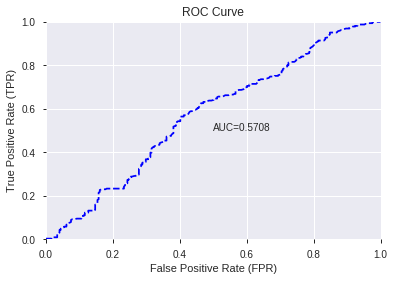

This function is available for GLM models only


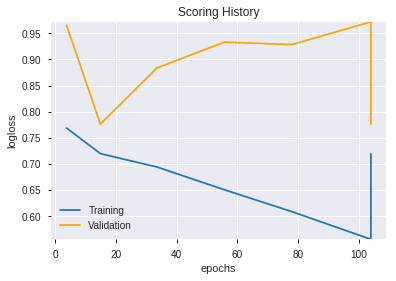

--2019-08-24 17:51:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.220
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.220|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_173813_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_173813_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_54_sid_87c2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['SAREXT',
 'HT_TRENDMODE',
 'aroonup_8',
 'hour',
 'CDLDOJI',
 'aroondown_8',
 'aroonup_24',
 'DX_12',
 'BOP',
 'STOCHRSI_fastk',
 'ULTOSC',
 'CCI_8',
 'aroondown_30',
 'aroonup_20',
 'AROONOSC_14',
 'aroondown_20',
 'aroondown_12',
 'ATR_8',
 'aroonup_30',
 'DX_30',
 'aroondown_14',
 'AROONOSC_20',
 'days_in_month',
 'AROONOSC_12',
 'WILLR_24',
 'week',
 'WILLR_8',
 'dayofyear',
 'NATR_30',
 'STOCHF_fastk',
 'dayofweek',
 'AROONOSC_30',
 'STOCHF_fastd',
 'weekday_name',
 'WILLR_14',
 'STOCH_slowd',
 'MACDFIX_signal_14',
 'STOCH_slowk',
 'WILLR_12',
 'month',
 'MINUS_DI_20',
 'MINUS_DI_24',
 'MINUS_DI_12',
 'CCI_24',
 'PLUS_DI_14',
 'PLUS_DI_30',
 'CMO_8',
 'PLUS_DI_24',
 'PLUS_DM_24',
 'PLUS_DM_30']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_175135_model_1  0.547868  0.68831              0.496379  0.497583  0.247589

variable  relative_importance  scaled_importance  percentage
0                 BOP             0.025446           1.000000    0.065004
1        aroondown_14             0.021117           0.829891    0.053946
2             WILLR_8             0.020240           0.795400    0.051704
3        STOCHF_fastk             0.019676           0.773272    0.050266
4      STOCHRSI_fastk             0.018239           0.716784    0.046594
5         AROONOSC_14             0.017031           0.669315    0.043508
6              ULTOSC             0.016989           0.667646    0.043399
7         AROONOSC_12             0.016530           0.649606    0.042227
8              SAREXT             0.015052           0.591547    0.038453
9             CDLDOJI             0.014049           0.552126    0.035890
10       aroondown_12             0.012954           0.509068    0.033091
11              DX_12             0.012239           0.480969    0.031265
12      days_in_month             0.011305           0.444289    0.028880
13            NATR_30             0.009126           0.358633    0.023312
14        MINUS_DI_24             0.009122           0.358472    0.023302
15        STOCH_slowd             0.008979           0.352876    0.022938
16  MACDFIX_signal_14             0.007740           0.304178    0.019773
17          aroonup_8             0.007575           0.297694    0.019351
18       STOCHF_fastd             0.007543           0.296427    0.019269
19        STOCH_slowk             0.007526           0.295763    0.019226
20       HT_TRENDMODE             0.007477           0.293848    0.019101
21         aroonup_24             0.007120           0.279820    0.018189
22              ATR_8             0.007105           0.279235    0.018151
23        MINUS_DI_20             0.006963           0.273651    0.017788
24         PLUS_DM_24             0.006874           0.270163    0.017562
25               hour             0.006653           0.261464    0.016996
26         PLUS_DM_30             0.006549           0.257369    0.016730
27              CMO_8             0.005270           0.207107    0.013463
28           WILLR_24             0.004388           0.172461    0.011211
29              month             0.004193           0.164791    0.010712
30         PLUS_DI_14             0.004181           0.164314    0.010681
31        AROONOSC_30             0.004000           0.157202    0.010219
32              CCI_8             0.003971           0.156051    0.010144
33         aroonup_30             0.003950           0.155248    0.010092
34          dayofyear             0.003647           0.143315    0.009316
35               week             0.003590           0.141081    0.009171
36       weekday_name             0.003296           0.129543    0.008421
37       aroondown_20             0.003105           0.122031    0.007932
38       aroondown_30             0.003084           0.121216    0.007880
39           WILLR_14             0.002616           0.102804    0.006683
40         PLUS_DI_24             0.002520           0.099015    0.006436
41             CCI_24             0.002353           0.092471    0.006011
42          dayofweek             0.002309           0.090745    0.005899
43        MINUS_DI_12             0.001592           0.062550    0.004066
44           WILLR_12             0.001546           0.060772    0.003950
45        AROONOSC_20             0.001413           0.055512    0.003609
46              DX_30             0.001106           0.043459    0.002825
47         aroonup_20             0.000880           0.034597    0.002249
48         PLUS_DI_30             0.000871           0.034249    0.002226
49        aroondown_8             0.000348           0.013685    0.000890

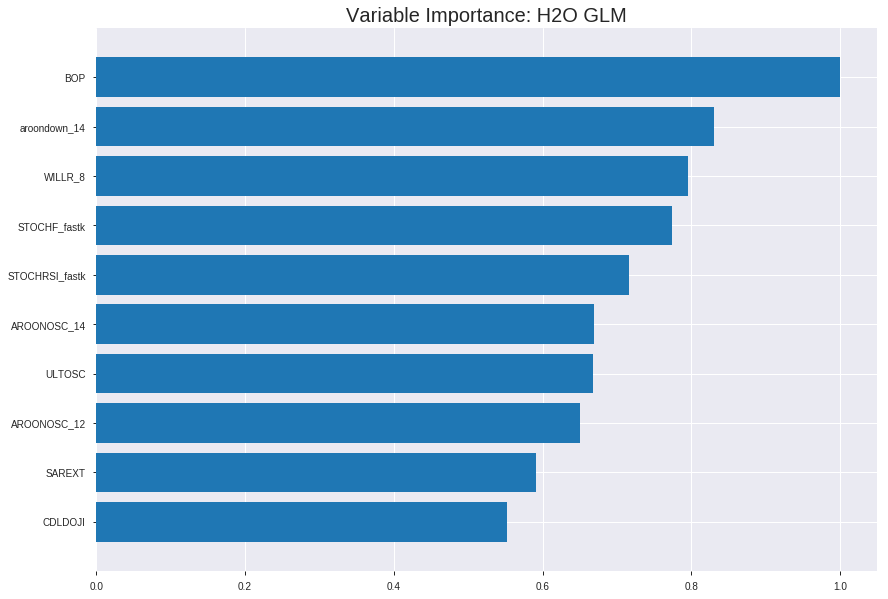

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_175135_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24762268477797073
RMSE: 0.4976170061181297
LogLoss: 0.6883783119204075
Null degrees of freedom: 4318
Residual degrees of freedom: 4268
Null deviance: 5980.312642429541
Residual deviance: 5946.2118583684805
AIC: 6048.2118583684805
AUC: 0.5566872303354279
pr_auc: 0.5668054450478214
Gini: 0.11337446067085577
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45468808470276706: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      16   2056  0.9923   (2056.0/2072.0)
1      6    2241  0.0027   (6.0/2247.0)
Total  22   4297  0.4774   (2062.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.454688     0.684902   389
max f2                       0.447862     0.844419   397
max f0point5                 0.492695     0.579104   298
max accuracy                 0.513383     0.54897    223
max precision                0.593431     1          0
max recall                   0.447862     1          397
max specificity              0.593431     1          0
max absolute_mcc             0.527765     0.0926231  168
max min_per_class_accuracy   0.521104     0.542471   193
max mean_per_class_accuracy  0.524263     0.545754   181

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 52.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.577193           1.31054   1.31054            0.681818         0.582036  0.681818                    0.582036            0.0133511       0.0133511                  31.0535   31.0535
    2        0.0201436                   0.572806           1.11751   1.21513            0.581395         0.574976  0.632184                    0.578546            0.0111259       0.0244771                  11.7511   21.5132
    3        0.0300996                   0.569481           1.07281   1.16806            0.55814          0.570813  0.607692                    0.575989            0.0106809       0.035158                   7.28103   16.8057
    4        0.0400556                   0.56695            1.25161   1.18882            0.651163         0.568046  0.618497                    0.574014            0.0124611       0.047619                   25.1612   18.8825
    5        0.0500116                   0.564378           1.07281   1.16573            0.55814          0.565722  0.606481                    0.572364            0.0106809       0.0583                     7.28103   16.5729
    6        0.100023                    0.555878           1.15683   1.16128            0.601852         0.560013  0.604167                    0.566189            0.0578549       0.116155                   15.6831   16.128
    7        0.150035                    0.549865           1.04115   1.12124            0.541667         0.552859  0.583333                    0.561745            0.0520694       0.168224                   4.11475   12.1236
    8        0.200046                    0.54492            1.13903   1.12569            0.592593         0.547432  0.585648                    0.558167            0.0569648       0.225189                   13.9033   12.5685
    9        0.300069                    0.537077           1.13013   1.12717            0.587963         0.540796  0.58642                     0.552377            0.11304         0.338229                   13.0134   12.7168
    10       0.400093                    0.528993           1.0011    1.09565            0.520833         0.532959  0.570023                    0.547522            0.100134        0.438362                   0.110332  9.5652
    11       0.500116                    0.521087           1.0278    1.08208            0.534722         0.525063  0.562963                    0.543031            0.102804        0.541166                   2.77994   8.20815
    12       0.599907                    0.512896           1.01235   1.07048            0.526682         0.517014  0.556928                    0.538703            0.101024        0.64219                    1.23454   7.04812
    13       0.699931                    0.504263           0.872072  1.04213            0.453704         0.508801  0.542177                    0.53443             0.0872274       0.729417                   -12.7928  4.21277
    14       0.799954                    0.495142           0.965509  1.03255            0.502315         0.499526  0.537192                    0.530066            0.0965732       0.82599                    -3.44915  3.25475
    15       0.899977                    0.48325            0.88542   1.0162             0.460648         0.489796  0.528685                    0.52559             0.0885625       0.914553                   -11.458   1.61959
    16       1                           0.4409             0.854275  1                  0.444444         0.472296  0.520259                    0.520259           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24874244918262345
RMSE: 0.4987408637585489
LogLoss: 0.6906237678503182
Null degrees of freedom: 1233
Residual degrees of freedom: 1183
Null deviance: 1711.0932050440474
Residual deviance: 1704.4594590545853
AIC: 1806.4594590545853
AUC: 0.5537627204149358
pr_auc: 0.5482612318951429
Gini: 0.10752544082987159
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4652803077689204: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    602   0.9918   (602.0/607.0)
1      1    626   0.0016   (1.0/627.0)
Total  6    1228  0.4887   (603.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46528      0.674933  394
max f2                       0.457593     0.838011  398
max f0point5                 0.51623      0.569462  250
max accuracy                 0.54362      0.547812  136
max precision                0.594572     1         0
max recall                   0.457593     1         398
max specificity              0.594572     1         0
max absolute_mcc             0.54362      0.106291  136
max min_per_class_accuracy   0.531375     0.537068  188
max mean_per_class_accuracy  0.54362      0.5504    136

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 52.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105348                   0.585437           1.05975   1.05975            0.538462         0.589773  0.538462                    0.589773            0.0111643       0.0111643                  5.97473    5.97473
    2        0.0202593                   0.579676           1.31207   1.18086            0.666667         0.58267   0.6                         0.586364            0.0127592       0.0239234                  31.2068    18.0861
    3        0.0299838                   0.575894           1.31207   1.22341            0.666667         0.578256  0.621622                    0.583734            0.0127592       0.0366826                  31.2068    22.3415
    4        0.0405186                   0.573296           1.05975   1.18086            0.538462         0.574576  0.6                         0.581353            0.0111643       0.0478469                  5.97473    18.0861
    5        0.0502431                   0.571523           0.820043  1.11103            0.416667         0.572401  0.564516                    0.57962             0.00797448      0.0558214                  -17.9957   11.1025
    6        0.100486                    0.564532           1.04754   1.07928            0.532258         0.567593  0.548387                    0.573607            0.0526316       0.108453                   4.75382    7.92818
    7        0.149919                    0.558577           1.22603   1.12767            0.622951         0.561116  0.572973                    0.569488            0.0606061       0.169059                   22.6031    12.7669
    8        0.200162                    0.55334            1.17451   1.13943            0.596774         0.55603   0.578947                    0.56611             0.0590112       0.22807                    17.4513    13.9428
    9        0.299838                    0.546153           1.13606   1.13831            0.577236         0.549643  0.578378                    0.560636            0.113238        0.341308                   13.6059    13.8308
    10       0.400324                    0.538841           1.03167   1.11154            0.524194         0.542684  0.564777                    0.55613             0.103668        0.444976                   3.16664    11.1539
    11       0.5                         0.531431           0.928048  1.07496            0.471545         0.535092  0.546191                    0.551936            0.092504        0.53748                    -7.19519   7.49601
    12       0.599676                    0.523631           0.992051  1.06118            0.504065         0.527395  0.539189                    0.547857            0.0988836       0.636364                   -0.794855  6.11794
    13       0.700162                    0.51448            1.03167   1.05694            0.524194         0.518763  0.537037                    0.543681            0.103668        0.740032                   3.16664    5.69437
    14       0.799838                    0.506313           0.848044  1.03091            0.430894         0.510243  0.52381                     0.539514            0.0845295       0.824561                   -15.1956   3.09106
    15       0.899514                    0.493462           0.784041  1.00355            0.398374         0.499288  0.50991                     0.535057            0.0781499       0.902711                   -21.5959   0.355475
    16       1                           0.454075           0.968179  1                  0.491935         0.4822    0.508104                   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 17:51:36  0.000 sec   2            3.3       51            1.38156           1.38329
    2019-08-24 17:51:36  0.026 sec   4            2         51            1.38051           1.38252
    2019-08-24 17:51:36  0.050 sec   6            1.3       51            1.37932           1.38186
    2019-08-24 17:51:36  0.089 sec   8            0.78      51            1.37806           1.38142
    2019-08-24 17:51:36  0.118 sec   10           0.49      51            1.37676           1.38125
    2019-08-24 17:51:36  0.148 sec   12           0.3       51            1.37546           1.38135
    2019-08-24 17:51:36  0.177 sec   14           0.19      51            1.37418           1.38168
    2019-08-24 17:51:36  0.203 sec   16           0.12      51            1.37295           1.38215
    2019-08-24 17:51:36  0.232 sec   18           0.072     51            1.37181           1.38276
    2019-08-24 17:51:36  0.275 sec   20           0.045     51            1.37079           1.38352

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5575364667747164)

('F1', 0.6922257720979765)

('auc', 0.5478675183943669)

('logloss', 0.6883096790735302)

('mean_per_class_error', 0.4507305040794384)

('rmse', 0.4975834234583104)

('mse', 0.24758926330049225)

glm prediction progress: |████████████████████████████████████████████████| 100%


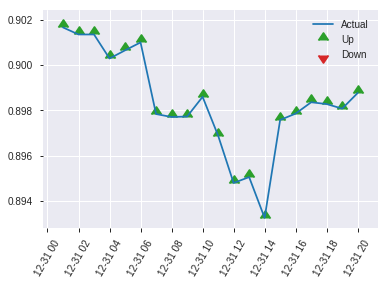


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24758926330049225
RMSE: 0.4975834234583104
LogLoss: 0.6883096790735302
Null degrees of freedom: 616
Residual degrees of freedom: 566
Null deviance: 853.5195608018752
Residual deviance: 849.3741439767363
AIC: 951.3741439767363
AUC: 0.5478675183943669
pr_auc: 0.5637639022501827
Gini: 0.09573503678873374
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4683321608949044: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    288  0.9897   (288.0/291.0)
1      1    325  0.0031   (1.0/326.0)
Total  4    613  0.4684   (289.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.468332     0.692226  395
max f2                       0.458469     0.848958  398
max f0point5                 0.491535     0.596348  353
max accuracy                 0.498173     0.557536  330
max precision                0.601721     1         0
max recall                   0.458469     1         398
max specificity              0.601721     1         0
max absolute_mcc             0.491535     0.114624  353
max min_per_class_accuracy   0.529295     0.546392  204
max mean_per_class_accuracy  0.529178     0.549269  205

Gains/Lift Table: Avg response rate: 52.84 %, avg score: 52.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.588504           1.08151   1.08151            0.571429         0.592659  0.571429                    0.592659            0.0122699       0.0122699                  8.15074   8.15074
    2        0.0210697                   0.582619           1.26176   1.1647             0.666667         0.585138  0.615385                    0.589188            0.0122699       0.0245399                  26.1759   16.47
    3        0.0307942                   0.579642           0.946319  1.09574            0.5              0.580877  0.578947                    0.586563            0.00920245      0.0337423                  -5.3681   9.57378
    4        0.0405186                   0.576674           1.26176   1.13558            0.666667         0.578305  0.6                         0.584581            0.0122699       0.0460123                  26.1759   13.5583
    5        0.0502431                   0.575004           1.26176   1.16               0.666667         0.575816  0.612903                    0.582885            0.0122699       0.0582822                  26.1759   16.0004
    6        0.100486                    0.566844           1.0379    1.09895            0.548387         0.570405  0.580645                    0.576645            0.0521472       0.110429                   3.78983   9.89511
    7        0.150729                    0.560669           1.0379    1.0786             0.548387         0.563904  0.569892                    0.572398            0.0521472       0.162577                   3.78983   7.86002
    8        0.200972                    0.554642           1.22106   1.11421            0.645161         0.557022  0.58871                     0.568554            0.0613497       0.223926                   22.1057   11.4214
    9        0.299838                    0.54589            1.05491   1.09466            0.557377         0.549585  0.578378                    0.562299            0.104294        0.328221                   5.4913    9.46609
    10       0.400324                    0.537379           1.0379    1.08041            0.548387         0.541652  0.57085                     0.557116            0.104294        0.432515                   3.78983   8.04128
    11       0.50081                     0.529316           1.09895   1.08413            0.580645         0.533334  0.572816                    0.552345            0.110429        0.542945                   9.89511   8.41325
    12       0.599676                    0.520001           0.961832  1.06397            0.508197         0.525004  0.562162                    0.547837            0.095092        0.638037                   -3.81676  6.39695
    13       0.700162                    0.511346           0.793687  1.02518            0.419355         0.515305  0.541667                    0.543168            0.0797546       0.717791                   -20.6313  2.51789
    14       0.799028                    0.503221           0.992859  1.02118            0.52459          0.507026  0.539554                    0.538696            0.0981595       0.815951                   -0.71407  2.118
    15       0.899514                    0.492417           1.12948   1.03328            0.596774         0.498096  0.545946                    0.534161            0.113497        0.929448                   12.9478   3.32781
    16       1                           0.455365           0.702108  1                  0.370968         0.482651  0.528363                    0.528985            0

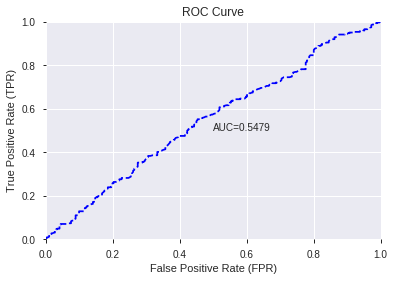

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


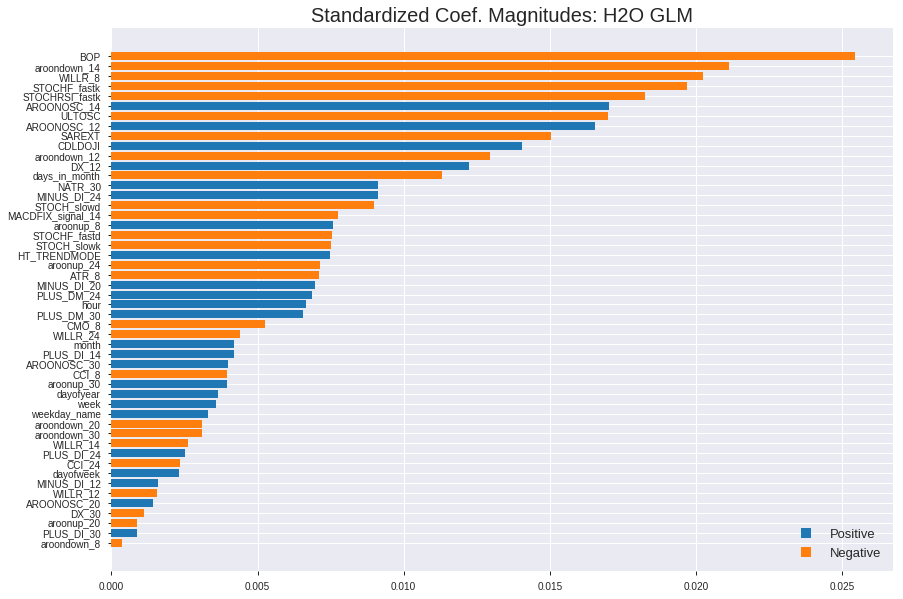

'log_likelihood'
--2019-08-24 17:51:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_175135_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_175135_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_62_sid_87c2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_62_s

['BOP',
 'aroondown_14',
 'WILLR_8',
 'STOCHF_fastk',
 'STOCHRSI_fastk',
 'AROONOSC_14',
 'ULTOSC',
 'AROONOSC_12',
 'SAREXT',
 'CDLDOJI',
 'aroondown_12',
 'DX_12',
 'days_in_month',
 'NATR_30',
 'MINUS_DI_24',
 'STOCH_slowd',
 'MACDFIX_signal_14',
 'aroonup_8',
 'STOCHF_fastd',
 'STOCH_slowk',
 'HT_TRENDMODE',
 'aroonup_24',
 'ATR_8',
 'MINUS_DI_20',
 'PLUS_DM_24',
 'hour',
 'PLUS_DM_30',
 'CMO_8',
 'WILLR_24',
 'month',
 'PLUS_DI_14',
 'AROONOSC_30',
 'CCI_8',
 'aroonup_30',
 'dayofyear',
 'week',
 'weekday_name',
 'aroondown_20',
 'aroondown_30',
 'WILLR_14',
 'PLUS_DI_24',
 'CCI_24',
 'dayofweek',
 'MINUS_DI_12',
 'WILLR_12',
 'AROONOSC_20',
 'DX_30',
 'aroonup_20',
 'PLUS_DI_30',
 'aroondown_8']

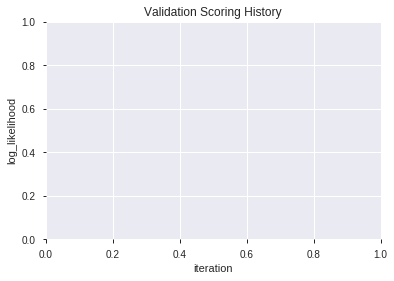

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_175149_model_2  0.581304  0.681308              0.498282  0.494191  0.244225
1  XGBoost_grid_1_AutoML_20190824_175149_model_3  0.576171  0.681214              0.489691  0.494175  0.244209
2               XGBoost_3_AutoML_20190824_175149  0.564628  0.682448              0.486070  0.494846  0.244872
3               XGBoost_1_AutoML_20190824_175149  0.561766  0.687398              0.478275  0.497262  0.247269
4  XGBoost_grid_1_AutoML_20190824_175149_model_4  0.559732  0.685180              0.491040  0.496120  0.246135
5  XGBoost_grid_1_AutoML_20190824_175149_model_5  0.556469  0.696292              0.481342  0.501422  0.251424
6  XGBoost_grid_1_AutoML_20190824_175149_model_1  0.555974  0.683539              0.489322  0.495415  0.245436
7               XGBoost_2_AutoML_20190824_175149  0.554387  0.688162              0.494845  0.497647  0.247652
8  XGBoost_grid_1_AutoML_20190824_175149_model_7  0.548279  0.692535              0.482080  0.499784  0.249784
9  XGBoost_grid_1_AutoML_20190824_175149_model_6  0.544099  0.686302              0.479993  0.496683  0.246694

variable  relative_importance  scaled_importance  percentage
0                hour           405.774445           1.000000    0.058119
1                 BOP           357.511597           0.881060    0.051206
2              SAREXT           317.968231           0.783608    0.045542
3               ATR_8           299.990051           0.739302    0.042967
4           dayofyear           258.151398           0.636194    0.036975
5               DX_30           243.350555           0.599719    0.034855
6              ULTOSC           243.204300           0.599358    0.034834
7        STOCHF_fastk           232.039413           0.571843    0.033235
8         STOCH_slowd           231.645432           0.570872    0.033178
9             WILLR_8           217.902252           0.537003    0.031210
10              CCI_8           205.765411           0.507093    0.029472
11     STOCHRSI_fastk           205.463776           0.506350    0.029428
12           WILLR_12           204.842346           0.504818    0.029339
13            NATR_30           201.575333           0.496767    0.028872
14  MACDFIX_signal_14           197.835754           0.487551    0.028336
15         PLUS_DM_24           173.805756           0.428331    0.024894
16              DX_12           170.898575           0.421166    0.024478
17        STOCH_slowk           159.509628           0.393099    0.022846
18         PLUS_DI_14           157.480087           0.388098    0.022556
19        AROONOSC_30           156.429916           0.385510    0.022405
20           WILLR_14           154.843613           0.381600    0.022178
21        AROONOSC_14           151.256653           0.372760    0.021664
22         PLUS_DM_30           148.793549           0.366690    0.021312
23        MINUS_DI_24           135.588135           0.334147    0.019420
24           WILLR_24           122.898773           0.302875    0.017603
25         PLUS_DI_30           122.152374           0.301035    0.017496
26             CCI_24           111.569756           0.274955    0.015980
27       aroondown_14           110.612747           0.272597    0.015843
28        AROONOSC_20           109.216438           0.269156    0.015643
29        MINUS_DI_12           107.259216           0.264332    0.015363
30              CMO_8           107.157661           0.264082    0.015348
31          dayofweek           102.617767           0.252894    0.014698
32       aroondown_30            98.911964           0.243761    0.014167
33       aroondown_20            92.919159           0.228992    0.013309
34          aroonup_8            83.195847           0.205030    0.011916
35         aroonup_30            83.004692           0.204559    0.011889
36         aroonup_20            79.926468           0.196973    0.011448
37         aroonup_24            76.051186           0.187422    0.010893
38        MINUS_DI_20            70.738884           0.174331    0.010132
39        aroondown_8            61.175964           0.150763    0.008762
40         PLUS_DI_24            54.273731           0.133753    0.007774
41        AROONOSC_12            36.044552           0.088829    0.005163
42       aroondown_12            34.445999           0.084890    0.004934
43       HT_TRENDMODE            28.750977           0.070855    0.004118
44      days_in_month            21.001017           0.051755    0.003008
45       STOCHF_fastd            15.339673           0.037803    0.002197
46            CDLDOJI             6.825489           0.016821    0.000978
47              month             5.149802           0.012691    0.000738
48               week             4.523533           0.011148    0.000648
49       weekday_name             4.418165           0.010888    0.000633

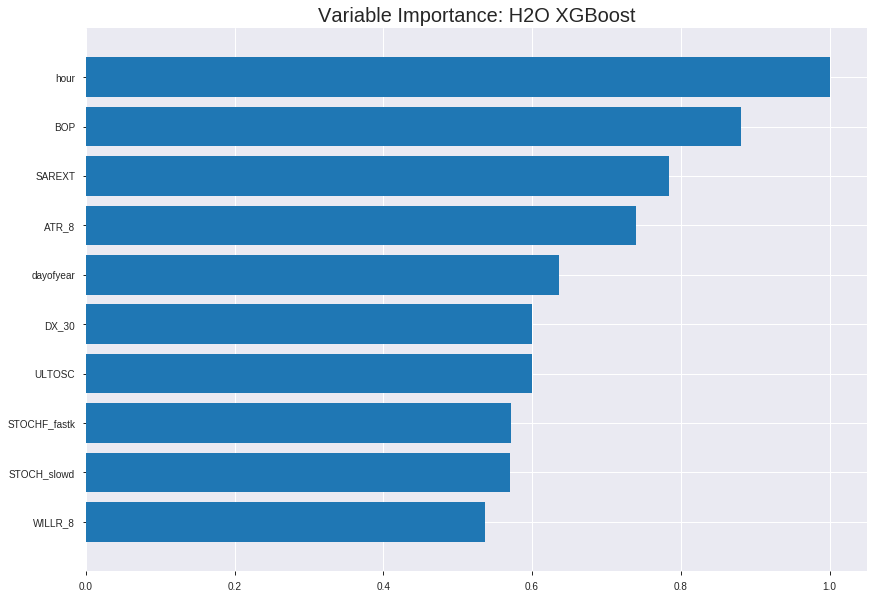

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_175149_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2170122286486319
RMSE: 0.4658457133522127
LogLoss: 0.6261999651179866
Mean Per-Class Error: 0.24309214087251463
AUC: 0.8341121495327103
pr_auc: 0.8452742075381043
Gini: 0.6682242990654206
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49787120521068573: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      1331  741   0.3576   (741.0/2072.0)
1      346   1901  0.154    (346.0/2247.0)
Total  1677  2642  0.2517   (1087.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.497871     0.777664  229
max f2                       0.449194     0.861756  301
max f0point5                 0.535735     0.780206  169
max accuracy                 0.507338     0.757583  214
max precision                0.752275     1         0
max recall                   0.371663     1         378
max specificity              0.752275     1         0
max absolute_mcc             0.506679     0.514305  215
max min_per_class_accuracy   0.514103     0.752559  203
max mean_per_class_accuracy  0.515355     0.756908  201

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 51.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.681545           1.92212   1.92212            1                0.700721  1                           0.700721            0.0195817       0.0195817                  92.2118   92.2118
    2        0.0201436                   0.658558           1.87742   1.90003            0.976744         0.668637  0.988506                    0.684863            0.0186916       0.0382733                  87.7418   90.0025
    3        0.0300996                   0.644598           1.92212   1.90733            1                0.651299  0.992308                    0.673761            0.0191366       0.0574099                  92.2118   90.7333
    4        0.0400556                   0.633996           1.92212   1.91101            1                0.638958  0.99422                     0.665111            0.0191366       0.0765465                  92.2118   91.1008
    5        0.0500116                   0.625597           1.74332   1.87762            0.906977         0.629777  0.976852                    0.658077            0.0173565       0.093903                   74.3317   87.7625
    6        0.100023                    0.602103           1.81533   1.84648            0.944444         0.612991  0.960648                    0.635534            0.0907877       0.184691                   81.5334   84.6479
    7        0.150035                    0.584496           1.66406   1.78567            0.865741         0.592481  0.929012                    0.621183            0.0832221       0.267913                   66.4056   78.5672
    8        0.200046                    0.572075           1.64626   1.75082            0.856481         0.578374  0.91088                     0.610481            0.082332        0.350245                   64.6259   75.0818
    9        0.300069                    0.550559           1.48608   1.66257            0.773148         0.560954  0.864969                    0.593972            0.148643        0.498887                   48.6082   66.2573
    10       0.400093                    0.53215            1.3437    1.58286            0.699074         0.541474  0.823495                    0.580847            0.134401        0.633289                   34.3703   58.2856
    11       0.500116                    0.514875           1.13458   1.4932             0.590278         0.523093  0.776852                    0.569297            0.113485        0.746773                   13.4584   49.3201
    12       0.599907                    0.499571           0.900854  1.39467            0.468677         0.507179  0.725589                    0.558964            0.0898976       0.836671                   -9.91464  39.4667
    13       0.699931                    0.481745           0.654054  1.28883            0.340278         0.490569  0.670526                    0.54919             0.0654206       0.902092                   -34.5946  28.883
    14       0.799954                    0.461976           0.493878  1.18943            0.256944         0.472379  0.618813                    0.539586            0.0493992       0.951491                   -50.6122  18.9432
    15       0.899977                    0.433746           0.324802  1.09334            0.168981         0.44902   0.568819                    0.52952             0.0324878       0.983979                   -67.5198  9.33377
    16       1                           0.30312            0.160177  1                  0.0833333        0.403942  0.520259                    0.516959          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24598779097933324
RMSE: 0.49597156267202785
LogLoss: 0.6849784445779117
Mean Per-Class Error: 0.4441733733765295
AUC: 0.5678251341998849
pr_auc: 0.5718690320397484
Gini: 0.1356502683997698
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3926590383052826: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      13   594   0.9786   (594.0/607.0)
1      5    622   0.008    (5.0/627.0)
Total  18   1216  0.4854   (599.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.392659     0.674986  386
max f2                       0.361687     0.838235  397
max f0point5                 0.464665     0.580099  304
max accuracy                 0.495482     0.558347  251
max precision                0.708343     1         0
max recall                   0.361687     1         397
max specificity              0.708343     1         0
max absolute_mcc             0.464665     0.118904  304
max min_per_class_accuracy   0.519052     0.54201   207
max mean_per_class_accuracy  0.495482     0.555827  251

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 51.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.683724           1.9681    1.9681             1                0.693948  1                           0.693948            0.0207337       0.0207337                  96.8102   96.8102
    2        0.0202593                   0.662178           1.31207   1.65321            0.666667         0.67284   0.84                        0.683816            0.0127592       0.0334928                  31.2068   65.3206
    3        0.0299838                   0.649574           1.14806   1.48937            0.583333         0.656407  0.756757                    0.674927            0.0111643       0.0446571                  14.806    48.9375
    4        0.0405186                   0.6333             1.05975   1.37767            0.538462         0.639728  0.7                         0.665775            0.0111643       0.0558214                  5.97473   37.7671
    5        0.0502431                   0.625217           0.820043  1.26974            0.416667         0.629754  0.645161                    0.658803            0.00797448      0.0637959                  -17.9957  26.9743
    6        0.100486                    0.597997           1.04754   1.15864            0.532258         0.609278  0.58871                     0.634041            0.0526316       0.116427                   4.75382   15.8641
    7        0.149919                    0.581618           1.03245   1.11703            0.52459          0.588162  0.567568                    0.618913            0.0510367       0.167464                   3.2447    11.7031
    8        0.200162                    0.568756           0.984051  1.08365            0.5              0.574319  0.550607                    0.60772             0.0494418       0.216906                   -1.5949   8.36513
    9        0.299838                    0.549384           1.16806   1.11171            0.593496         0.559053  0.564865                    0.591541            0.116427        0.333333                   16.8061   11.1712
    10       0.400324                    0.532649           1.19038   1.13146            0.604839         0.541071  0.574899                    0.578873            0.119617        0.452951                   19.0384   13.1459
    11       0.5                         0.519059           0.880046  1.08134            0.447154         0.525639  0.549433                    0.56826             0.0877193       0.54067                    -11.9954  8.13397
    12       0.599676                    0.504584           1.08806   1.08246            0.552846         0.511379  0.55                        0.558806            0.108453        0.649123                   8.80564   8.24561
    13       0.700162                    0.487769           0.984051  1.06833            0.5              0.496298  0.542824                    0.549835            0.0988836       0.748006                   -1.5949   6.83332
    14       0.799838                    0.468735           0.912047  1.04886            0.463415         0.477811  0.532928                    0.540859            0.0909091       0.838915                   -8.79527  4.88568
    15       0.899514                    0.44141            0.912047  1.0337             0.463415         0.455543  0.525225                    0.531405            0.0909091       0.929825                   -8.79527  3.36969
    16       1                           0.35762            0.698359  1                  0.354839         0.417102  0.508104                    0.519919         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:51:57  1.034 sec   0                  0.5              0.693147            0.5             0                  1                0.479741                         0.5                0.693147              0.5               0                    1                  0.491896
    2019-08-24 17:51:57  1.138 sec   5                  0.495196         0.683579            0.703119        0.709974           1.61633          0.402639                         0.499047           0.691242              0.545562          0.548825             1.26521            0.487034
    2019-08-24 17:51:57  1.232 sec   10                 0.490932         0.675139            0.733505        0.746491           1.87843          0.367909                         0.498139           0.689422              0.553932          0.563755             1.51392            0.485413
    2019-08-24 17:51:57  1.332 sec   15                 0.486837         0.667073            0.757225        0.77084            1.87843          0.322528                         0.497212           0.687558              0.563244          0.568474             1.51392            0.487844
    2019-08-24 17:51:57  1.451 sec   20                 0.483277         0.660084            0.771265        0.788974           1.87843          0.332716                         0.496682           0.686486              0.566916          0.575882             1.81671            0.491086
    2019-08-24 17:51:57  1.561 sec   25                 0.48003          0.653734            0.783657        0.799221           1.92212          0.310025                         0.496933           0.686985              0.562728          0.567444             1.81671            0.485413
    2019-08-24 17:51:57  1.653 sec   30                 0.476784         0.647383            0.79319         0.809668           1.92212          0.318592                         0.496875           0.686852              0.561552          0.565618             1.81671            0.486224
    2019-08-24 17:51:58  1.742 sec   35                 0.473946         0.641852            0.806495        0.822411           1.92212          0.273211                         0.496255           0.685588              0.567057          0.56931              1.9681             0.47893
    2019-08-24 17:51:58  1.830 sec   40                 0.471219         0.636553            0.814974        0.828465           1.92212          0.276221                         0.495945           0.684948              0.569449          0.572298             1.81671            0.484603
    2019-08-24 17:51:58  1.918 sec   45                 0.468447         0.631183            0.824692        0.836594           1.92212          0.268118                         0.495925           0.684883              0.569321          0.574049             1.9681             0.488655
    2019-08-24 17:51:58  2.013 sec   50                 0.465846         0.6262              0.834112        0.845274           1.92212          0.251679                         0.495972           0.684978              0.567825          0.571869             1.9681             0.485413

Variable Importances: 


variable      relative_importance    scaled_importance     percentage
------------  ---------------------  --------------------  ---------------------
hour          405.7744445800781      1.0                   0.058118819974291615
BOP           357.5115966796875      0.8810599126065315    0.05120616244734411
SAREXT        317.9682312011719      0.7836083209484179    0.04554239093555803
ATR_8         299.99005126953125     0.7393024752457749    0.04296738746535737
dayofyear     258.1513977050781      0.6361943221245242    0.036974863276221716
---           ---                    ---                   ---
STOCHF_fastd  15.339673042297363     0.037803447819814914  0.0021970917782473502
CDLDOJI       6.825489044189453      0.016820894305586233  0.0009776105279529533
month         5.149801731109619      0.012691291430240191  0.0007376028818753997
week          4.523532867431641      0.011147899843995567  0.0006479027841246119
weekday_name  4.41816520690918       0.010888229325238521  0.0006328110399923403


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737439222042139)

('F1', 0.6921443736730362)

('auc', 0.5813041553348934)

('logloss', 0.6813077210440536)

('mean_per_class_error', 0.4190542449349609)

('rmse', 0.49419078084705476)

('mse', 0.2442245278742217)

xgboost prediction progress: |████████████████████████████████████████████| 100%


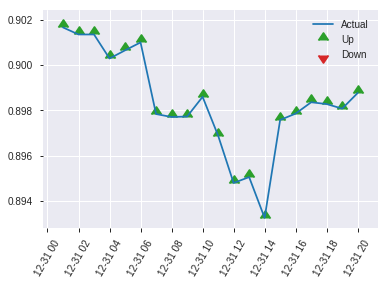


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2442245278742217
RMSE: 0.49419078084705476
LogLoss: 0.6813077210440536
Mean Per-Class Error: 0.4190542449349609
AUC: 0.5813041553348934
pr_auc: 0.6138078887957091
Gini: 0.16260831066978687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36666107177734375: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    290  0.9966   (290.0/291.0)
1      0    326  0        (0.0/326.0)
Total  1    616  0.47     (290.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.366661     0.692144  398
max f2                       0.366661     0.848958  398
max f0point5                 0.498881     0.595808  221
max accuracy                 0.522515     0.573744  168
max precision                0.734893     1         0
max recall                   0.366661     1         398
max specificity              0.734893     1         0
max absolute_mcc             0.522515     0.1667    168
max min_per_class_accuracy   0.503946     0.56701   209
max mean_per_class_accuracy  0.522515     0.580946  168

Gains/Lift Table: Avg response rate: 52.84 %, avg score: 51.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.707895           1.89264   1.89264            1                0.715634  1                           0.715634            0.0214724       0.0214724                  89.2638   89.2638
    2        0.0210697                   0.672149           1.5772    1.74705            0.833333         0.685744  0.923077                    0.701839            0.0153374       0.0368098                  57.7198   74.705
    3        0.0307942                   0.639874           1.26176   1.5938             0.666667         0.649315  0.842105                    0.685252            0.0122699       0.0490798                  26.1759   59.38
    4        0.0405186                   0.629705           1.26176   1.51411            0.666667         0.634677  0.8                         0.673114            0.0122699       0.0613497                  26.1759   51.411
    5        0.0502431                   0.618346           0.946319  1.40422            0.5              0.622899  0.741935                    0.663395            0.00920245      0.0705521                  -5.3681   40.4215
    6        0.100486                    0.596234           0.915793  1.16               0.483871         0.610069  0.612903                    0.636732            0.0460123       0.116564                   -8.42074  16.0004
    7        0.150729                    0.575555           1.34316   1.22106            0.709677         0.585579  0.645161                    0.619681            0.0674847       0.184049                   34.3162   22.1057
    8        0.200972                    0.560572           1.34316   1.25158            0.709677         0.566181  0.66129                     0.606306            0.0674847       0.251534                   34.3162   25.1583
    9        0.299838                    0.535388           1.17902   1.22766            0.622951         0.547236  0.648649                    0.586829            0.116564        0.368098                   17.902    22.7657
    10       0.400324                    0.517916           1.0379    1.18003            0.548387         0.526654  0.623482                    0.571724            0.104294        0.472393                   3.78983   18.0025
    11       0.50081                     0.504479           0.915793  1.12701            0.483871         0.51059   0.595469                    0.559458            0.0920245       0.564417                   -8.42074  12.7008
    12       0.599676                    0.489609           0.899779  1.08955            0.47541          0.497026  0.575676                    0.549165            0.0889571       0.653374                   -10.0221  8.95457
    13       0.700162                    0.475063           0.732634  1.03832            0.387097         0.482394  0.548611                    0.539582            0.0736196       0.726994                   -26.7366  3.83223
    14       0.799028                    0.460019           0.961832  1.02886            0.508197         0.468107  0.543611                    0.530738            0.095092        0.822086                   -3.81676  2.8858
    15       0.899514                    0.434717           0.885266  1.01282            0.467742         0.448863  0.535135                    0.521592            0.0889571       0.911043                   -11.4734  1.28171
    16       1                           0.356553           0.885266  1                  0.467742         0.411133  0.528363                    0.510492            0.

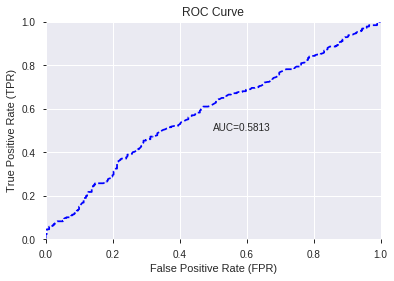

This function is available for GLM models only


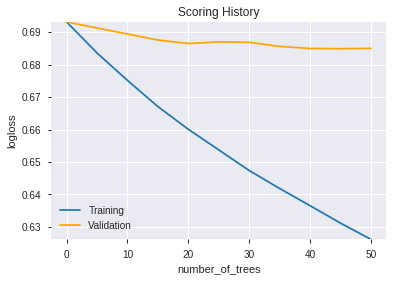

--2019-08-24 17:52:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_175149_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_175149_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_70_sid_87c2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['hour',
 'BOP',
 'SAREXT',
 'ATR_8',
 'dayofyear',
 'DX_30',
 'ULTOSC',
 'STOCHF_fastk',
 'STOCH_slowd',
 'WILLR_8',
 'CCI_8',
 'STOCHRSI_fastk',
 'WILLR_12',
 'NATR_30',
 'MACDFIX_signal_14',
 'PLUS_DM_24',
 'DX_12',
 'STOCH_slowk',
 'PLUS_DI_14',
 'AROONOSC_30',
 'WILLR_14',
 'AROONOSC_14',
 'PLUS_DM_30',
 'MINUS_DI_24',
 'WILLR_24',
 'PLUS_DI_30',
 'CCI_24',
 'aroondown_14',
 'AROONOSC_20',
 'MINUS_DI_12',
 'CMO_8',
 'dayofweek',
 'aroondown_30',
 'aroondown_20',
 'aroonup_8',
 'aroonup_30',
 'aroonup_20',
 'aroonup_24',
 'MINUS_DI_20',
 'aroondown_8',
 'PLUS_DI_24',
 'AROONOSC_12',
 'aroondown_12',
 'HT_TRENDMODE',
 'days_in_month',
 'STOCHF_fastd',
 'CDLDOJI',
 'month',
 'week',
 'weekday_name']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [12] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


3

['BOP', 'WILLR_8', 'STOCHF_fastk']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_175224_model_4  0.555953  0.687932              0.500000  0.497395  0.247402
1  DeepLearning_grid_1_AutoML_20190824_175224_model_3  0.553439  0.688595              0.498097  0.497674  0.247679
2  DeepLearning_grid_1_AutoML_20190824_175224_model_5  0.552469  0.692477              0.498282  0.499665  0.249665
3  DeepLearning_grid_1_AutoML_20190824_175224_model_6  0.551394  0.689958              0.500000  0.498405  0.248407
4               DeepLearning_1_AutoML_20190824_175224  0.550613  0.692066              0.484167  0.499213  0.249214
5  DeepLearning_grid_1_AutoML_20190824_175224_model_7  0.549575  0.691212              0.500000  0.499030  0.249031
6  DeepLearning_grid_1_AutoML_20190824_175224_model_2  0.530348  0.692685              0.498282  0.499672  0.249672
7  DeepLearning_grid_1_AutoML_20190824_175224_model_1  0.511912  0.694066              0.494476  0.500406  0.250407

variable  relative_importance  scaled_importance  percentage
0  STOCHF_fastk             1.000000           1.000000    0.402253
1       WILLR_8             0.820564           0.820564    0.330074
2           BOP             0.665434           0.665434    0.267673

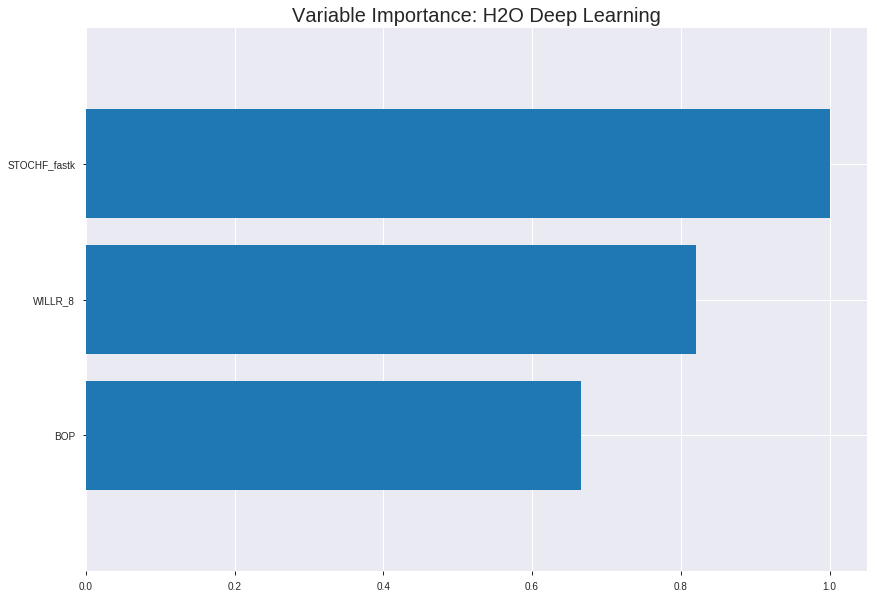

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_175224_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24861388146027744
RMSE: 0.4986119547907746
LogLoss: 0.6903688875849898
Mean Per-Class Error: 0.46025481422677683
AUC: 0.5440649738046267
pr_auc: 0.554121619976833
Gini: 0.08812994760925341
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4761870469895185: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      0    2072  1        (2072.0/2072.0)
1      0    2247  0        (0.0/2247.0)
Total  0    4319  0.4797   (2072.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.476187     0.684435   399
max f2                       0.476187     0.844292   399
max f0point5                 0.497631     0.577747   349
max accuracy                 0.537204     0.542255   212
max precision                0.584858     0.632653   24
max recall                   0.476187     1          399
max specificity              0.596574     0.999517   0
max absolute_mcc             0.537204     0.0800746  212
max min_per_class_accuracy   0.542404     0.538941   191
max mean_per_class_accuracy  0.537204     0.539745   212

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 54.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.590532           1.1358    1.1358             0.590909         0.592817  0.590909                    0.592817            0.011571        0.011571                   13.5797   13.5797
    2        0.0201436                   0.587457           1.20691   1.17095            0.627907         0.588861  0.609195                    0.590862            0.012016        0.023587                   20.6912   17.0946
    3        0.0300996                   0.585296           1.16221   1.16806            0.604651         0.586288  0.607692                    0.589349            0.011571        0.035158                   16.2211   16.8057
    4        0.0400556                   0.583827           1.07281   1.14438            0.55814          0.584521  0.595376                    0.588149            0.0106809       0.0458389                  7.28103   14.4383
    5        0.0500116                   0.582222           1.07281   1.13013            0.55814          0.582965  0.587963                    0.587117            0.0106809       0.0565198                  7.28103   13.0134
    6        0.100023                    0.576715           1.08564   1.10789            0.564815         0.579394  0.576389                    0.583255            0.0542946       0.110814                   8.56409   10.7888
    7        0.150035                    0.571812           1.06784   1.09454            0.555556         0.574237  0.569444                    0.580249            0.0534045       0.164219                   6.78435   9.45396
    8        0.200046                    0.567872           1.04115   1.08119            0.541667         0.569809  0.5625                      0.577639            0.0520694       0.216288                   4.11475   8.11916
    9        0.300069                    0.558762           1.07674   1.07971            0.560185         0.563379  0.561728                    0.572886            0.107699        0.323988                   7.67422   7.97085
    10       0.400093                    0.550757           1.05005   1.07229            0.546296         0.554845  0.55787                     0.568375            0.105029        0.429016                   5.00462   7.22929
    11       0.500116                    0.542396           1.08119   1.07407            0.5625           0.546683  0.558796                    0.564037            0.108144        0.537161                   8.11916   7.40726
    12       0.599907                    0.53361            0.972208  1.05713            0.5058           0.538194  0.549981                    0.559738            0.0970182       0.634179                   -2.77916  5.7128
    13       0.699931                    0.523409           0.95661   1.04276            0.497685         0.528455  0.542507                    0.555268            0.0956831       0.729862                   -4.33902  4.27635
    14       0.799954                    0.512748           0.894319  1.0242             0.465278         0.518006  0.532851                    0.550609            0.0894526       0.819315                   -10.5681  2.42026
    15       0.899977                    0.498879           0.947711  1.0157             0.493056         0.506369  0.528428                    0.545692            0.0947931       0.914108                   -5.22889  1.57014
    16       1                           0.475891           0.858724  1                  0.446759         0.490678  0.520259                    0.540189          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24917635518301626
RMSE: 0.4991756756724192
LogLoss: 0.6914888882470525
Mean Per-Class Error: 0.4538925192267774
AUC: 0.5543552230884234
pr_auc: 0.5588086948739108
Gini: 0.10871044617684689
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48476497578981137: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      17   590   0.972    (590.0/607.0)
1      3    624   0.0048   (3.0/627.0)
Total  20   1214  0.4806   (593.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.484765     0.677892   388
max f2                       0.482327     0.839582   395
max f0point5                 0.493868     0.571806   365
max accuracy                 0.540904     0.547002   201
max precision                0.584556     0.72973    19
max recall                   0.482327     1          395
max specificity              0.596265     0.998353   0
max absolute_mcc             0.564488     0.0971893  94
max min_per_class_accuracy   0.544627     0.53542    183
max mean_per_class_accuracy  0.540904     0.546107   201

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 54.15 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.590747           0.908355  0.908355           0.461538         0.592962  0.461538                    0.592962            0.00956938      0.00956938                 -9.16452  -9.16452
    2        0.0202593                   0.586364           1.64009   1.25959            0.833333         0.588455  0.64                        0.590799            0.015949        0.0255183                  64.0085   25.9585
    3        0.0299838                   0.584071           1.80409   1.43618            0.916667         0.585518  0.72973                     0.589086            0.0175439       0.0430622                  80.4094   43.6183
    4        0.0405186                   0.58303            1.36253   1.41703            0.692308         0.5837    0.72                        0.587686            0.0143541       0.0574163                  36.2532   41.7033
    5        0.0502431                   0.581952           0.984051  1.33323            0.5              0.582375  0.677419                    0.586658            0.00956938      0.0669856                  -1.5949   33.323
    6        0.100486                    0.576835           1.07928   1.20626            0.548387         0.579595  0.612903                    0.583126            0.0542265       0.121212                   7.92818   20.6256
    7        0.149919                    0.572208           1.1615    1.1915             0.590164         0.574182  0.605405                    0.580177            0.0574163       0.178628                   16.1503   19.15
    8        0.200162                    0.566729           1.11103   1.1713             0.564516         0.569396  0.595142                    0.577471            0.0558214       0.23445                    11.1025   17.13
    9        0.299838                    0.559164           1.04005   1.12767            0.528455         0.563075  0.572973                    0.572685            0.103668        0.338118                   4.00539   12.7669
    10       0.400324                    0.551968           0.952307  1.08365            0.483871         0.555649  0.550607                    0.568409            0.0956938       0.433812                   -4.76925  8.36513
    11       0.5                         0.544696           1.00805   1.06858            0.512195         0.548613  0.54295                     0.564463            0.100478        0.53429                    0.805228  6.85805
    12       0.599676                    0.536267           1.00805   1.05852            0.512195         0.5407    0.537838                    0.560513            0.100478        0.634769                   0.805228  5.85198
    13       0.700162                    0.525193           0.872949  1.03189            0.443548         0.531005  0.524306                    0.556278            0.0877193       0.722488                   -12.7051  3.18869
    14       0.799838                    0.514964           0.96005   1.02293            0.487805         0.520141  0.519757                    0.551775            0.0956938       0.818182                   -3.99502  2.29345
    15       0.899514                    0.502185           0.976051  1.01774            0.495935         0.508698  0.517117                    0.547001            0.0972887       0.91547                    -2.39494  1.77393
    16       1                           0.476344           0.841205  1                  0.427419         0.492069  0.508104                    0.541481            0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 17:54:03  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 17:54:10  8.327 sec         353 obs/sec       0.595971  1             2574       0.689665         2.69292             -0.905679      0.535364        0.546146           1.17948          0.479278                         0.69838            2.76418               -0.951449        0.532912          0.546943             1.21114            0.486224
    2019-08-24 17:54:23  20.850 sec        418 obs/sec       1.82334   3             7875       0.574904         0.904234            -0.324234      0.471752        0.503321           0.698952         0.479046                         0.580833           0.919852              -0.34982         0.476028          0.49621              0.60557            0.488655
    2019-08-24 17:54:32  30.742 sec        471 obs/sec       3.02825   5             13079      0.652922         1.40588             -0.708031      0.468604        0.497807           0.961059         0.479741                         0.660674           1.43453               -0.74642         0.449883          0.470468             1.21114            0.491086
    2019-08-24 17:54:43  41.373 sec        559 obs/sec       4.84279   8             20916      0.508152         0.709879            -0.0345721     0.502853        0.52459            0.87369          0.477888                         0.507698           0.708964              -0.0313003       0.49248           0.502972             0.908355           0.490276
    2019-08-24 17:54:53  51.429 sec        676 obs/sec       7.27784   12            31433      0.508901         0.711848            -0.0376241     0.534304        0.545772           1.04843          0.479509                         0.511742           0.717745              -0.0477929       0.528866          0.5394               1.36253            0.490276
    2019-08-24 17:55:04  1 min  2.088 sec  836 obs/sec       10.8738   18            46964      0.500142         0.693432            -0.00221354    0.53079         0.548658           1.17948          0.479278                         0.499732           0.692608              0.000809536      0.529029          0.537736             1.05975            0.475689
    2019-08-24 17:55:14  1 min 11.840 sec  1083 obs/sec      16.3022   27            70409      0.498612         0.690369            0.00390913     0.544065        0.554122           1.1358           0.479741                         0.499176           0.691489              0.00303269       0.554355          0.558809             0.908355           0.480551
    2019-08-24 17:55:24  1 min 21.804 sec  1550 obs/sec      26.5557   44            114694     0.502829         0.699068            -0.0130119     0.544549        0.555492           1.26685          0.479741                         0.504943           0.703373              -0.0201381       0.552569          0.560073             1.05975            0.481361
    2019-08-24 17:55:33

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  ------------
STOCHF_fastk  1                      1                    0.402253
WILLR_8       0.820564               0.820564             0.330074
BOP           0.665434               0.665434             0.267673

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5559157212317666)

('F1', 0.6914103923647932)

('auc', 0.555952606834904)

('logloss', 0.6879318889727726)

('mean_per_class_error', 0.45126283389201605)

('rmse', 0.497395421174232)

('mse', 0.24740220500509164)

deeplearning prediction progress: |███████████████████████████████████████| 100%


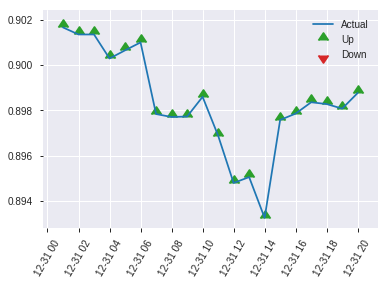


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.24740220500509164
RMSE: 0.497395421174232
LogLoss: 0.6879318889727726
Mean Per-Class Error: 0.45126283389201605
AUC: 0.555952606834904
pr_auc: 0.5686773600423224
Gini: 0.11190521366980799
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47590786426089016: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    291  1        (291.0/291.0)
1      0    326  0        (0.0/326.0)
Total  0    617  0.4716   (291.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.475908     0.69141   399
max f2                       0.475908     0.848516  399
max f0point5                 0.504226     0.592486  332
max accuracy                 0.523013     0.555916  255
max precision                0.593381     1         0
max recall                   0.475908     1         399
max specificity              0.593381     1         0
max absolute_mcc             0.553203     0.102459  131
max min_per_class_accuracy   0.539434     0.53681   189
max mean_per_class_accuracy  0.553203     0.548737  131

Gains/Lift Table: Avg response rate: 52.84 %, avg score: 53.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.589013           1.35188   1.35188            0.714286         0.590805  0.714286                    0.590805            0.0153374       0.0153374                  35.1884   35.1884
    2        0.0210697                   0.587683           0.946319  1.1647             0.5              0.588384  0.615385                    0.589688            0.00920245      0.0245399                  -5.3681   16.47
    3        0.0307942                   0.586311           1.26176   1.19535            0.666667         0.587166  0.631579                    0.588892            0.0122699       0.0368098                  26.1759   19.535
    4        0.0405186                   0.583622           1.26176   1.21129            0.666667         0.585012  0.64                        0.58796             0.0122699       0.0490798                  26.1759   21.1288
    5        0.0502431                   0.581948           0.630879  1.09895            0.333333         0.583112  0.580645                    0.587022            0.00613497      0.0552147                  -36.9121  9.89511
    6        0.100486                    0.575777           1.16      1.12948            0.612903         0.579202  0.596774                    0.583112            0.0582822       0.113497                   16.0004   12.9478
    7        0.150729                    0.57155            1.16      1.13965            0.612903         0.573556  0.602151                    0.579927            0.0582822       0.171779                   16.0004   13.9653
    8        0.200972                    0.566537           1.16      1.14474            0.612903         0.568866  0.604839                    0.577161            0.0582822       0.230061                   16.0004   14.4741
    9        0.299838                    0.556756           1.02389   1.10489            0.540984         0.561786  0.583784                    0.572092            0.101227        0.331288                   2.38862   10.4891
    10       0.400324                    0.547848           1.0379    1.08808            0.548387         0.552196  0.574899                    0.567098            0.104294        0.435583                   3.78983   8.80753
    11       0.50081                     0.539239           1.00737   1.07188            0.532258         0.544013  0.566343                    0.562466            0.101227        0.53681                    0.737186  7.18824
    12       0.599676                    0.528316           1.08594   1.0742             0.57377          0.534207  0.567568                    0.557807            0.107362        0.644172                   8.59399   7.42
    13       0.700162                    0.518757           0.885266  1.04708            0.467742         0.523709  0.553241                    0.552913            0.0889571       0.733129                   -11.4734  4.70845
    14       0.799028                    0.508816           0.992859  1.04038            0.52459          0.514307  0.549696                    0.548136            0.0981595       0.831288                   -0.71407  4.03751
    15       0.899514                    0.498324           0.85474   1.01964            0.451613         0.50406   0.538739                    0.543213            0.0858896       0.917178                   -14.526   1.96374
    16       1                           0.475908           0.824213  1                  0.435484         0.490787  0.528363                    0.537944            0.0

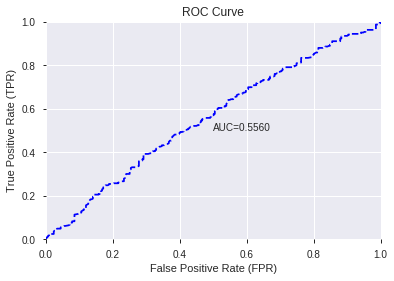

This function is available for GLM models only


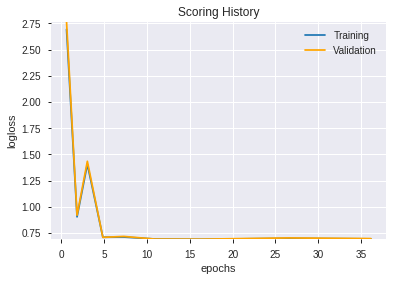

--2019-08-24 17:59:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.98.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.98.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_175224_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_175224_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_78_sid_87c2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['STOCHF_fastk', 'WILLR_8', 'BOP']

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_175949_model_1  0.552511  0.688177                   0.5  0.497513  0.247519

variable  relative_importance  scaled_importance  percentage
0           BOP             0.060612           1.000000    0.382502
1       WILLR_8             0.050529           0.833640    0.318869
2  STOCHF_fastk             0.047321           0.780723    0.298628

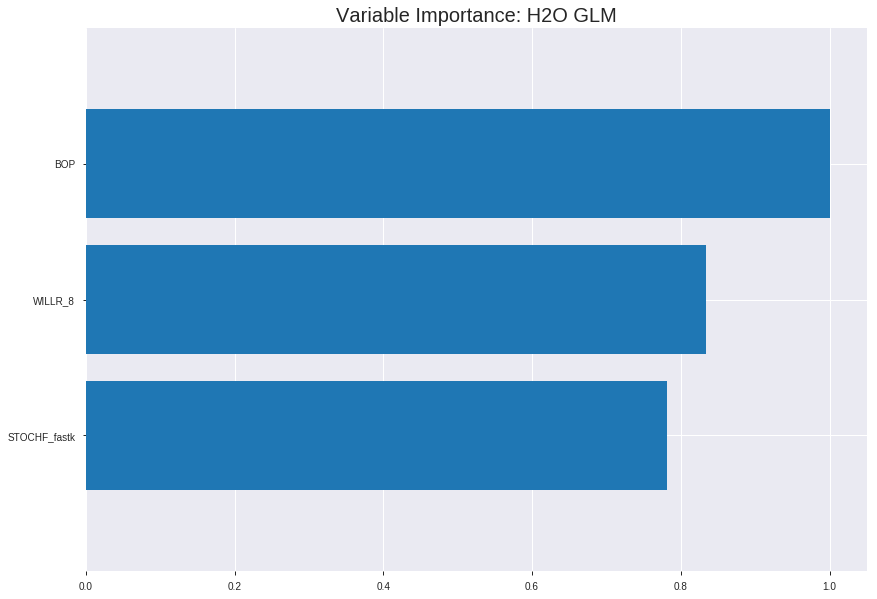

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_175949_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24834141037315013
RMSE: 0.4983386502902922
LogLoss: 0.6898243863182538
Null degrees of freedom: 4318
Residual degrees of freedom: 4315
Null deviance: 5980.312642429541
Residual deviance: 5958.703049017076
AIC: 5966.703049017076
AUC: 0.5410786883583946
pr_auc: 0.5505329883537993
Gini: 0.08215737671678913
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4472399033388145: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      0    2072  1        (2072.0/2072.0)
1      0    2247  0        (0.0/2247.0)
Total  0    4319  0.4797   (2072.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.44724      0.684435   399
max f2                       0.44724      0.844292   399
max f0point5                 0.469391     0.577443   350
max accuracy                 0.509403     0.539708   234
max precision                0.591371     0.7        2
max recall                   0.44724      1          399
max specificity              0.593455     0.999517   0
max absolute_mcc             0.509403     0.0725844  234
max min_per_class_accuracy   0.519897     0.534266   201
max mean_per_class_accuracy  0.516455     0.535789   212

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 52.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101875                   0.587796           1.1358    1.1358             0.590909         0.589887  0.590909                    0.589887            0.011571        0.011571                   13.5797    13.5797
    2        0.0201436                   0.584624           1.02811   1.08257            0.534884         0.586339  0.563218                    0.588133            0.0102359       0.0218069                  2.81098    8.25724
    3        0.0300996                   0.582243           1.43041   1.19763            0.744186         0.583296  0.623077                    0.586533            0.0142412       0.0360481                  43.0414    19.7628
    4        0.0400556                   0.580027           0.849308  1.11105            0.44186          0.581022  0.578035                    0.585163            0.00845572      0.0445038                  -15.0692   11.1051
    5        0.0500116                   0.57768            0.983409  1.08564            0.511628         0.578764  0.564815                    0.583889            0.00979083      0.0542946                  -1.65906   8.56409
    6        0.100023                    0.568791           1.10344   1.09454            0.574074         0.573066  0.569444                    0.578478            0.0551847       0.109479                   10.3438    9.45396
    7        0.150035                    0.561051           1.05894   1.08267            0.550926         0.564615  0.563272                    0.573857            0.0529595       0.162439                   5.89448    8.26747
    8        0.200046                    0.553352           1.07674   1.08119            0.560185         0.557261  0.5625                      0.569708            0.0538496       0.216288                   7.67422    8.11916
    9        0.300069                    0.540728           1.00555   1.05598            0.523148         0.546719  0.549383                    0.562045            0.100579        0.316867                   0.555267   5.59786
    10       0.400093                    0.529831           1.11679   1.07118            0.581019         0.535191  0.557292                    0.555331            0.111704        0.428571                   11.6786    7.11806
    11       0.500116                    0.51992            1.05005   1.06695            0.546296         0.525103  0.555093                    0.549286            0.105029        0.5336                     5.00462    6.69537
    12       0.599907                    0.50977            0.994507  1.0549             0.517401         0.514887  0.548823                    0.543564            0.0992434       0.632844                   -0.549327  5.49025
    13       0.699931                    0.498862           0.969958  1.04276            0.50463          0.504272  0.542507                    0.537949            0.0970182       0.729862                   -3.00421   4.27635
    14       0.799954                    0.487649           0.880971  1.02253            0.458333         0.493182  0.531983                    0.532351            0.0881175       0.81798                    -11.9029   2.25336
    15       0.899977                    0.47258            0.947711  1.01422            0.493056         0.48065   0.527656                    0.526605            0.0947931       0.912773                   -5.22889   1.42179
    16       1                           0.44724            0.872072  1                  0.453704         0.463161  0.520259                    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24810797851354055
RMSE: 0.498104385157911
LogLoss: 0.6893470825998951
Null degrees of freedom: 1233
Residual degrees of freedom: 1230
Null deviance: 1711.0932050440474
Residual deviance: 1701.3085998565412
AIC: 1709.3085998565412
AUC: 0.5526499714915565
pr_auc: 0.5551955349951868
Gini: 0.10529994298311296
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4565521474631763: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      17   590   0.972    (590.0/607.0)
1      3    624   0.0048   (3.0/627.0)
Total  20   1214  0.4806   (593.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.456552     0.677892  387
max f2                       0.453972     0.839582  394
max f0point5                 0.466473     0.570781  363
max accuracy                 0.520755     0.547002  200
max precision                0.582187     0.740741  16
max recall                   0.453972     1         394
max specificity              0.593235     0.998353  0
max absolute_mcc             0.546775     0.101634  112
max min_per_class_accuracy   0.523132     0.54386   191
max mean_per_class_accuracy  0.520755     0.54658   200

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 52.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain         cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  -----------  -----------------
    1        0.0105348                   0.584744           1.05975   1.05975            0.538462         0.589258  0.538462                    0.589258            0.0111643       0.0111643                  5.97473      5.97473
    2        0.0202593                   0.582213           1.80409   1.41703            0.916667         0.583383  0.72                        0.586438            0.0175439       0.0287081                  80.4094      41.7033
    3        0.0299838                   0.580385           1.31207   1.38299            0.666667         0.581467  0.702703                    0.584826            0.0127592       0.0414673                  31.2068      38.2991
    4        0.0405186                   0.578747           0.908355  1.25959            0.461538         0.579485  0.64                        0.583437            0.00956938      0.0510367                  -9.16452     25.9585
    5        0.0502431                   0.577097           1.47608   1.30149            0.75             0.577946  0.66129                     0.582374            0.0143541       0.0653907                  47.6077      30.1487
    6        0.100486                    0.568933           1.14277   1.22213            0.580645         0.572882  0.620968                    0.577628            0.0574163       0.122807                   14.2769      22.2128
    7        0.149919                    0.560948           1.03245   1.15958            0.52459          0.564983  0.589189                    0.573459            0.0510367       0.173844                   3.2447       15.9584
    8        0.200162                    0.554011           1.14277   1.15536            0.580645         0.557569  0.587045                    0.56947             0.0574163       0.23126                    14.2769      15.5364
    9        0.299838                    0.542699           0.992051  1.10107            0.504065         0.547448  0.559459                    0.562149            0.0988836       0.330144                   -0.794855    10.1073
    10       0.400324                    0.531551           0.999923  1.07568            0.508065         0.537055  0.546559                    0.55585             0.100478        0.430622                   -0.00771724  7.56833
    11       0.5                         0.523015           1.13606   1.08772            0.577236         0.527136  0.552674                    0.550126            0.113238        0.54386                    13.6059      8.77193
    12       0.599676                    0.512547           0.96005   1.0665             0.487805         0.518209  0.541892                    0.544821            0.0956938       0.639553                   -3.99502     6.64986
    13       0.700162                    0.500334           0.872949  1.03872            0.443548         0.506867  0.527778                    0.539374            0.0877193       0.727273                   -12.7051     3.87205
    14       0.799838                    0.490285           0.928048  1.02493            0.471545         0.495472  0.52077                     0.533903            0.092504        0.819777                   -7.19519     2.49285
    15       0.899514                    0.475702           0.96005   1.01774            0.487805         0.483308  0.517117                    0.528296            0.0956938       0.91547                    -3.99502     1.77393
    16       1                           0.447764           0.841205  1                  0.427419         0.46


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 17:59:49  0.000 sec   2            3.3       4             1.38325           1.38479
    2019-08-24 17:59:49  0.002 sec   3            2         4             1.38267           1.384
    2019-08-24 17:59:49  0.005 sec   4            1.3       4             1.38199           1.38305
    2019-08-24 17:59:49  0.007 sec   6            0.78      4             1.3813            1.38203
    2019-08-24 17:59:49  0.009 sec   7            0.49      4             1.38069           1.38107
    2019-08-24 17:59:49  0.011 sec   8            0.3       4             1.38024           1.38028
    2019-08-24 17:59:49  0.013 sec   9            0.19      4             1.37995           1.37969
    2019-08-24 17:59:49  0.016 sec   10           0.12      4             1.37979           1.3793
    2019-08-24 17:59:49  0.019 sec   11           0.072     4             1.37971           1.37905
    2019-08-24 17:59:49  0.020 sec   12           0.045     4             1.37968           1.37889
    2019-08-24 17:59:49  0.022 sec   13           0.028     4             1.37966           1.37879
    2019-08-24 17:59:49  0.024 sec   14           0.017     4             1.37965           1.37873
    2019-08-24 17:59:49  0.025 sec   15           0.011     4             1.37965           1.37869

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5623987034035657)

('F1', 0.6914103923647932)

('auc', 0.5525109101258617)

('logloss', 0.6881769313075674)

('mean_per_class_error', 0.4447325701515823)

('rmse', 0.49751300066067905)

('mse', 0.24751918582639285)

glm prediction progress: |████████████████████████████████████████████████| 100%


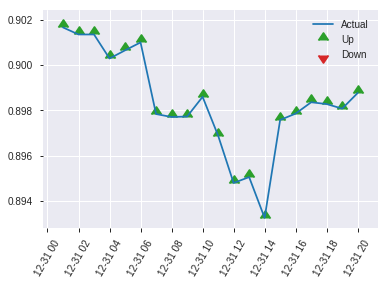


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24751918582639285
RMSE: 0.49751300066067905
LogLoss: 0.6881769313075674
Null degrees of freedom: 616
Residual degrees of freedom: 613
Null deviance: 853.5195608018752
Residual deviance: 849.2103332335381
AIC: 857.2103332335381
AUC: 0.5525109101258617
pr_auc: 0.5603551040255171
Gini: 0.10502182025172346
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.447324229633148: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    291  1        (291.0/291.0)
1      0    326  0        (0.0/326.0)
Total  0    617  0.4716   (291.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.447324     0.69141   399
max f2                       0.447324     0.848516  399
max f0point5                 0.479409     0.592378  336
max accuracy                 0.500539     0.562399  257
max precision                0.590916     1         0
max recall                   0.447324     1         399
max specificity              0.590916     1         0
max absolute_mcc             0.500539     0.114214  257
max min_per_class_accuracy   0.516636     0.53681   206
max mean_per_class_accuracy  0.500539     0.555267  257

Gains/Lift Table: Avg response rate: 52.84 %, avg score: 51.74 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.586482           1.08151   1.08151            0.571429         0.588416  0.571429                    0.588416            0.0122699       0.0122699                  8.15074   8.15074
    2        0.0210697                   0.584366           0.630879  0.873525           0.333333         0.585308  0.461538                    0.586982            0.00613497      0.0184049                  -36.9121  -12.6475
    3        0.0307942                   0.580601           1.5772    1.09574            0.833333         0.582916  0.578947                    0.585698            0.0153374       0.0337423                  57.7198   9.57378
    4        0.0405186                   0.578183           0.946319  1.05988            0.5              0.579443  0.56                        0.584197            0.00920245      0.0429448                  -5.3681   5.98773
    5        0.0502431                   0.575951           1.26176   1.09895            0.666667         0.577271  0.580645                    0.582856            0.0122699       0.0552147                  26.1759   9.89511
    6        0.100486                    0.565986           1.09895   1.09895            0.580645         0.57021   0.580645                    0.576533            0.0552147       0.110429                   9.89511   9.89511
    7        0.150729                    0.560401           1.0379    1.0786             0.548387         0.563346  0.569892                    0.572137            0.0521472       0.162577                   3.78983   7.86002
    8        0.200972                    0.553237           1.22106   1.11421            0.645161         0.55704   0.58871                     0.568363            0.0613497       0.223926                   22.1057   11.4214
    9        0.299838                    0.538197           1.05491   1.09466            0.557377         0.544361  0.578378                    0.560449            0.104294        0.328221                   5.4913    9.46609
    10       0.400324                    0.525417           0.976845  1.06509            0.516129         0.531981  0.562753                    0.553303            0.0981595       0.42638                    -2.31546  6.50878
    11       0.50081                     0.516134           1.09895   1.07188            0.580645         0.521183  0.566343                    0.546858            0.110429        0.53681                    9.89511   7.18824
    12       0.599676                    0.504205           1.11697   1.07932            0.590164         0.510226  0.57027                     0.540819            0.110429        0.647239                   11.6967   7.93152
    13       0.700162                    0.494557           0.915793  1.05585            0.483871         0.4988    0.55787                     0.534788            0.0920245       0.739264                   -8.42074  5.58467
    14       0.799028                    0.482889           0.868752  1.0327             0.459016         0.489213  0.545639                    0.529149            0.0858896       0.825153                   -13.1248  3.2697
    15       0.899514                    0.471943           0.915793  1.01964            0.483871         0.478236  0.538739                    0.523462            0.0920245       0.917178                   -8.42074  1.96374
    16       1                           0.447324           0.824213  1                  0.435484         0.463406  0.528363                    0.517427         

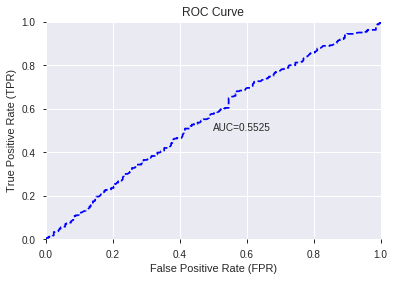

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


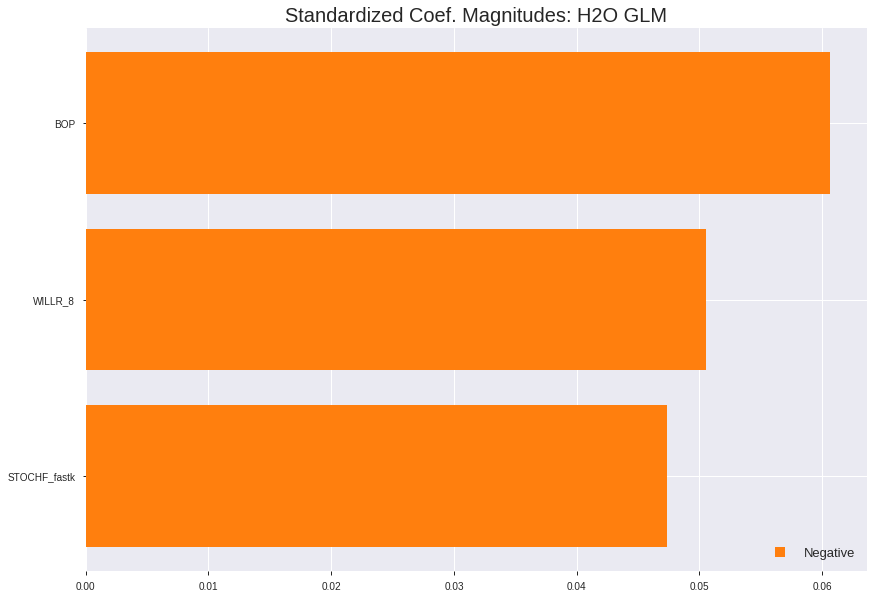

'log_likelihood'
--2019-08-24 17:59:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.178.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.178.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_175949_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_175949_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_86_sid_87c2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_86_s

['BOP', 'WILLR_8', 'STOCHF_fastk']

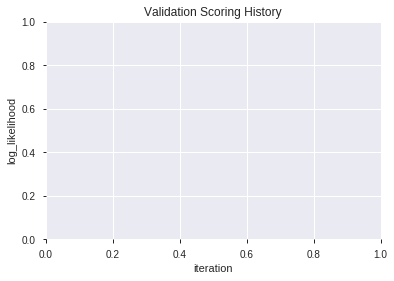

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190824_180002  0.559948  0.687060              0.472013  0.496885  0.246894
1  XGBoost_grid_1_AutoML_20190824_180002_model_3  0.558208  0.687908              0.476187  0.497291  0.247298
2  XGBoost_grid_1_AutoML_20190824_180002_model_1  0.551046  0.688712              0.477906  0.497713  0.247719
3  XGBoost_grid_1_AutoML_20190824_180002_model_6  0.549090  0.690563              0.491040  0.498595  0.248597
4  XGBoost_grid_1_AutoML_20190824_180002_model_2  0.545180  0.689487              0.498282  0.498149  0.248153
5               XGBoost_1_AutoML_20190824_180002  0.543851  0.693489              0.500000  0.500022  0.250022
6  XGBoost_grid_1_AutoML_20190824_180002_model_4  0.541153  0.689905              0.490671  0.498371  0.248374
7  XGBoost_grid_1_AutoML_20190824_180002_model_7  0.540541  0.692768              0.500000  0.499697  0.249697
8               XGBoost_2_AutoML_20190824_180002  0.533589  0.695366              0.500000  0.500966  0.250967
9  XGBoost_grid_1_AutoML_20190824_180002_model_5  0.529167  0.710322              0.494845  0.507308  0.257361

variable  relative_importance  scaled_importance  percentage
0           BOP          1003.829529           1.000000    0.383954
1  STOCHF_fastk           891.283142           0.887883    0.340906
2       WILLR_8           719.341125           0.716597    0.275140

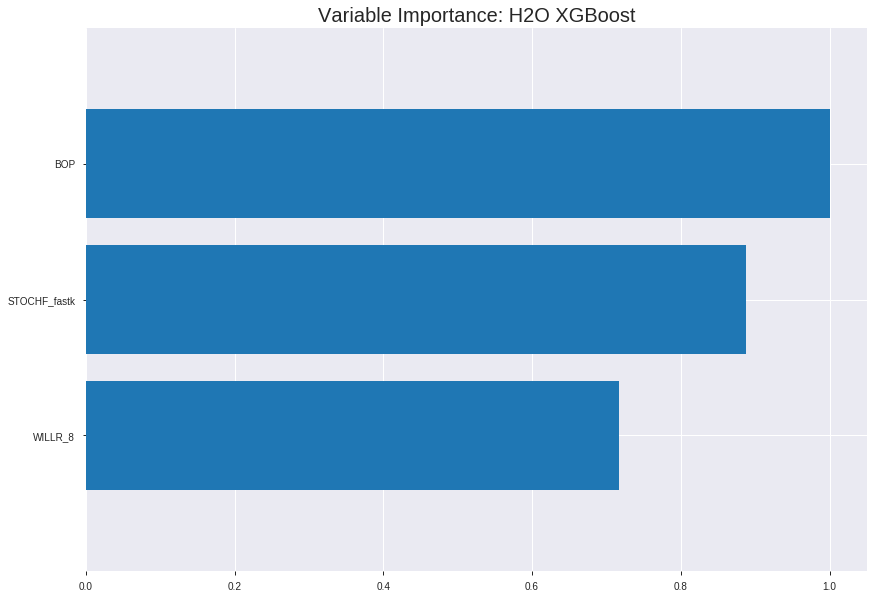

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190824_180002


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2356534788322059
RMSE: 0.4854415297769711
LogLoss: 0.6641321800945496
Mean Per-Class Error: 0.36164435463500877
AUC: 0.6841529804647295
pr_auc: 0.690633046126344
Gini: 0.368305960929459
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4681597729523977: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      543  1529  0.7379   (1529.0/2072.0)
1      200  2047  0.089    (200.0/2247.0)
Total  743  3576  0.4003   (1729.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.46816      0.703074  290
max f2                       0.399502     0.846049  376
max f0point5                 0.519368     0.652977  200
max accuracy                 0.519368     0.639268  200
max precision                0.746117     1         0
max recall                   0.370541     1         394
max specificity              0.746117     1         0
max absolute_mcc             0.519368     0.276923  200
max min_per_class_accuracy   0.522106     0.634624  195
max mean_per_class_accuracy  0.519368     0.638356  200

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 51.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.641618           1.74738   1.74738            0.909091         0.671256  0.909091                    0.671256            0.0178015       0.0178015                  74.738    74.738
    2        0.0201436                   0.62391            1.65392   1.70119            0.860465         0.631545  0.885057                    0.651629            0.0164664       0.0342679                  65.3916   70.1185
    3        0.0300996                   0.611318           1.43041   1.61162            0.744186         0.617497  0.838462                    0.640339            0.0142412       0.0485091                  43.0414   61.1622
    4        0.0400556                   0.603922           1.43041   1.56658            0.744186         0.606747  0.815029                    0.631989            0.0142412       0.0627503                  43.0414   56.6582
    5        0.0500116                   0.598469           1.51981   1.55727            0.790698         0.601049  0.810185                    0.62583             0.0151313       0.0778816                  51.9815   55.7272
    6        0.100023                    0.579276           1.42379   1.49053            0.740741         0.587734  0.775463                    0.606782            0.0712061       0.149088                   42.3791   49.0532
    7        0.150266                    0.567229           1.47923   1.48675            0.769585         0.572606  0.773498                    0.595355            0.0743213       0.223409                   47.9234   48.6754
    8        0.200046                    0.559187           1.29631   1.43936            0.674419         0.562932  0.748843                    0.587287            0.0645305       0.287939                   29.6312   43.9364
    9        0.300069                    0.54579            1.24582   1.37485            0.648148         0.552274  0.715278                    0.575616            0.124611        0.41255                    24.5817   37.4849
    10       0.400093                    0.534184           1.09009   1.30366            0.56713          0.540011  0.678241                    0.566715            0.109034        0.521584                   9.00903   30.3659
    11       0.500116                    0.522513           1.08119   1.25917            0.5625           0.528415  0.655093                    0.559055            0.108144        0.629729                   8.11916   25.9166
    12       0.599907                    0.50963            0.936531  1.2055             0.487239         0.516375  0.627171                    0.551955            0.0934579       0.723186                   -6.3469   20.5497
    13       0.699931                    0.492667           0.845376  1.15403            0.439815         0.501444  0.600397                    0.544737            0.0845572       0.807744                   -15.4624  15.4034
    14       0.799954                    0.47357            0.805332  1.11043            0.418981         0.482827  0.577713                    0.536996            0.0805518       0.888296                   -19.4668  11.0434
    15       0.899977                    0.448937           0.662953  1.0607             0.344907         0.461938  0.551839                    0.528654            0.0663106       0.954606                   -33.7047  6.07008
    16       1                           0.347596           0.453834  1                  0.236111         0.422793  0.520259                    0.518065          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.24787304356757112
RMSE: 0.4978685002764998
LogLoss: 0.6888655778257395
Mean Per-Class Error: 0.4501325576934698
AUC: 0.5510603301724433
pr_auc: 0.5517743204003328
Gini: 0.10212066034488654
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38243259986241657: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      6    601   0.9901   (601.0/607.0)
1      0    627   0        (0.0/627.0)
Total  6    1228  0.487    (601.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.382433     0.676011  393
max f2                       0.382433     0.839133  393
max f0point5                 0.474444     0.569976  293
max accuracy                 0.508102     0.551864  224
max precision                0.660813     1         0
max recall                   0.382433     1         393
max specificity              0.660813     1         0
max absolute_mcc             0.508102     0.102937  224
max min_per_class_accuracy   0.527133     0.527911  182
max mean_per_class_accuracy  0.508102     0.549867  224

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 51.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.6302             1.36253   1.36253            0.692308         0.642986  0.692308                    0.642986            0.0143541       0.0143541                  36.2532   36.2532
    2        0.0202593                   0.612969           1.31207   1.33831            0.666667         0.620308  0.68                        0.632101            0.0127592       0.0271132                  31.2068   33.8309
    3        0.0299838                   0.606417           1.14806   1.27661            0.583333         0.610172  0.648649                    0.624989            0.0111643       0.0382775                  14.806    27.6607
    4        0.0405186                   0.599687           0.908355  1.18086            0.461538         0.603504  0.6                         0.619403            0.00956938      0.0478469                  -9.16452  18.0861
    5        0.0502431                   0.594835           0.656034  1.07928            0.333333         0.596721  0.548387                    0.615013            0.00637959      0.0542265                  -34.3966  7.92818
    6        0.100486                    0.577162           1.33323   1.20626            0.677419         0.584787  0.612903                    0.5999              0.0669856       0.121212                   33.323    20.6256
    7        0.149919                    0.566889           1.06471   1.15958            0.540984         0.571699  0.589189                    0.590601            0.0526316       0.173844                   6.4711    15.9584
    8        0.200162                    0.560208           0.920564  1.09959            0.467742         0.563617  0.558704                    0.583828            0.046252        0.220096                   -7.94361  9.95874
    9        0.299838                    0.547641           1.08806   1.09575            0.552846         0.553658  0.556757                    0.573798            0.108453        0.328549                   8.80564   9.57541
    10       0.400324                    0.536865           0.936436  1.05576            0.475806         0.541924  0.536437                    0.565797            0.0940989       0.422648                   -6.35643  5.57633
    11       0.5                         0.526914           1.05605   1.05582            0.536585         0.531888  0.536467                    0.559038            0.105263        0.527911                   5.60548   5.58214
    12       0.599676                    0.51166            1.16806   1.07448            0.593496         0.51976   0.545946                    0.552509            0.116427        0.644338                   16.8061   7.44773
    13       0.700162                    0.494893           0.936436  1.05467            0.475806         0.50353   0.53588                     0.54548             0.0940989       0.738437                   -6.35643  5.46658
    14       0.799838                    0.476744           0.896046  1.0349             0.455285         0.485442  0.525836                    0.537998            0.0893142       0.827751                   -10.3954  3.48987
    15       0.899514                    0.453014           0.896046  1.01951            0.455285         0.465743  0.518018                    0.529991            0.0893142       0.917065                   -10.3954  1.95123
    16       1                           0.357278           0.825333  1                  0.419355         0.425903  0.508104                    0.519532         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 18:00:05  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.479741                         0.5                0.693147              0.5               0                    1                  0.491896
    2019-08-24 18:00:05  0.053 sec   5                  0.4972           0.687558            0.624573        0.634996           1.52363          0.447326                         0.498736           0.690621              0.56509           0.558549             1.10706            0.489465
    2019-08-24 18:00:05  0.103 sec   10                 0.495321         0.683817            0.636035        0.64484            1.7037           0.43436                          0.498231           0.689608              0.558044          0.564044             1.36253            0.487034
    2019-08-24 18:00:06  0.156 sec   15                 0.493436         0.680066            0.648278        0.658641           1.61633          0.422783                         0.497786           0.688715              0.560391          0.567094             1.36253            0.489465
    2019-08-24 18:00:06  0.208 sec   20                 0.492033         0.677271            0.653123        0.66386            1.66001          0.435286                         0.497732           0.688601              0.556399          0.564796             1.36253            0.489465
    2019-08-24 18:00:06  0.266 sec   25                 0.490523         0.674263            0.662142        0.674327           1.79398          0.430424                         0.497484           0.688104              0.559127          0.564423             1.36253            0.488655
    2019-08-24 18:00:06  0.324 sec   30                 0.489373         0.671975            0.668817        0.679521           1.79106          0.418384                         0.49761            0.688351              0.554266          0.556687             1.36253            0.487844
    2019-08-24 18:00:06  0.383 sec   35                 0.488133         0.669505            0.671918        0.680503           1.79106          0.421162                         0.49766            0.68845               0.552737          0.552492             1.21114            0.486224
    2019-08-24 18:00:06  0.440 sec   40                 0.487179         0.667604            0.676855        0.684406           1.75126          0.397546                         0.497747           0.688624              0.551364          0.553455             1.26521            0.488655
    2019-08-24 18:00:06  0.509 sec   45                 0.486209         0.665666            0.680867        0.688124           1.75126          0.407965                         0.497701           0.688523              0.551737          0.555504             1.36253            0.487034
    2019-08-24 18:00:06  0.571 sec   50                 0.485442         0.664132            0.684153        0.690633           1.74738          0.400324                         0.497869           0.688866              0.55106           0.551774             1.36253            0.487034

Variable Importances: 


variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  ------------
BOP           1003.83                1                    0.383954
STOCHF_fastk  891.283                0.887883             0.340906
WILLR_8       719.341                0.716597             0.27514

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5737439222042139)

('F1', 0.6946902654867257)

('auc', 0.5599477157253389)

('logloss', 0.6870601520361842)

('mean_per_class_error', 0.43958847216073194)

('rmse', 0.4968846854251403)

('mse', 0.24689439061004062)

xgboost prediction progress: |████████████████████████████████████████████| 100%


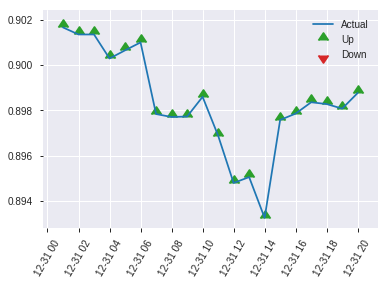


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24689439061004062
RMSE: 0.4968846854251403
LogLoss: 0.6870601520361842
Mean Per-Class Error: 0.43958847216073194
AUC: 0.5599477157253389
pr_auc: 0.5603148351663721
Gini: 0.11989543145067771
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4376220107078552: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      27   264  0.9072   (264.0/291.0)
1      12   314  0.0368   (12.0/326.0)
Total  39   578  0.4473   (276.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.437622     0.69469   365
max f2                       0.377417     0.849844  396
max f0point5                 0.480346     0.603996  289
max accuracy                 0.480346     0.573744  289
max precision                0.594692     0.666667  28
max recall                   0.377417     1         396
max specificity              0.735598     0.996564  0
max absolute_mcc             0.480346     0.138366  289
max min_per_class_accuracy   0.519552     0.542945  190
max mean_per_class_accuracy  0.489543     0.560412  269

Gains/Lift Table: Avg response rate: 52.84 %, avg score: 51.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.646448           0.270377  0.270377           0.142857         0.67255   0.142857                    0.67255             0.00306748      0.00306748                 -72.9623  -72.9623
    2        0.0210697                   0.628622           1.26176   0.727938           0.666667         0.637266  0.384615                    0.656265            0.0122699       0.0153374                  26.1759   -27.2062
    3        0.0324149                   0.612973           1.62226   1.04095            0.857143         0.619968  0.55                        0.643561            0.0184049       0.0337423                  62.2261   4.09509
    4        0.0405186                   0.601218           1.13558   1.05988            0.6              0.603233  0.56                        0.635495            0.00920245      0.0429448                  13.5583   5.98773
    5        0.0502431                   0.595934           1.89264   1.22106            1                0.598852  0.645161                    0.628403            0.0184049       0.0613497                  89.2638   22.1057
    6        0.100486                    0.575053           0.85474   1.0379             0.451613         0.584005  0.548387                    0.606204            0.0429448       0.104294                   -14.526   3.78983
    7        0.150729                    0.563006           1.22106   1.09895            0.645161         0.567842  0.580645                    0.593417            0.0613497       0.165644                   22.1057   9.89511
    8        0.200972                    0.557344           1.0379    1.08369            0.548387         0.559612  0.572581                    0.584965            0.0521472       0.217791                   3.78983   8.36879
    9        0.299838                    0.543853           1.11697   1.09466            0.590164         0.549614  0.578378                    0.573309            0.110429        0.328221                   11.6967   9.46609
    10       0.400324                    0.53146            0.976845  1.06509            0.516129         0.537816  0.562753                    0.5644              0.0981595       0.42638                    -2.31546  6.50878
    11       0.50081                     0.519905           1.12948   1.07801            0.596774         0.526028  0.569579                    0.556701            0.113497        0.539877                   12.9478   7.80074
    12       0.599676                    0.506391           0.992859  1.06397            0.52459          0.513707  0.562162                    0.549612            0.0981595       0.638037                   -0.71407  6.39695
    13       0.700162                    0.491359           1.12948   1.07337            0.596774         0.499215  0.56713                     0.542379            0.113497        0.751534                   12.9478   7.33711
    14       0.799028                    0.472871           0.961832  1.05957            0.508197         0.482065  0.559838                    0.534917            0.095092        0.846626                   -3.81676  5.95702
    15       0.899514                    0.448116           0.76316   1.02646            0.403226         0.46113   0.542342                    0.526674            0.0766871       0.923313                   -23.684   2.64577
    16       1                           0.360482           0.76316   1                  0.403226         0.423912  0.528363                    0.516348       

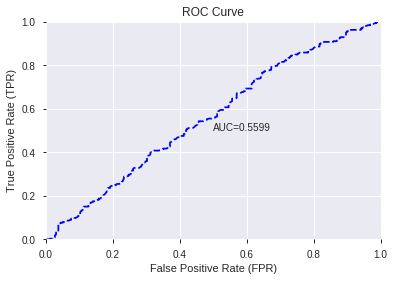

This function is available for GLM models only


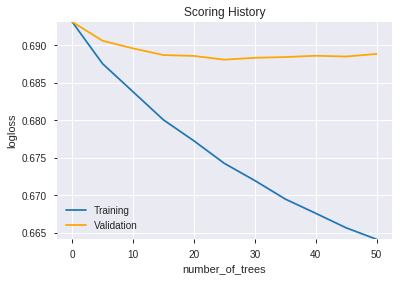

--2019-08-24 18:00:21--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.37.252
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.37.252|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190824_180002',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190824_180002',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_94_sid_87c2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_94_sid_87c2',
   'type

['BOP', 'STOCHF_fastk', 'WILLR_8']

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

589

['BBANDS_upperband_8_2_4',
 'BBANDS_middleband_8_2_4',
 'BBANDS_lowerband_8_2_4',
 'BBANDS_upperband_8_2_5',
 'BBANDS_middleband_8_2_5',
 'BBANDS_lowerband_8_2_5',
 'MA_8_3',
 'MAVP_8_3',
 'T3_8_3',
 'BBANDS_upperband_8_3_2',
 'BBANDS_middleband_8_3_2',
 'BBANDS_lowerband_8_3_2',
 'BBANDS_upperband_8_3_3',
 'BBANDS_middleband_8_3_3',
 'BBANDS_lowerband_8_3_3',
 'BBANDS_upperband_8_3_4',
 'BBANDS_middleband_8_3_4',
 'BBANDS_lowerband_8_3_4',
 'BBANDS_upperband_8_3_5',
 'BBANDS_middleband_8_3_5',
 'BBANDS_lowerband_8_3_5',
 'MA_8_4',
 'MAVP_8_4',
 'T3_8_4',
 'BBANDS_upperband_8_4_2',
 'BBANDS_middleband_8_4_2',
 'BBANDS_lowerband_8_4_2',
 'BBANDS_upperband_8_4_3',
 'BBANDS_middleband_8_4_3',
 'BBANDS_lowerband_8_4_3',
 'BBANDS_upperband_8_4_4',
 'BBANDS_middleband_8_4_4',
 'BBANDS_lowerband_8_4_4',
 'BBANDS_upperband_8_4_5',
 'BBANDS_middleband_8_4_5',
 'BBANDS_lowerband_8_4_5',
 'MA_8_5',
 'MAVP_8_5',
 'T3_8_5',
 'BBANDS_upperband_8_5_2',
 'BBANDS_middleband_8_5_2',
 'BBANDS_lowerband_8

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190824_180445_model_4  0.544863  0.739822              0.500000  0.511904  0.262045
1  DeepLearning_grid_1_AutoML_20190824_180445_model_9  0.543135  0.693732              0.493127  0.500293  0.250293
2  DeepLearning_grid_1_AutoML_20190824_180445_model_3  0.534607  0.797272              0.496379  0.536262  0.287577
3  DeepLearning_grid_1_AutoML_20190824_180445_model_2  0.534422  1.086667              0.487788  0.605952  0.367178
4  DeepLearning_grid_1_AutoML_20190824_180445_model_1  0.518141  1.628076              0.471402  0.637243  0.406079
5  DeepLearning_grid_1_AutoML_20190824_180445_model_6  0.515406  0.691546              0.496379  0.499201  0.249202
6  DeepLearning_grid_1_AutoML_20190824_180445_model_7  0.500037  0.703028              0.496564  0.502790  0.252798
7  DeepLearning_grid_1_AutoML_20190824_180445_model_8  0.500000  0.692579              0.500000  0.499716  0.249716
8  DeepLearning_grid_1_AutoML_20190824_180445_model_5  0.498651  0.692323              0.500000  0.499580  0.249580
9               DeepLearning_1_AutoML_20190824_180445  0.497512  0.696853              0.492574  0.500849  0.250850

variable  relative_importance  scaled_importance  percentage
0                    CORREL_8             1.000000           1.000000    0.005593
1           CDLDARKCLOUDCOVER             0.995047           0.995047    0.005565
2          CDLMORNINGDOJISTAR             0.960581           0.960581    0.005372
3          CDLEVENINGDOJISTAR             0.944357           0.944357    0.005281
4             CDLHOMINGPIGEON             0.928719           0.928719    0.005194
..                        ...                  ...                ...         ...
584                 MAVP_14_6             0.260933           0.260933    0.001459
585   BBANDS_lowerband_12_4_2             0.257035           0.257035    0.001438
586  BBANDS_middleband_30_1_3             0.256523           0.256523    0.001435
587                 MAVP_14_0             0.255831           0.255831    0.001431
588                  MAVP_8_4             0.254228           0.254228    0.001422

[589 rows x 4 columns]

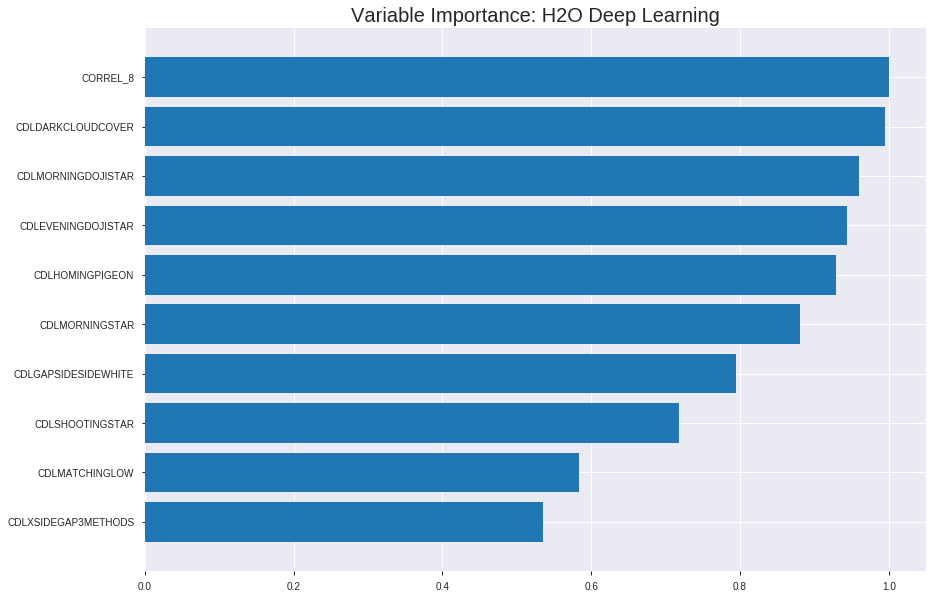

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190824_180445_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.21081084619032717
RMSE: 0.45914142286481535
LogLoss: 0.6050174221049774
Mean Per-Class Error: 0.33925639591527434
AUC: 0.7283971936842432
pr_auc: 0.754848085029848
Gini: 0.4567943873684863
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44881622572575103: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      725  1347  0.6501   (1347.0/2072.0)
1      236  2011  0.105    (236.0/2247.0)
Total  961  3358  0.3665   (1583.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.448816     0.717574  256
max f2                       0.0804484    0.8491    375
max f0point5                 0.573047     0.676604  182
max accuracy                 0.541502     0.661959  204
max precision                0.997823     1         0
max recall                   0.0180232    1         393
max specificity              0.997823     1         0
max absolute_mcc             0.573047     0.321886  182
max min_per_class_accuracy   0.56042      0.65198   190
max mean_per_class_accuracy  0.573047     0.660744  182

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 55.47 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.983607           1.92212   1.92212            1                0.990926  1                           0.990926            0.0195817       0.0195817                  92.2118   92.2118
    2        0.0201436                   0.967967           1.87742   1.90003            0.976744         0.975408  0.988506                    0.983256            0.0186916       0.0382733                  87.7418   90.0025
    3        0.0300996                   0.954069           1.83272   1.87776            0.953488         0.960503  0.976923                    0.97573             0.0182466       0.0565198                  83.2718   87.7762
    4        0.0400556                   0.935691           1.78802   1.85546            0.930233         0.946079  0.965318                    0.96836             0.0178015       0.0743213                  78.8017   85.5455
    5        0.0500116                   0.92025            1.87742   1.85983            0.976744         0.927639  0.967593                    0.960253            0.0186916       0.0930129                  87.7418   85.9828
    6        0.100023                    0.823503           1.69965   1.77974            0.884259         0.87139   0.925926                    0.915822            0.0850022       0.178015                   69.9651   77.9739
    7        0.150035                    0.753902           1.46828   1.67592            0.763889         0.788282  0.871914                    0.873308            0.0734312       0.251446                   46.8285   67.5921
    8        0.200046                    0.700756           1.31701   1.58619            0.685185         0.724702  0.825231                    0.836157            0.0658656       0.317312                   31.7007   58.6193
    9        0.300069                    0.634921           1.21467   1.46235            0.631944         0.663449  0.760802                    0.778588            0.121495        0.438807                   21.4672   46.2352
    10       0.400093                    0.59625            1.06339   1.36261            0.553241         0.614167  0.708912                    0.737482            0.106364        0.545171                   6.33942   36.2613
    11       0.500116                    0.560809           1.02335   1.29476            0.532407         0.577901  0.673611                    0.705566            0.102359        0.64753                    2.33501   29.476
    12       0.599907                    0.536622           0.981128  1.24259            0.510441         0.548353  0.646469                    0.679414            0.0979083       0.745438                   -1.88723  24.2589
    13       0.699931                    0.50389            0.854275  1.1871             0.444444         0.522449  0.617598                    0.656983            0.0854473       0.830886                   -14.5725  18.7097
    14       0.799954                    0.428186           0.760839  1.1338             0.395833         0.470039  0.58987                     0.633609            0.0761015       0.906987                   -23.9161  13.3799
    15       0.899977                    0.257395           0.587314  1.07306            0.305556         0.353723  0.558271                    0.602502            0.058745        0.965732                   -41.2686  7.30633
    16       1                           0.000803694        0.3426    1                  0.178241         0.124538  0.520259                    0.554695          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2763713881973856
RMSE: 0.5257103653128646
LogLoss: 0.7843172526974841
Mean Per-Class Error: 0.45650426050148585
AUC: 0.5431016135516266
pr_auc: 0.5339600766563067
Gini: 0.08620322710325312
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1044264300337703: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      18   589   0.9703   (589.0/607.0)
1      7    620   0.0112   (7.0/627.0)
Total  25   1209  0.483    (596.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.104426     0.675381  381
max f2                       0.0150497    0.838459  397
max f0point5                 0.421155     0.573685  297
max accuracy                 0.580448     0.54376   195
max precision                0.993888     1         0
max recall                   0.0150497    1         397
max specificity              0.993888     1         0
max absolute_mcc             0.421155     0.092575  297
max min_per_class_accuracy   0.587518     0.537068  191
max mean_per_class_accuracy  0.580448     0.543496  195

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 58.32 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.971969           1.05975   1.05975            0.538462         0.981365  0.538462                    0.981365            0.0111643       0.0111643                  5.97473   5.97473
    2        0.0202593                   0.961326           1.14806   1.10214            0.583333         0.96618   0.56                        0.974077            0.0111643       0.0223285                  14.806    10.2137
    3        0.0299838                   0.944401           1.14806   1.11703            0.583333         0.953946  0.567568                    0.967548            0.0111643       0.0334928                  14.806    11.7031
    4        0.0405186                   0.932285           0.908355  1.06278            0.461538         0.939676  0.54                        0.960301            0.00956938      0.0430622                  -9.16452  6.27751
    5        0.0502431                   0.908944           1.14806   1.07928            0.583333         0.919814  0.548387                    0.952465            0.0111643       0.0542265                  14.806    7.92818
    6        0.100486                    0.826472           0.88882   0.984051           0.451613         0.862685  0.5                         0.907575            0.0446571       0.0988836                  -11.118   -1.5949
    7        0.149919                    0.768565           0.967919  0.978732           0.491803         0.794553  0.497297                    0.870308            0.0478469       0.14673                    -3.20809  -2.12682
    8        0.200162                    0.72457            1.238     1.04381            0.629032         0.749314  0.530364                    0.839937            0.062201        0.208931                   23.8      4.38112
    9        0.299838                    0.659962           1.20006   1.09575            0.609756         0.688195  0.556757                    0.789493            0.119617        0.328549                   20.0062   9.57541
    10       0.400324                    0.618123           0.984051  1.06772            0.5              0.63581   0.54251                     0.750917            0.0988836       0.427432                   -1.5949   6.77153
    11       0.5                         0.58736            1.10406   1.07496            0.560976         0.602325  0.546191                    0.721295            0.110048        0.53748                    10.4057   7.49601
    12       0.599676                    0.548995           0.880046  1.04256            0.447154         0.56781   0.52973                     0.695783            0.0877193       0.625199                   -11.9954  4.25622
    13       0.700162                    0.52039            0.952307  1.02961            0.483871         0.534712  0.523148                    0.672667            0.0956938       0.720893                   -4.76925  2.9609
    14       0.799838                    0.472717           1.13606   1.04287            0.577236         0.502047  0.529889                    0.651404            0.113238        0.834131                   13.6059   4.28748
    15       0.899514                    0.345057           0.848044  1.02129            0.430894         0.416288  0.518919                    0.625351            0.0845295       0.91866                    -15.1956  2.12854
    16       1                           0.00584377         0.809461  1                  0.41129          0.206294  0.508104                    0.583241         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 18:10:57  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-24 18:11:03  8.742 sec         175 obs/sec       0.245659  1             1061       0.671234         3.00538             -0.805183      0.508575        0.427278           1.04843          0.479741                         0.66896            2.79289               -0.790502        0.525476          0.49509              1.36253            0.491086
    2019-08-24 18:11:34  39.635 sec        191 obs/sec       1.52142   6             6571       0.616668         1.49893             -0.523621      0.531987        0.562491           1.3979           0.479741                         0.612967           1.37634               -0.50331         0.508584          0.516893             0.908355           0.491896
    2019-08-24 18:12:01  1 min  7.103 sec  204 obs/sec       2.80134   11            12099      0.607852         1.38161             -0.480364      0.536665        0.543321           1.09211          0.479741                         0.624406           1.52338               -0.55994         0.518728          0.50598              1.36253            0.484603
    2019-08-24 18:12:31  1 min 36.723 sec  216 obs/sec       4.32739   17            18690      0.532355         0.803246            -0.13547       0.563673        0.561196           1.1358           0.465386                         0.542034           0.838005              -0.175513        0.527799          0.526853             0.908355           0.491896
    2019-08-24 18:13:00  2 min  6.276 sec  225 obs/sec       5.89465   23            25459      0.571589         0.982225            -0.309004      0.584558        0.591196           1.52896          0.474878                         0.607991           1.1862                -0.478998        0.533227          0.525088             1.05975            0.476499
    2019-08-24 18:13:32  2 min 37.823 sec  235 obs/sec       7.71753   30            33332      0.542155         0.935782            -0.177663      0.583538        0.564239           1.22317          0.45705                          0.554717           0.948642              -0.231168        0.557767          0.551629             1.05975            0.483793
    2019-08-24 18:13:59  3 min  4.822 sec  240 obs/sec       9.2614    36            40000      0.517332         0.763751            -0.0722921     0.620909        0.625397           1.44159          0.445473                         0.556887           0.903123              -0.240816        0.538844          0.535999             1.21114            0.486224
    2019-08-24 18:14:28  3 min 33.943 sec  248 obs/sec       11.0928   43            47910      0.508203         0.726506            -0.0347783     0.636848        0.661816           1.87843          0.460523                         0.540746           0.824327              -0.169934        0.534289          0.526728             1.36253            0.491896
    2019-08-24 18:14:56

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CORREL_8                  1.0                    1.0                  0.0055926512673764904
CDLDARKCLOUDCOVER         0.9950473308563232     0.9950473308563232   0.00556495271601321
CDLMORNINGDOJISTAR        0.960580587387085      0.960580587387085    0.0053721922394676346
CDLEVENINGDOJISTAR        0.9443567991256714     0.9443567991256714   0.005281458249485792
CDLHOMINGPIGEON           0.928719162940979      0.928719162940979    0.0051940024036587
---                       ---                    ---                  ---
MAVP_14_6                 0.2609330117702484     0.2609330117702484   0.0014593073389772445
BBANDS_lowerband_12_4_2   0.25703543424606323    0.25703543424606323  0.001437509547096912
BBANDS_middleband_30_1_3  0.2565232515335083     0.2565232515335083   0.0014346450878004134
MAVP_14_0                 0.2558310627937317     0.2558310627937317   0.0014307739175676382
MAVP_8_4                  0.2542281448841095     0.2542281448841095   0.0014218093566888892


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5478119935170178)

('F1', 0.6914103923647932)

('auc', 0.544863280838235)

('logloss', 0.7398223627329563)

('mean_per_class_error', 0.4552632133746548)

('rmse', 0.5119035541914553)

('mse', 0.2620452487938442)

deeplearning prediction progress: |███████████████████████████████████████| 100%


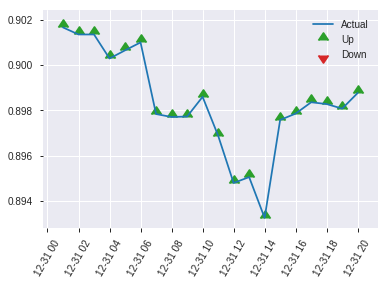


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2620452487938442
RMSE: 0.5119035541914553
LogLoss: 0.7398223627329563
Mean Per-Class Error: 0.4552632133746548
AUC: 0.544863280838235
pr_auc: 0.5576996037562661
Gini: 0.08972656167646997
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.038898117982211364: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    291  1        (291.0/291.0)
1      0    326  0        (0.0/326.0)
Total  0    617  0.4716   (291.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0388981    0.69141   399
max f2                       0.0388981    0.848516  399
max f0point5                 0.527467     0.584659  260
max accuracy                 0.527467     0.547812  260
max precision                0.992025     1         0
max recall                   0.0388981    1         399
max specificity              0.992025     1         0
max absolute_mcc             0.565195     0.098093  126
max min_per_class_accuracy   0.544262     0.539519  200
max mean_per_class_accuracy  0.547851     0.544737  185

Gains/Lift Table: Avg response rate: 52.84 %, avg score: 54.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.966212           0.811131  0.811131           0.428571         0.979962  0.428571                    0.979962            0.00920245      0.00920245                 -18.8869  -18.8869
    2        0.0210697                   0.93068            1.26176   1.01911            0.666667         0.947851  0.538462                    0.965141            0.0122699       0.0214724                  26.1759   1.91128
    3        0.0307942                   0.882311           0.31544   0.7969             0.166667         0.905589  0.421053                    0.946335            0.00306748      0.0245399                  -68.456   -20.31
    4        0.0405186                   0.840353           0.946319  0.832761           0.5              0.852673  0.44                        0.923857            0.00920245      0.0337423                  -5.3681   -16.7239
    5        0.0502431                   0.809291           1.89264   1.0379             1                0.824471  0.548387                    0.904621            0.0184049       0.0521472                  89.2638   3.78983
    6        0.100486                    0.652372           1.09895   1.06842            0.580645         0.718244  0.564516                    0.811432            0.0552147       0.107362                   9.89511   6.84247
    7        0.150729                    0.593909           1.28211   1.13965            0.677419         0.622636  0.602151                    0.7485              0.0644172       0.171779                   28.211    13.9653
    8        0.200972                    0.571605           1.22106   1.16               0.645161         0.579522  0.612903                    0.706256            0.0613497       0.233129                   22.1057   16.0004
    9        0.299838                    0.559608           0.961832  1.09466            0.508197         0.565283  0.578378                    0.659773            0.095092        0.328221                   -3.81676  9.46609
    10       0.400324                    0.551234           1.09895   1.09574            0.580645         0.555447  0.578947                    0.633586            0.110429        0.43865                    9.89511   9.57378
    11       0.50081                     0.544272           0.976845  1.07188            0.516129         0.547648  0.566343                    0.616343            0.0981595       0.53681                    -2.31546  7.18824
    12       0.599676                    0.537536           0.961832  1.05374            0.508197         0.540504  0.556757                    0.603839            0.095092        0.631902                   -3.81676  5.3739
    13       0.700162                    0.531558           0.976845  1.0427             0.516129         0.534704  0.550926                    0.593917            0.0981595       0.730061                   -2.31546  4.27034
    14       0.799028                    0.51484            0.806698  1.0135             0.42623          0.524799  0.535497                    0.585365            0.0797546       0.809816                   -19.3302  1.35019
    15       0.899514                    0.450622           0.946319  1.006              0.5              0.484052  0.531532                    0.574047            0.095092        0.904908                   -5.3681   0.599679
    16       1                           0.0388981          0.946319  1                  0.5              0.331159  0.528363                    0.54964         

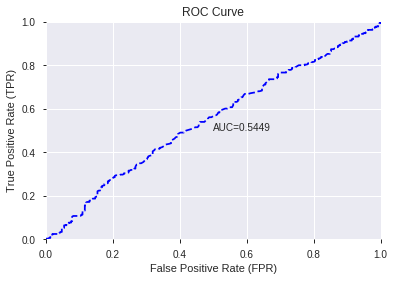

This function is available for GLM models only


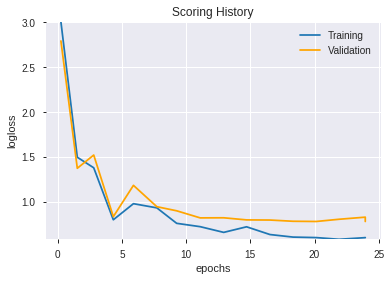

--2019-08-24 18:36:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.120.107
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.120.107|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190824_180445_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190824_180445_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_102_sid_87c2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'auto

['CORREL_8',
 'CDLDARKCLOUDCOVER',
 'CDLMORNINGDOJISTAR',
 'CDLEVENINGDOJISTAR',
 'CDLHOMINGPIGEON',
 'CDLMORNINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLSHOOTINGSTAR',
 'CDLMATCHINGLOW',
 'CDLXSIDEGAP3METHODS',
 'CDLHANGINGMAN',
 'CDLHAMMER',
 'CDLHARAMICROSS',
 'CORREL_20',
 'BOP',
 'CDLDRAGONFLYDOJI',
 'CDLGRAVESTONEDOJI',
 'CORREL_24',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'HT_TRENDMODE',
 'CDLSHORTLINE',
 'CDLDOJI',
 'BETA_12',
 'aroondown_14',
 'CDLRICKSHAWMAN',
 'aroonup_12',
 'CDLLONGLEGGEDDOJI',
 'AD',
 'DX_8',
 'STOCHRSI_fastd',
 'aroondown_12',
 'CDLSPINNINGTOP',
 'aroonup_14',
 'HT_DCPERIOD',
 'AROONOSC_12',
 'BETA_20',
 'ADX_24',
 'OBV',
 'CDLMARUBOZU',
 'ADOSC',
 'VAR_8',
 'TRANGE',
 'BETA_8',
 'STOCHF_fastk',
 'CDLLONGLINE',
 'BETA_14',
 'ADXR_14',
 'HT_PHASOR_quadrature',
 'aroondown_20',
 'VAR_20',
 'aroonup_20',
 'BETA_30',
 'aroonup_8',
 'DX_24',
 'ADXR_12',
 'CDLBELTHOLD',
 'aroondown_8',
 'MFI_8',
 'STOCH_slowd',
 'aroondown_24',
 'aroonup_30',
 'MFI_14',
 'ADX_20'

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190824_183650_model_1  0.553528  0.688431              0.469499  0.497641  0.247646

variable  relative_importance  scaled_importance    percentage
0                   CDLHAMMER         1.069124e-02           1.000000  1.723665e-02
1                         BOP         9.281430e-03           0.868134  1.496373e-02
2              CDLMORNINGSTAR         8.826398e-03           0.825573  1.423011e-02
3                 CDLBELTHOLD         8.765160e-03           0.819845  1.413138e-02
4                STOCHF_fastk         8.762086e-03           0.819557  1.412643e-02
..                        ...                  ...                ...           ...
584  BBANDS_middleband_14_4_5         4.323763e-06           0.000404  6.970865e-06
585  BBANDS_middleband_24_6_3         2.863686e-06           0.000268  4.616897e-06
586   BBANDS_lowerband_14_1_3         1.774948e-06           0.000166  2.861610e-06
587  BBANDS_middleband_14_4_2         1.132392e-06           0.000106  1.825667e-06
588   BBANDS_middleband_8_7_4         1.985921e-07           0.000019  3.201745e-07

[589 rows x 4 columns]

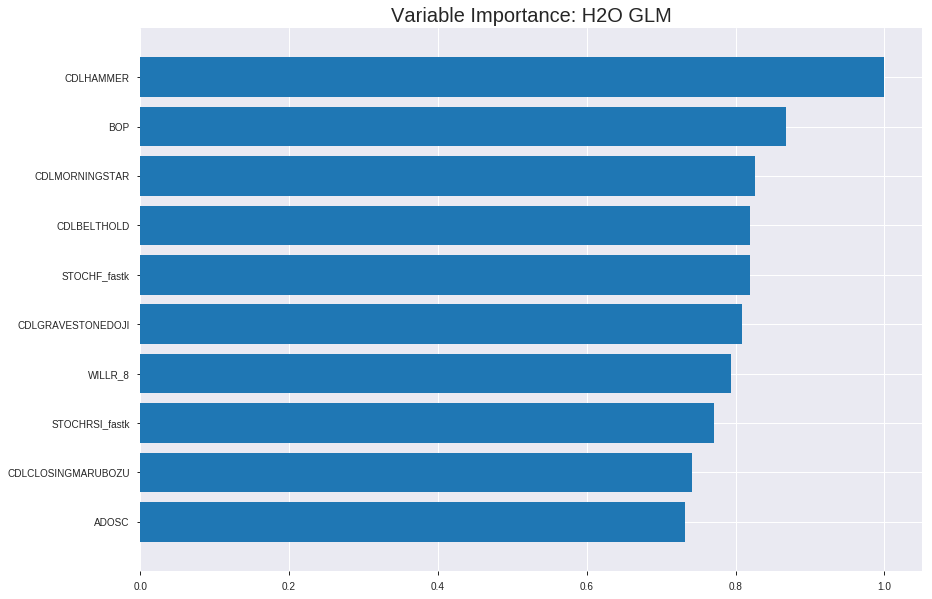

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190824_183650_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24715784446469397
RMSE: 0.4971497203707289
LogLoss: 0.6874398663439896
Null degrees of freedom: 4318
Residual degrees of freedom: 3729
Null deviance: 5980.312642429541
Residual deviance: 5938.105565479382
AIC: 7118.105565479382
AUC: 0.5669134349875338
pr_auc: 0.5826024301360945
Gini: 0.13382686997506754
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.446334978214701: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      6    2066  0.9971   (2066.0/2072.0)
1      1    2246  0.0004   (1.0/2247.0)
Total  7    4312  0.4786   (2067.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.446335     0.68486   394
max f2                       0.444393     0.844483  396
max f0point5                 0.496673     0.582904  298
max accuracy                 0.515248     0.554295  223
max precision                0.612448     1         0
max recall                   0.444393     1         396
max specificity              0.612448     1         0
max absolute_mcc             0.515248     0.103857  223
max min_per_class_accuracy   0.519954     0.542946  203
max mean_per_class_accuracy  0.515248     0.55141   223

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 52.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.579679           1.48527   1.48527            0.772727         0.588781  0.772727                    0.588781            0.0151313       0.0151313                  48.5273   48.5273
    2        0.0201436                   0.57284            1.25161   1.36979            0.651163         0.576095  0.712644                    0.582511            0.0124611       0.0275923                  25.1612   36.9786
    3        0.0300996                   0.568776           1.34101   1.36027            0.697674         0.570739  0.707692                    0.578617            0.0133511       0.0409435                  34.1013   36.0268
    4        0.0400556                   0.565506           1.25161   1.33326            0.651163         0.56692   0.693642                    0.57571             0.0124611       0.0534045                  25.1612   33.3261
    5        0.0500116                   0.56199            1.34101   1.3348             0.697674         0.563576  0.694444                    0.573294            0.0133511       0.0667557                  34.1013   33.4804
    6        0.100023                    0.552931           1.09454   1.21467            0.569444         0.556983  0.631944                    0.565139            0.0547397       0.121495                   9.45396   21.4672
    7        0.150035                    0.546356           1.11234   1.18056            0.578704         0.549296  0.614198                    0.559858            0.0556297       0.177125                   11.2337   18.056
    8        0.200046                    0.541536           1.05005   1.14793            0.546296         0.543889  0.597222                    0.555866            0.0525145       0.22964                    5.00462   14.7932
    9        0.300069                    0.533104           1.09899   1.13162            0.571759         0.537075  0.588735                    0.549602            0.109924        0.339564                   9.8989    13.1618
    10       0.400093                    0.526003           1.0278    1.10566            0.534722         0.529523  0.575231                    0.544582            0.102804        0.442368                   2.77994   10.5663
    11       0.500116                    0.519905           1.0011    1.08475            0.520833         0.523034  0.564352                    0.540273            0.100134        0.542501                   0.110332  8.47511
    12       0.599907                    0.513619           1.0391    1.07716            0.540603         0.516776  0.560401                    0.536364            0.103694        0.646195                   3.91034   7.71578
    13       0.699931                    0.506665           0.921015  1.05484            0.479167         0.510146  0.548793                    0.532617            0.0921228       0.738318                   -7.89849  5.48443
    14       0.799954                    0.498536           0.925464  1.03867            0.481481         0.50272   0.540376                    0.528879            0.0925679       0.830886                   -7.45356  3.86672
    15       0.899977                    0.488078           0.872072  1.02015            0.453704         0.493938  0.530744                    0.524996            0.0872274       0.918113                   -12.7928  2.01518
    16       1                           0.416268           0.81868   1                  0.425926         0.477642  0.520259                    0.520259          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24897831376917973
RMSE: 0.4989772677880023
LogLoss: 0.6911200948561972
Null degrees of freedom: 1233
Residual degrees of freedom: 644
Null deviance: 1711.0932050440474
Residual deviance: 1705.6843941050947
AIC: 2885.6843941050947
AUC: 0.5534920872647398
pr_auc: 0.5417188581456563
Gini: 0.1069841745294795
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46677629830354017: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      6    601   0.9901   (601.0/607.0)
1      3    624   0.0048   (3.0/627.0)
Total  9    1225  0.4895   (604.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466776     0.673866  391
max f2                       0.424654     0.837787  399
max f0point5                 0.494456     0.568384  337
max accuracy                 0.527882     0.548622  200
max precision                0.549386     0.606195  106
max recall                   0.424654     1         399
max specificity              0.647666     0.998353  0
max absolute_mcc             0.535596     0.100761  165
max min_per_class_accuracy   0.526551     0.542265  208
max mean_per_class_accuracy  0.527882     0.549016  200

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 52.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.599522           1.05975   1.05975            0.538462         0.619318  0.538462                    0.619318            0.0111643       0.0111643                  5.97473   5.97473
    2        0.0202593                   0.586954           0.820043  0.944689           0.416667         0.5906    0.48                        0.605533            0.00797448      0.0191388                  -17.9957  -5.5311
    3        0.0299838                   0.581102           0.820043  0.904263           0.416667         0.58435   0.459459                    0.598663            0.00797448      0.0271132                  -17.9957  -9.57369
    4        0.0405186                   0.570566           0.756962  0.865965           0.384615         0.574477  0.44                        0.592374            0.00797448      0.0350877                  -24.3038  -13.4035
    5        0.0502431                   0.568571           1.14806   0.920564           0.583333         0.569598  0.467742                    0.587966            0.0111643       0.046252                   14.806    -7.94361
    6        0.100486                    0.55835            1.17451   1.04754            0.596774         0.562212  0.532258                    0.575089            0.0590112       0.105263                   17.4513   4.75382
    7        0.149919                    0.552612           1.25829   1.11703            0.639344         0.555502  0.567568                    0.568631            0.062201        0.167464                   25.8295   11.7031
    8        0.200162                    0.548134           1.33323   1.1713             0.677419         0.550122  0.595142                    0.563985            0.0669856       0.23445                    33.323    17.13
    9        0.299838                    0.538967           1.07206   1.13831            0.544715         0.543048  0.578378                    0.557025            0.106858        0.341308                   7.20556   13.8308
    10       0.400324                    0.533037           1.06341   1.11951            0.540323         0.536218  0.568826                    0.551802            0.106858        0.448166                   6.341     11.9507
    11       0.5                         0.526438           0.96005   1.08772            0.487805         0.529534  0.552674                    0.547363            0.0956938       0.54386                    -3.99502  8.77193
    12       0.599676                    0.519565           0.896046  1.05586            0.455285         0.523131  0.536486                    0.543335            0.0893142       0.633174                   -10.3954  5.58602
    13       0.700162                    0.511949           0.984051  1.04555            0.5              0.515649  0.53125                     0.539362            0.0988836       0.732057                   -1.5949   4.55542
    14       0.799838                    0.504605           0.912047  1.02892            0.463415         0.508513  0.522796                    0.535517            0.0909091       0.822967                   -8.79527  2.89166
    15       0.899514                    0.49422            0.96005   1.02129            0.487805         0.499445  0.518919                    0.53152             0.0956938       0.91866                    -3.99502  2.12854
    16       1                           0.424654           0.809461  1                  0.41129          0.482708  0.508104                    0.526615        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-24 18:36:53  0.000 sec   2            3.3       590           1.37777           1.38253
    2019-08-24 18:36:54  1.606 sec   4            2.4       590           1.3764            1.38229
    2019-08-24 18:36:56  3.193 sec   6            1.7       590           1.37488           1.38224
    2019-08-24 18:36:57  4.764 sec   8            1.3       590           1.37328           1.38235
    2019-08-24 18:36:59  6.388 sec   10           0.92      590           1.37163           1.38265
    2019-08-24 18:37:01  7.997 sec   12           0.67      590           1.36995           1.38325
    2019-08-24 18:37:02  9.585 sec   14           0.49      590           1.36827           1.3842
    2019-08-24 18:37:04  11.213 sec  16           0.35      590           1.36662           1.38556

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5591572123176661)

('F1', 0.6995614035087719)

('auc', 0.5535281344211835)

('logloss', 0.6884313021190056)

('mean_per_class_error', 0.4542143655261105)

('rmse', 0.49764072082342065)

('mse', 0.24764628702165367)

glm prediction progress: |████████████████████████████████████████████████| 100%


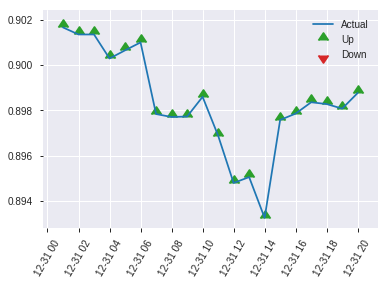


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.24764628702165367
RMSE: 0.49764072082342065
LogLoss: 0.6884313021190056
Null degrees of freedom: 616
Residual degrees of freedom: 27
Null deviance: 853.5195608018752
Residual deviance: 849.524226814853
AIC: 2029.5242268148531
AUC: 0.5535281344211835
pr_auc: 0.5697305132790839
Gini: 0.10705626884236707
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4800162578883599: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      24   267  0.9175   (267.0/291.0)
1      7    319  0.0215   (7.0/326.0)
Total  31   586  0.4441   (274.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.480016     0.699561  372
max f2                       0.4299       0.848516  399
max f0point5                 0.480016     0.597378  372
max accuracy                 0.498318     0.559157  296
max precision                0.596166     1         0
max recall                   0.4299       1         399
max specificity              0.596166     1         0
max absolute_mcc             0.480016     0.139402  372
max min_per_class_accuracy   0.51437      0.5189    204
max mean_per_class_accuracy  0.521399     0.545786  169

Gains/Lift Table: Avg response rate: 52.84 %, avg score: 51.63 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.570011           1.08151   1.08151            0.571429         0.58187   0.571429                    0.58187             0.0122699       0.0122699                  8.15074   8.15074
    2        0.0210697                   0.565853           0.946319  1.01911            0.5              0.567582  0.538462                    0.575276            0.00920245      0.0214724                  -5.3681   1.91128
    3        0.0307942                   0.562537           1.5772    1.19535            0.833333         0.564177  0.631579                    0.571771            0.0153374       0.0368098                  57.7198   19.535
    4        0.0405186                   0.55957            1.26176   1.21129            0.666667         0.560883  0.64                        0.569158            0.0122699       0.0490798                  26.1759   21.1288
    5        0.0502431                   0.556466           1.26176   1.22106            0.666667         0.558256  0.645161                    0.567048            0.0122699       0.0613497                  26.1759   22.1057
    6        0.100486                    0.547624           1.16      1.19053            0.612903         0.551653  0.629032                    0.559351            0.0582822       0.119632                   16.0004   19.053
    7        0.150729                    0.542036           1.22106   1.20071            0.645161         0.544935  0.634409                    0.554545            0.0613497       0.180982                   22.1057   20.0706
    8        0.200972                    0.537035           0.793687  1.09895            0.419355         0.539548  0.580645                    0.550796            0.0398773       0.220859                   -20.6313  9.89511
    9        0.299838                    0.528112           1.11697   1.10489            0.590164         0.532626  0.583784                    0.544805            0.110429        0.331288                   11.6967   10.4891
    10       0.400324                    0.521137           1.12948   1.11106            0.596774         0.524753  0.587045                    0.539772            0.113497        0.444785                   12.9478   11.1063
    11       0.50081                     0.514394           0.732634  1.03513            0.387097         0.517951  0.546926                    0.535393            0.0736196       0.518405                   -26.7366  3.51321
    12       0.599676                    0.508795           1.14799   1.05374            0.606557         0.511503  0.556757                    0.531455            0.113497        0.631902                   14.7994   5.3739
    13       0.700162                    0.502345           1.00737   1.04708            0.532258         0.50567   0.553241                    0.527754            0.101227        0.733129                   0.737186  4.70845
    14       0.799028                    0.495987           0.930806  1.0327             0.491803         0.499223  0.545639                    0.524224            0.0920245       0.825153                   -6.91944  3.2697
    15       0.899514                    0.486685           1.00737   1.02987            0.532258         0.491447  0.544144                    0.520562            0.101227        0.92638                    0.737186  2.98679
    16       1                           0.4299             0.732634  1                  0.387097         0.47776   0.528363                    0.516261            0

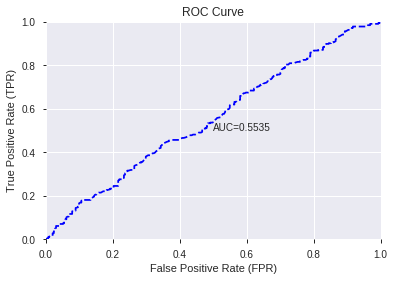

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


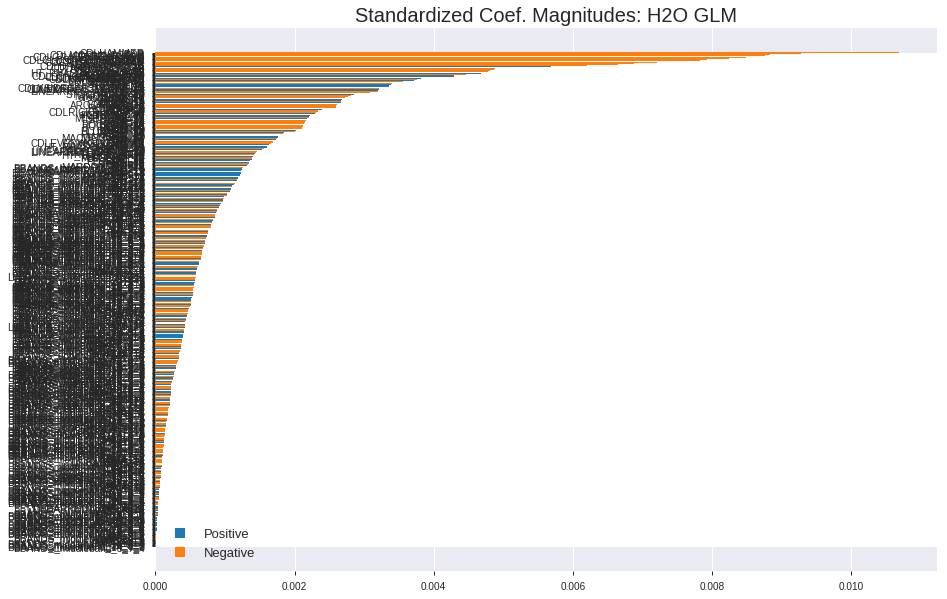

'log_likelihood'
--2019-08-24 18:37:17--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190824_183650_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190824_183650_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_110_sid_87c2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_110

['CDLHAMMER',
 'BOP',
 'CDLMORNINGSTAR',
 'CDLBELTHOLD',
 'STOCHF_fastk',
 'CDLGRAVESTONEDOJI',
 'WILLR_8',
 'STOCHRSI_fastk',
 'CDLCLOSINGMARUBOZU',
 'ADOSC',
 'CDLSHOOTINGSTAR',
 'CDLHANGINGMAN',
 'aroondown_14',
 'CDLLONGLINE',
 'ULTOSC',
 'CDLDRAGONFLYDOJI',
 'AROONOSC_14',
 'AROONOSC_12',
 'CDLHARAMICROSS',
 'STOCHF_fastd',
 'STOCH_slowk',
 'aroondown_12',
 'AD',
 'HT_PHASOR_quadrature',
 'CDLDOJI',
 'VAR_24',
 'STOCH_slowd',
 'CDLLONGLEGGEDDOJI',
 'CDLHOMINGPIGEON',
 'MACDEXT_hist',
 'CDLSPINNINGTOP',
 'CDLMATCHINGLOW',
 'CDLMARUBOZU',
 'CDLHARAMI',
 'CDLSHORTLINE',
 'MFI_12',
 'STDDEV_24',
 'CCI_8',
 'BETA_24',
 'aroonup_12',
 'VAR_20',
 'CDLXSIDEGAP3METHODS',
 'LINEARREG_SLOPE_14',
 'CDLMORNINGDOJISTAR',
 'LINEARREG_ANGLE_14',
 'DX_8',
 'WILLR_20',
 'STOCHRSI_fastd',
 'MFI_14',
 'CORREL_20',
 'MINUS_DM_30',
 'aroondown_24',
 'WILLR_14',
 'RSI_8',
 'MOM_14',
 'CMO_8',
 'ROC_14',
 'ROCP_14',
 'WILLR_12',
 'CORREL_24',
 'ROCR_14',
 'AROONOSC_30',
 'MOM_8',
 'ROC_8',
 'ROCR100_8',


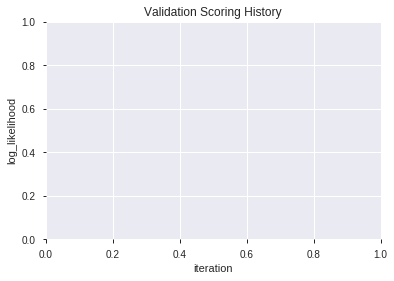

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190824_183726_model_5  0.578653  0.690535              0.498282  0.498164  0.248167
1               XGBoost_3_AutoML_20190824_183726  0.572871  0.683363              0.472936  0.495141  0.245165
2  XGBoost_grid_1_AutoML_20190824_183726_model_7  0.570784  0.684656              0.464033  0.495723  0.245741
3  XGBoost_grid_1_AutoML_20190824_183726_model_2  0.564675  0.686384              0.487419  0.496616  0.246627
4               XGBoost_1_AutoML_20190824_183726  0.556880  0.690132              0.496195  0.498340  0.248342
5  XGBoost_grid_1_AutoML_20190824_183726_model_3  0.555858  0.685109              0.471033  0.496053  0.246069
6               XGBoost_2_AutoML_20190824_183726  0.543735  0.690253              0.483429  0.498503  0.248505
7  XGBoost_grid_1_AutoML_20190824_183726_model_4  0.537137  0.689747              0.493127  0.498307  0.248310
8  XGBoost_grid_1_AutoML_20190824_183726_model_6  0.522911  0.694600              0.466490  0.500575  0.250575
9  XGBoost_grid_1_AutoML_20190824_183726_model_1  0.521435  0.703338              0.494661  0.504725  0.254748

variable  relative_importance  scaled_importance    percentage
0                         BOP           984.683655           1.000000  1.867068e-02
1                      TRANGE           724.080017           0.735343  1.372935e-02
2      BBANDS_upperband_8_2_4           719.859985           0.731057  1.364933e-02
3                       CCI_8           702.178894           0.713101  1.331408e-02
4                       MFI_8           637.292725           0.647206  1.208377e-02
..                        ...                  ...                ...           ...
496                 MAVP_20_3             2.013064           0.002044  3.816990e-05
497   BBANDS_middleband_8_7_3             2.006387           0.002038  3.804330e-05
498  BBANDS_middleband_14_4_2             1.773450           0.001801  3.362656e-05
499                  MAVP_8_8             0.706217           0.000717  1.339064e-05
500  BBANDS_middleband_12_2_5             0.040067           0.000041  7.597062e-07

[501 rows x 4 columns]

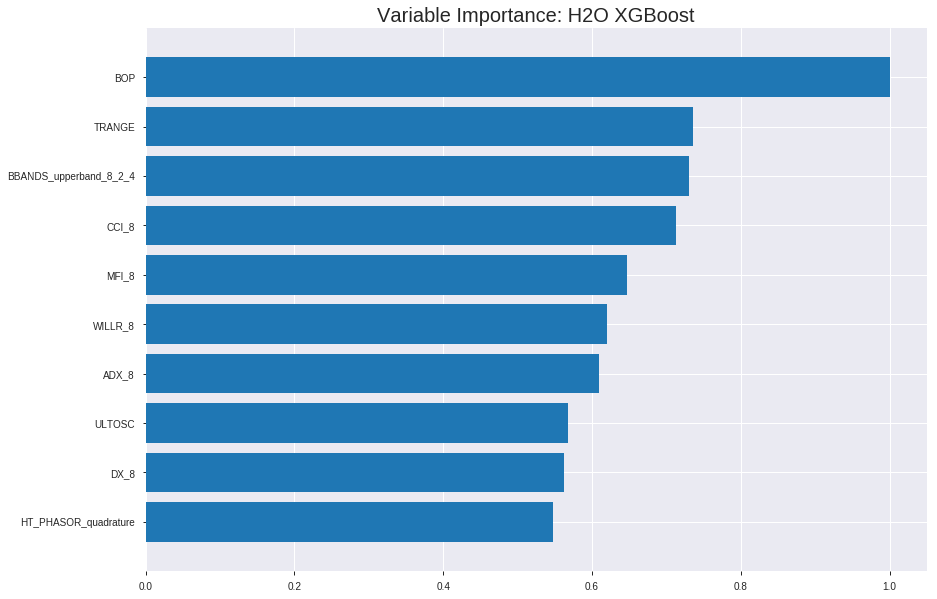

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190824_183726_model_5


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.05409638057417277
RMSE: 0.23258628629859665
LogLoss: 0.2561818833332503
Mean Per-Class Error: 0.0007051443967331927
AUC: 0.9999983891005253
pr_auc: 0.9995534771713516
Gini: 0.9999967782010506
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5128215551376343: 


0     1     Error    Rate
-----  ----  ----  -------  ------------
0      2069  3     0.0014   (3.0/2072.0)
1      0     2247  0        (0.0/2247.0)
Total  2069  2250  0.0007   (3.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.512822     0.999333  198
max f2                       0.512822     0.999733  198
max f0point5                 0.560182     0.999643  192
max accuracy                 0.53404      0.999305  196
max precision                0.927684     1         0
max recall                   0.512822     1         198
max specificity              0.927684     1         0
max absolute_mcc             0.512822     0.998609  198
max min_per_class_accuracy   0.537785     0.999035  195
max mean_per_class_accuracy  0.53404      0.999295  196

Gains/Lift Table: Avg response rate: 52.03 %, avg score: 52.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.892427           1.92212   1.92212            1                0.903686  1                           0.903686            0.0195817       0.0195817                  92.2118   92.2118
    2        0.0201436                   0.880631           1.92212   1.92212            1                0.885534  1                           0.894715            0.0191366       0.0387183                  92.2118   92.2118
    3        0.0300996                   0.872811           1.92212   1.92212            1                0.876165  1                           0.888579            0.0191366       0.0578549                  92.2118   92.2118
    4        0.0400556                   0.866598           1.92212   1.92212            1                0.869964  1                           0.883952            0.0191366       0.0769915                  92.2118   92.2118
    5        0.0500116                   0.861355           1.92212   1.92212            1                0.863936  1                           0.879968            0.0191366       0.0961282                  92.2118   92.2118
    6        0.100023                    0.842655           1.92212   1.92212            1                0.851526  1                           0.865747            0.0961282       0.192256                   92.2118   92.2118
    7        0.150035                    0.826434           1.92212   1.92212            1                0.834803  1                           0.855432            0.0961282       0.288385                   92.2118   92.2118
    8        0.200046                    0.810164           1.92212   1.92212            1                0.818437  1                           0.846183            0.0961282       0.384513                   92.2118   92.2118
    9        0.300069                    0.780771           1.92212   1.92212            1                0.795953  1                           0.82944             0.192256        0.576769                   92.2118   92.2118
    10       0.400093                    0.742762           1.92212   1.92212            1                0.763123  1                           0.812861            0.192256        0.769025                   92.2118   92.2118
    11       0.500116                    0.657359           1.92212   1.92212            1                0.709664  1                           0.792221            0.192256        0.961282                   92.2118   92.2118
    12       0.599907                    0.293795           0.387991  1.66692            0.201856         0.398036  0.867233                    0.726651            0.0387183       1                          -61.2009  66.6924
    13       0.699931                    0.249117           0         1.42871            0                0.268229  0.743301                    0.66114             0               1                          -100      42.8713
    14       0.799954                    0.2137             0         1.25007            0                0.23066   0.650362                    0.607314            0               1                          -100      25.0072
    15       0.899977                    0.176887           0         1.11114            0                0.194907  0.578081                    0.56148             0               1                          -100      11.114
    16       1                           0.0841749          0         1                  0                0.149271  0.520259                    0.520249          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26521889431103596
RMSE: 0.5149940721125205
LogLoss: 0.7273474224330485
Mean Per-Class Error: 0.4816665747039457
AUC: 0.5158254705206929
pr_auc: 0.5262650652574026
Gini: 0.03165094104138588
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2111678272485733: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      2    605   0.9967   (605.0/607.0)
1      0    627   0        (0.0/627.0)
Total  2    1232  0.4903   (605.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.211168     0.674556   397
max f2                       0.211168     0.838235   397
max f0point5                 0.308144     0.565603   373
max accuracy                 0.524867     0.519449   223
max precision                0.887325     1          0
max recall                   0.211168     1          397
max specificity              0.887325     1          0
max absolute_mcc             0.734127     0.0594848  52
max min_per_class_accuracy   0.560696     0.507177   193
max mean_per_class_accuracy  0.715616     0.518333   64

Gains/Lift Table: Avg response rate: 50.81 %, avg score: 55.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.822861           1.21114   1.21114            0.615385         0.848075  0.615385                    0.848075            0.0127592       0.0127592                  21.114    21.114
    2        0.0202593                   0.803912           1.47608   1.33831            0.75             0.813915  0.68                        0.831678            0.0143541       0.0271132                  47.6077   33.8309
    3        0.0299838                   0.791462           0.656034  1.11703            0.333333         0.799796  0.567568                    0.821338            0.00637959      0.0334928                  -34.3966  11.7031
    4        0.0405186                   0.777564           0.908355  1.06278            0.461538         0.783983  0.54                        0.811626            0.00956938      0.0430622                  -9.16452  6.27751
    5        0.0502431                   0.766996           0.820043  1.01579            0.416667         0.772373  0.516129                    0.804028            0.00797448      0.0510367                  -17.9957  1.57946
    6        0.100486                    0.726604           1.26974   1.14277            0.645161         0.745011  0.580645                    0.77452             0.0637959       0.114833                   26.9743   14.2769
    7        0.149919                    0.699178           0.967919  1.08512            0.491803         0.711563  0.551351                    0.753761            0.0478469       0.162679                   -3.20809  8.51157
    8        0.200162                    0.67493            0.920564  1.04381            0.467742         0.68833   0.530364                    0.737337            0.046252        0.208931                   -7.94361  4.38112
    9        0.299838                    0.63362            0.912047  1.00001            0.463415         0.65448   0.508108                    0.709793            0.0909091       0.299841                   -8.79527  0.000862106
    10       0.400324                    0.594105           1.1269    1.03186            0.572581         0.614917  0.524291                    0.685978            0.113238        0.413078                   12.6897   3.18592
    11       0.5                         0.560077           0.944049  1.01435            0.479675         0.577447  0.515397                    0.664342            0.0940989       0.507177                   -5.5951   1.43541
    12       0.599676                    0.523504           1.10406   1.02926            0.560976         0.54161   0.522973                    0.643942            0.110048        0.617225                   10.4057   2.92642
    13       0.700162                    0.485703           0.984051  1.02278            0.5              0.503714  0.519676                    0.623817            0.0988836       0.716108                   -1.5949   2.27753
    14       0.799838                    0.440888           0.912047  1.00898            0.463415         0.464512  0.512665                    0.603964            0.0909091       0.807018                   -8.79527  0.897634
    15       0.899514                    0.382623           1.02405   1.01065            0.520325         0.412926  0.513514                    0.582795            0.102073        0.909091                   2.40531   1.0647
    16       1                           0.157219           0.904692  1                  0.459677         0.324581  0.508104                    0.556848      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-24 18:38:03  16.470 sec  0                  0.5              0.693147            0.5             0                  1                0.479741                         0.5                0.693147              0.5               0                    1                  0.491896
    2019-08-24 18:38:04  17.850 sec  5                  0.457014         0.610326            0.956319        0.958537           1.92212          0.111137                         0.501045           0.695275              0.509836          0.510728             1.36253            0.491896
    2019-08-24 18:38:05  18.767 sec  10                 0.420036         0.543595            0.988975        0.989612           1.92212          0.0481593                        0.503258           0.699868              0.50222           0.504678             0.756962           0.491896
    2019-08-24 18:38:06  19.670 sec  15                 0.388306         0.489224            0.996874        0.996682           1.92212          0.0254689                        0.505042           0.703677              0.500233          0.501961             0.908355           0.491896
    2019-08-24 18:38:07  20.567 sec  20                 0.361571         0.445398            0.999239        0.997965           1.92212          0.013429                         0.506884           0.707632              0.496077          0.499728             1.05975            0.488655
    2019-08-24 18:38:08  21.615 sec  25                 0.330731         0.397005            0.999748        0.999309           1.92212          0.00601991                       0.508465           0.711273              0.500721          0.502159             1.21114            0.487844
    2019-08-24 18:38:09  22.739 sec  30                 0.301885         0.3535              0.999952        0.999066           1.92212          0.00300996                       0.509624           0.71402               0.506085          0.509522             0.756962           0.485413
    2019-08-24 18:38:10  23.761 sec  35                 0.280301         0.322228            0.999988        0.998209           1.92212          0.00208382                       0.510356           0.715879              0.511926          0.516677             1.36253            0.488655
    2019-08-24 18:38:11  24.841 sec  40                 0.260378         0.294207            0.999997        0.998662           1.92212          0.00046307                       0.512817           0.721488              0.508542          0.518216             1.21114            0.485413
    2019-08-24 18:38:12  25.738 sec  45                 0.249239         0.278782            0.999998        0.999553           1.92212          0.00046307                       0.513625           0.723681              0.512134          0.521858             1.21114            0.489465
    2019-08-24 18:38:13  26.745 sec  50                 0.232586         0.256182            0.999998        0.999553           1.92212          0.000694605                      0.514994           0.727347              0.515825          0.526265             1.21114            0.490276

Variable Importances: 


variable                  relative_importance    scaled_importance      percentage
------------------------  ---------------------  ---------------------  ----------------------
BOP                       984.6836547851562      1.0                    0.018670681878838278
TRANGE                    724.0800170898438      0.7353427809744923     0.013729351135474998
BBANDS_upperband_8_2_4    719.8599853515625      0.7310571083955136     0.013649334706116028
CCI_8                     702.1788940429688      0.7131009950562996     0.013314081826179198
MFI_8                     637.292724609375       0.6472055482107327     0.012083768900861722
---                       ---                    ---                    ---
MAVP_20_3                 2.013063907623291      0.0020443762804842258  3.8169899173563637e-05
BBANDS_middleband_8_7_3   2.0063869953155518     0.002037595511579114   3.804329759444237e-05
BBANDS_middleband_14_4_2  1.7734501361846924     0.0018010354163659125  3.3626559311488996e-05
MAVP_8_8                  0.7062165141105652     0.0007172014186268294  1.339063953023305e-05
BBANDS_middleband_12_2_5  0.04006657376885414    4.068979268026551e-05  7.597061748491197e-07


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5834683954619124)

('F1', 0.6921443736730362)

('auc', 0.5786530474564122)

('logloss', 0.6905351623577891)

('mean_per_class_error', 0.41999768093943035)

('rmse', 0.49816402893279943)

('mse', 0.24816739972255902)

xgboost prediction progress: |████████████████████████████████████████████| 100%


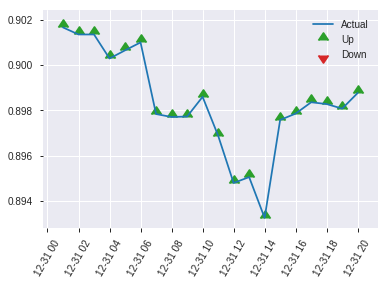


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24816739972255902
RMSE: 0.49816402893279943
LogLoss: 0.6905351623577891
Mean Per-Class Error: 0.41999768093943035
AUC: 0.5786530474564122
pr_auc: 0.5910180752596641
Gini: 0.15730609491282443
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2096548229455948: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    290  0.9966   (290.0/291.0)
1      0    326  0        (0.0/326.0)
Total  1    616  0.47     (290.0/617.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.209655     0.692144  398
max f2                       0.209655     0.848958  398
max f0point5                 0.508702     0.606852  225
max accuracy                 0.508702     0.583468  225
max precision                0.865201     1         0
max recall                   0.209655     1         398
max specificity              0.865201     1         0
max absolute_mcc             0.508702     0.161142  225
max min_per_class_accuracy   0.528718     0.567485  204
max mean_per_class_accuracy  0.508702     0.580002  225

Gains/Lift Table: Avg response rate: 52.84 %, avg score: 53.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113452                   0.800806           1.89264   1.89264            1                0.820072  1                           0.820072            0.0214724       0.0214724                  89.2638   89.2638
    2        0.0210697                   0.779952           0.946319  1.45588            0.5              0.788248  0.769231                    0.805384            0.00920245      0.0306748                  -5.3681   45.5875
    3        0.0307942                   0.763002           0.630879  1.19535            0.333333         0.770671  0.631579                    0.794422            0.00613497      0.0368098                  -36.9121  19.535
    4        0.0405186                   0.75151            0.946319  1.13558            0.5              0.758482  0.6                         0.785797            0.00920245      0.0460123                  -5.3681   13.5583
    5        0.0502431                   0.746096           1.26176   1.16               0.666667         0.749344  0.612903                    0.778741            0.0122699       0.0582822                  26.1759   16.0004
    6        0.100486                    0.704327           1.0379    1.09895            0.548387         0.723537  0.580645                    0.751139            0.0521472       0.110429                   3.78983   9.89511
    7        0.150729                    0.66944            1.16      1.1193             0.612903         0.686886  0.591398                    0.729721            0.0582822       0.168712                   16.0004   11.9302
    8        0.200972                    0.642467           1.28211   1.16               0.677419         0.655194  0.612903                    0.71109             0.0644172       0.233129                   28.211    16.0004
    9        0.299838                    0.597645           1.08594   1.13558            0.57377          0.617804  0.6                         0.680331            0.107362        0.340491                   8.59399   13.5583
    10       0.400324                    0.563804           1.12948   1.13405            0.596774         0.579706  0.59919                     0.655073            0.113497        0.453988                   12.9478   13.405
    11       0.50081                     0.528696           1.12948   1.13313            0.596774         0.544936  0.598706                    0.632974            0.113497        0.567485                   12.9478   13.3133
    12       0.599676                    0.49972            0.961832  1.10489            0.508197         0.512981  0.583784                    0.613191            0.095092        0.662577                   -3.81676  10.4891
    13       0.700162                    0.466169           0.824213  1.06461            0.435484         0.485614  0.5625                      0.594882            0.0828221       0.745399                   -17.5787  6.46089
    14       0.799028                    0.417571           0.868752  1.04038            0.459016         0.440409  0.549696                    0.575768            0.0858896       0.831288                   -13.1248  4.03751
    15       0.899514                    0.375168           0.946319  1.02987            0.5              0.396045  0.544144                    0.555691            0.095092        0.92638                    -5.3681   2.98679
    16       1                           0.177664           0.732634  1                  0.387097         0.323382  0.528363                    0.532347           

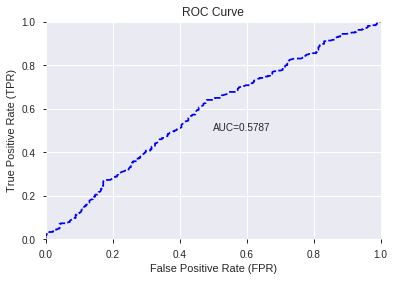

This function is available for GLM models only


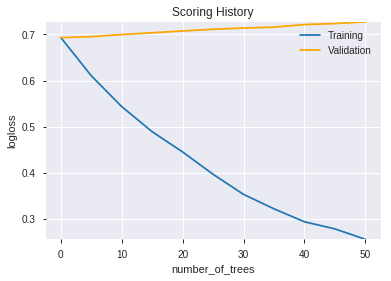

--2019-08-24 18:38:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.252
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.252|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.a

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190824_183726_model_5',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190824_183726_model_5',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_118_sid_87c2',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'TRANGE',
 'BBANDS_upperband_8_2_4',
 'CCI_8',
 'MFI_8',
 'WILLR_8',
 'ADX_8',
 'ULTOSC',
 'DX_8',
 'HT_PHASOR_quadrature',
 'BETA_12',
 'BETA_8',
 'STOCH_slowd',
 'MFI_14',
 'HT_DCPERIOD',
 'BETA_20',
 'MFI_12',
 'STOCHF_fastk',
 'MFI_30',
 'AD',
 'MINUS_DI_8',
 'MACDEXT_hist',
 'MOM_8',
 'BETA_30',
 'MACDFIX_hist_8',
 'PLUS_DM_8',
 'WILLR_12',
 'BBANDS_lowerband_8_2_4',
 'DX_30',
 'CCI_14',
 'MFI_20',
 'BBANDS_middleband_8_2_4',
 'BETA_14',
 'MINUS_DM_8',
 'STOCH_slowk',
 'ADOSC',
 'MACDFIX_8',
 'DX_14',
 'ADX_24',
 'HT_PHASOR_inphase',
 'ATR_8',
 'STOCHRSI_fastd',
 'WILLR_20',
 'MFI_24',
 'ADX_12',
 'AROONOSC_8',
 'STDDEV_8',
 'ADXR_12',
 'OBV',
 'BETA_24',
 'AROONOSC_24',
 'MOM_14',
 'PLUS_DM_14',
 'PLUS_DI_12',
 'MINUS_DI_14',
 'STDDEV_12',
 'CMO_8',
 'MINUS_DM_14',
 'ADX_20',
 'MINUS_DI_30',
 'MOM_12',
 'ROC_30',
 'CCI_20',
 'PLUS_DI_30',
 'MINUS_DM_30',
 'LINEARREG_ANGLE_8',
 'AROONOSC_30',
 'aroondown_8',
 'STOCHF_fastd',
 'DX_24',
 'MACDEXT_signal',
 'BBANDS_upperband

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.583
GLM             0.562
XGBoost         0.583
dtype: float64

DeepLearning    GLM  XGBoost
All          0.549  0.558    0.579
DLF          0.569  0.558    0.574
Fwe          0.556  0.562    0.574
RFE          0.548  0.559    0.583
XGBF         0.583  0.558    0.574





F1


DeepLearning    0.702
GLM             0.700
XGBoost         0.695
dtype: float64

DeepLearning    GLM  XGBoost
All          0.695  0.696    0.694
DLF          0.696  0.692    0.692
Fwe          0.691  0.691    0.695
RFE          0.691  0.700    0.692
XGBF         0.702  0.692    0.692





auc


DeepLearning    0.571
GLM             0.554
XGBoost         0.590
dtype: float64

DeepLearning    GLM  XGBoost
All          0.544  0.553    0.590
DLF          0.564  0.548    0.581
Fwe          0.556  0.553    0.560
RFE          0.545  0.554    0.579
XGBF         0.571  0.548    0.581





logloss


DeepLearning    0.805
GLM             0.688
XGBoost         0.691
dtype: float64

DeepLearning    GLM  XGBoost
All          0.699  0.688    0.679
DLF          0.730  0.688    0.681
Fwe          0.688  0.688    0.687
RFE          0.740  0.688    0.691
XGBF         0.805  0.688    0.681





mean_per_class_error


DeepLearning    0.455
GLM             0.457
XGBoost         0.440
dtype: float64

DeepLearning    GLM  XGBoost
All          0.444  0.457    0.419
DLF          0.438  0.451    0.419
Fwe          0.451  0.445    0.440
RFE          0.455  0.454    0.420
XGBF         0.419  0.451    0.419





rmse


DeepLearning    0.539
GLM             0.498
XGBoost         0.498
dtype: float64

DeepLearning    GLM  XGBoost
All          0.503  0.498    0.493
DLF          0.516  0.498    0.494
Fwe          0.497  0.498    0.497
RFE          0.512  0.498    0.498
XGBF         0.539  0.498    0.494





mse


DeepLearning    0.291
GLM             0.248
XGBoost         0.248
dtype: float64

DeepLearning    GLM  XGBoost
All          0.253  0.248    0.243
DLF          0.266  0.248    0.244
Fwe          0.247  0.248    0.247
RFE          0.262  0.248    0.248
XGBF         0.291  0.248    0.244

{'F1':       DeepLearning    GLM  XGBoost
 All          0.695    NaN      NaN
 DLF          0.696    NaN      NaN
 DLF            NaN  0.692      NaN
 DLF            NaN    NaN    0.692
 All            NaN  0.696      NaN
 All            NaN    NaN    0.694
 XGBF         0.702    NaN      NaN
 XGBF           NaN  0.692      NaN
 XGBF           NaN    NaN    0.692
 Fwe          0.691    NaN      NaN
 Fwe            NaN  0.691      NaN
 Fwe            NaN    NaN    0.695
 RFE          0.691    NaN      NaN
 RFE            NaN  0.700      NaN
 RFE            NaN    NaN    0.692,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.549    NaN      NaN
 DLF          0.569    NaN      NaN
 DLF            NaN  0.558      NaN
 DLF            NaN    NaN    0.574
 All            NaN  0.558      NaN
 All            NaN    NaN    0.579
 XGBF         0.583    NaN      NaN
 XGBF           NaN  0.558      NaN
 XGBF           NaN    NaN    0.574
 Fwe          0.556    NaN      NaN
 Fwe     